In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
import tensorflow_datasets as tfds
import tqdm
import os
import shutil
import re
import cv2
import time
import logging

In [ ]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [ ]:
data=tfds.load('tf_flowers')

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [ ]:
train_data=data['train'].skip(600)
test_data=data['train'].take(600)

In [ ]:
tqdm.tqdm(train_data)

  0%|          | 0/3070 [00:00<?, ?it/s]

  0%|          | 0/3070 [00:00<?, ?it/s]

In [ ]:
@tf.function
def build_data(data):
  cropped=tf.dtypes.cast(tf.image.random_crop(data['image'] / 255,(128,128,3)),tf.float32)

  lr=tf.image.resize(cropped,(32,32))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return (lr,cropped)

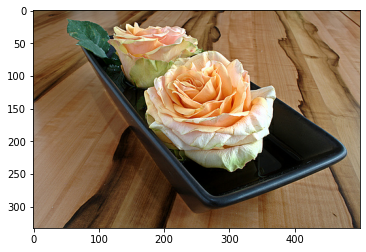

In [ ]:
for x in train_data.take(1):
  plt.imshow(x['image'])
  plt.show()

In [ ]:
def bicubic_interpolate(image,shape):
  img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
  return img_resized

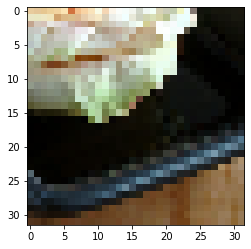

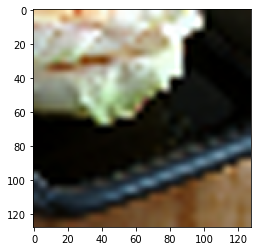

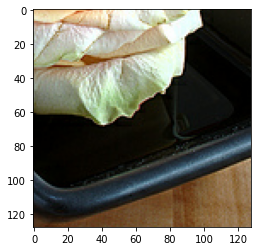

In [ ]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
  plt.imshow(x[0].numpy())
  plt.show()

  plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

In [ ]:
def residual_block_gen(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,3))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes=input_conv
for x in range(5):
  res_output=residual_block_gen()(SRRes)
  SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

SRRes=Upsample_block(SRRes)
SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

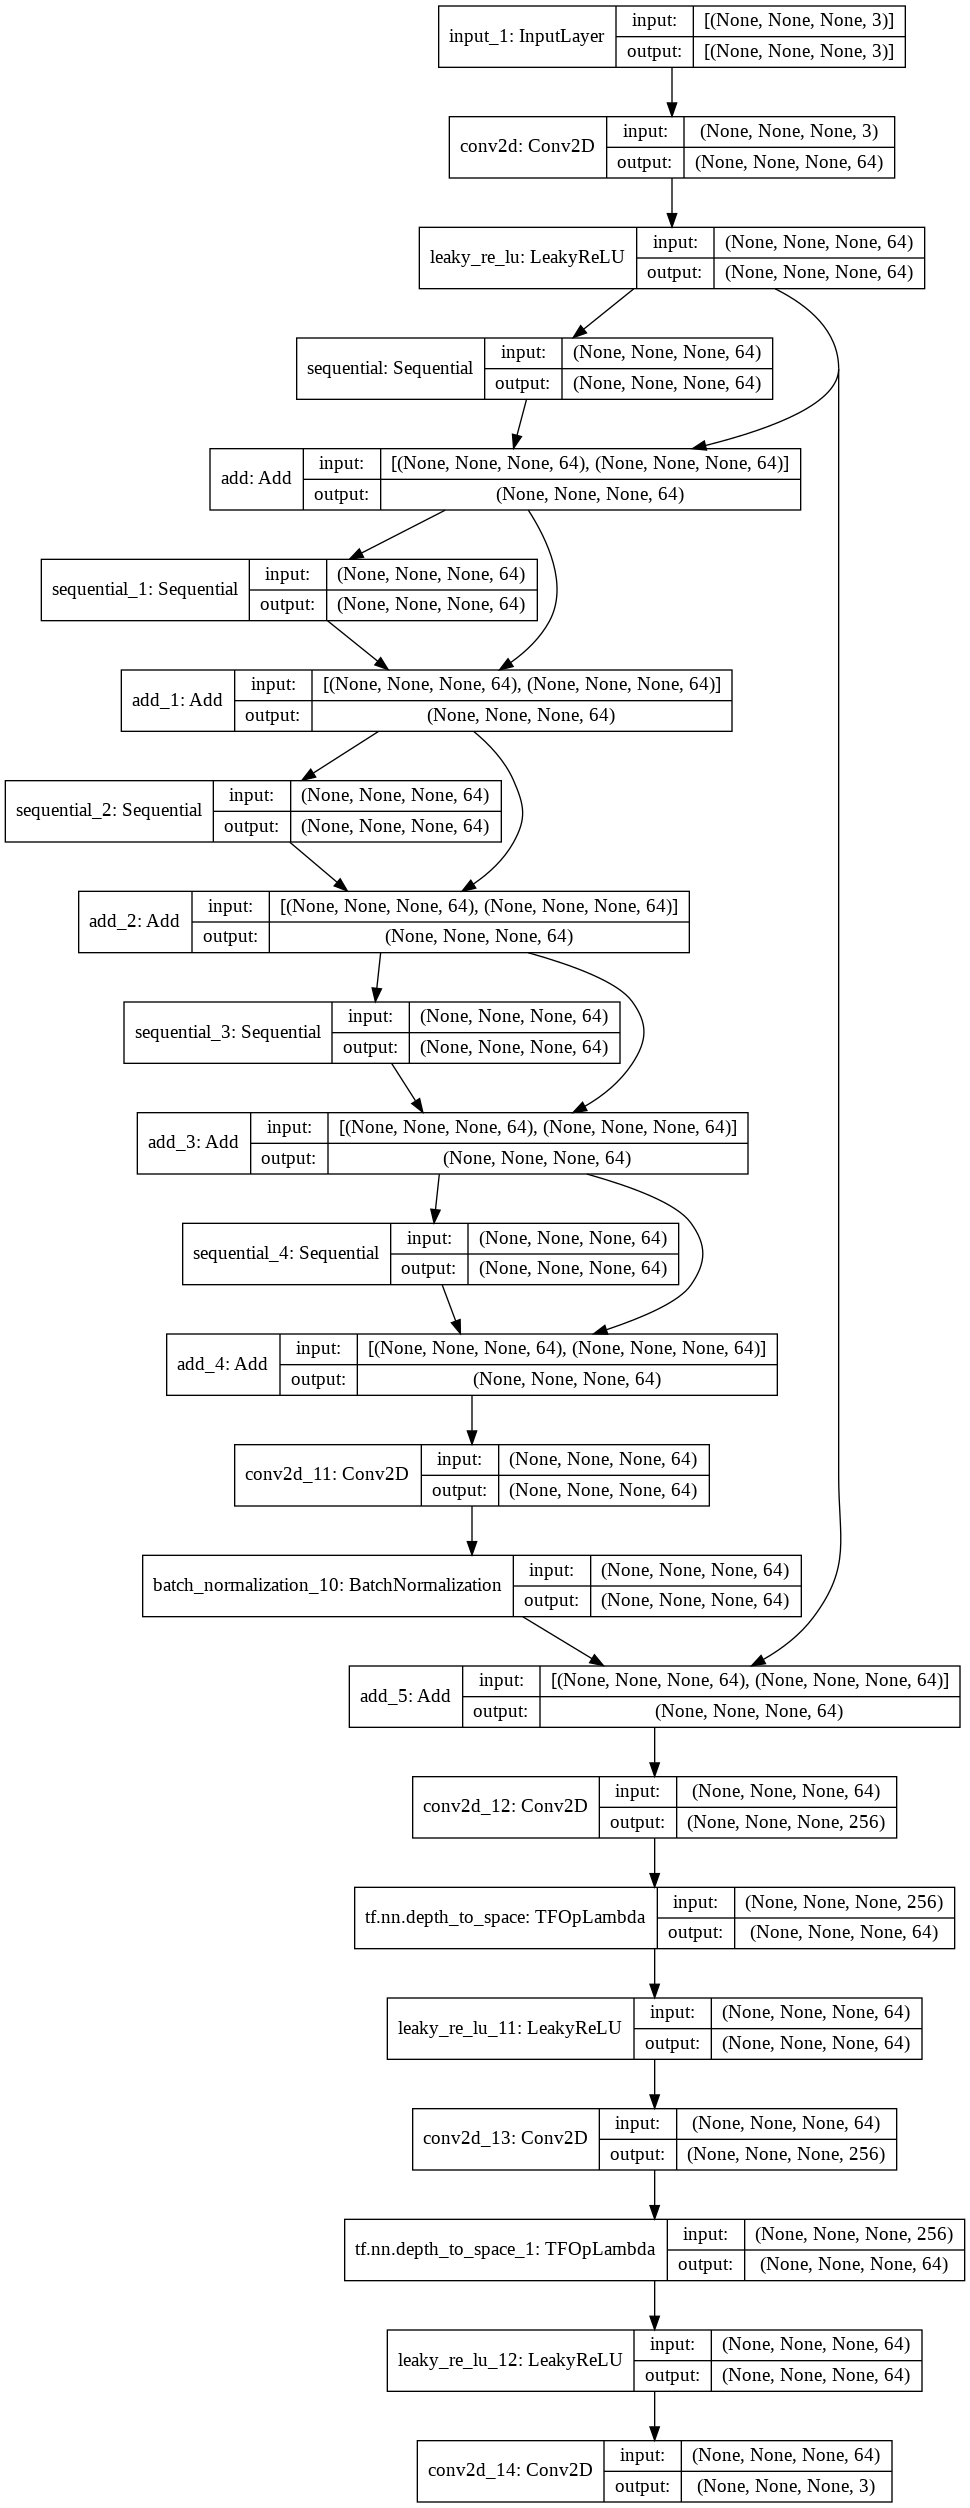

In [ ]:
tf.keras.utils.plot_model(SRResnet,show_shapes=True)

In [ ]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(128,128,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

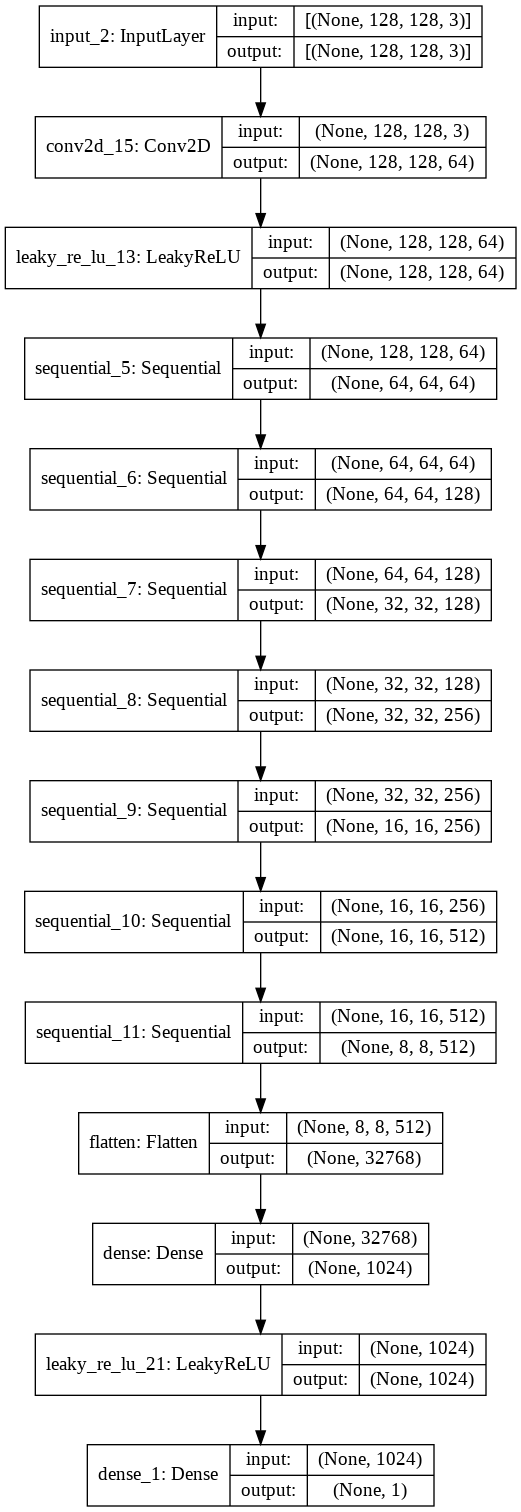

In [ ]:
tf.keras.utils.plot_model(discriminator,show_shapes=True)

In [ ]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))
VGG19.layers

80142336/80134624 [==============================] - 2s 0us/step


In [ ]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss
def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

In [ ]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# SRGAN-VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

#Real loss
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution = SRResnet(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

In [ ]:
SRResnet=tf.keras.models.load_model('/content/model (2).h5',compile=False)
discriminator=tf.keras.models.load_model('/content/model (2).h5',compile=False)

OSError: ignored

In [ ]:
for x in range(50):
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(64)
  
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
    for k in logs.keys():
      print(k,':',logs[k],end='  ')
    print()

  0%|          | 0/48 [00:00<?, ?it/s]

reconstruction : 

  2%|▏         | 1/48 [00:06<04:49,  6.16s/it]

tf.Tensor(0.76205355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037459694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09878746, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99335, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:06<03:25,  4.47s/it]

tf.Tensor(0.9080815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003963195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3826662, shape=(), dtype=float32)  PSNR : tf.Tensor(18.026644, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:07<02:27,  3.28s/it]

tf.Tensor(0.78168046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0010670259, shape=(), dtype=float32)  adv_d : tf.Tensor(0.64228326, shape=(), dtype=float32)  PSNR : tf.Tensor(18.573734, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:07<01:48,  2.46s/it]

tf.Tensor(0.90114003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057496903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.7676816, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24594, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:08<01:20,  1.88s/it]

tf.Tensor(0.89713323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0015468848, shape=(), dtype=float32)  adv_d : tf.Tensor(0.41914463, shape=(), dtype=float32)  PSNR : tf.Tensor(18.208618, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:08<01:01,  1.47s/it]

tf.Tensor(0.75104576, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041589024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08765632, shape=(), dtype=float32)  PSNR : tf.Tensor(18.84621, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:09<00:48,  1.19s/it]

tf.Tensor(0.7753456, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042573805, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06292981, shape=(), dtype=float32)  PSNR : tf.Tensor(18.16288, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:09<00:39,  1.01it/s]

tf.Tensor(0.8515818, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038443492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15503018, shape=(), dtype=float32)  PSNR : tf.Tensor(18.247631, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:10<00:33,  1.18it/s]

tf.Tensor(0.76810545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027346401, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13223355, shape=(), dtype=float32)  PSNR : tf.Tensor(19.039375, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:10<00:28,  1.33it/s]

tf.Tensor(0.774102, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034417612, shape=(), dtype=float32)  adv_d : tf.Tensor(0.080139115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.641516, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:11<00:25,  1.46it/s]

tf.Tensor(0.8525139, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004546436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15305716, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515585, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:11<00:22,  1.58it/s]

tf.Tensor(0.8626765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037322429, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16456105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.577154, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:12<00:21,  1.66it/s]

tf.Tensor(0.6978697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025881904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13003197, shape=(), dtype=float32)  PSNR : tf.Tensor(18.41549, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:12<00:19,  1.73it/s]

tf.Tensor(0.90910053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004184666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24762037, shape=(), dtype=float32)  PSNR : tf.Tensor(18.057146, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:13<00:18,  1.78it/s]

tf.Tensor(0.7469309, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0016778384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.35872647, shape=(), dtype=float32)  PSNR : tf.Tensor(19.08969, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:14<00:17,  1.82it/s]

tf.Tensor(0.7459619, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056778016, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16415192, shape=(), dtype=float32)  PSNR : tf.Tensor(18.75189, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:14<00:16,  1.84it/s]

tf.Tensor(0.88345325, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004560036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.29320708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.075235, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:15<00:16,  1.85it/s]

tf.Tensor(0.7958268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0010788586, shape=(), dtype=float32)  adv_d : tf.Tensor(0.60715115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.587788, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:15<00:15,  1.87it/s]

tf.Tensor(0.80487436, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063980543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.52441037, shape=(), dtype=float32)  PSNR : tf.Tensor(18.325214, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:16<00:14,  1.88it/s]

tf.Tensor(0.89553297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030866363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14862794, shape=(), dtype=float32)  PSNR : tf.Tensor(18.126999, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:16<00:14,  1.88it/s]

tf.Tensor(0.7489646, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023611167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16158426, shape=(), dtype=float32)  PSNR : tf.Tensor(18.889471, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:17<00:13,  1.89it/s]

tf.Tensor(0.8747233, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041089985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14573078, shape=(), dtype=float32)  PSNR : tf.Tensor(18.310875, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:17<00:13,  1.90it/s]

tf.Tensor(0.7237338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002055267, shape=(), dtype=float32)  adv_d : tf.Tensor(0.23068295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.934494, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:18<00:12,  1.90it/s]

tf.Tensor(0.8777296, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00496303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19536313, shape=(), dtype=float32)  PSNR : tf.Tensor(18.432957, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:18<00:12,  1.90it/s]

tf.Tensor(0.7473121, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002625743, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19228132, shape=(), dtype=float32)  PSNR : tf.Tensor(18.723965, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:19<00:11,  1.90it/s]

tf.Tensor(0.7585423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032989332, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07689874, shape=(), dtype=float32)  PSNR : tf.Tensor(18.990189, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:19<00:11,  1.90it/s]

tf.Tensor(0.7426611, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049096243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.110393666, shape=(), dtype=float32)  PSNR : tf.Tensor(19.129044, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:20<00:10,  1.90it/s]

tf.Tensor(0.77701473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043623336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0888304, shape=(), dtype=float32)  PSNR : tf.Tensor(18.656017, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:20<00:09,  1.90it/s]

tf.Tensor(0.8102516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00432377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1723626, shape=(), dtype=float32)  PSNR : tf.Tensor(18.858767, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:21<00:09,  1.90it/s]

tf.Tensor(0.9134059, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039409786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.19357128, shape=(), dtype=float32)  PSNR : tf.Tensor(18.041449, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:21<00:08,  1.90it/s]

tf.Tensor(0.7162044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026265746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12160052, shape=(), dtype=float32)  PSNR : tf.Tensor(18.375183, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:22<00:08,  1.90it/s]

tf.Tensor(0.80180156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00423322, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09466783, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78025, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:22<00:07,  1.90it/s]

tf.Tensor(0.80294824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024838985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17107445, shape=(), dtype=float32)  PSNR : tf.Tensor(18.220243, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:23<00:07,  1.90it/s]

tf.Tensor(0.89565986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051941825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.34863162, shape=(), dtype=float32)  PSNR : tf.Tensor(18.252525, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:24<00:06,  1.90it/s]

tf.Tensor(0.8354592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003101836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.21610598, shape=(), dtype=float32)  PSNR : tf.Tensor(18.49017, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:24<00:06,  1.90it/s]

tf.Tensor(0.87302214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029670307, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12603532, shape=(), dtype=float32)  PSNR : tf.Tensor(18.268358, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:25<00:05,  1.91it/s]

tf.Tensor(0.7791926, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034505383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08400573, shape=(), dtype=float32)  PSNR : tf.Tensor(18.611372, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:25<00:05,  1.90it/s]

tf.Tensor(0.85779697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032447702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11323494, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67546, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:26<00:04,  1.90it/s]

tf.Tensor(0.77519447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031546312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09128748, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82707, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:26<00:04,  1.90it/s]

tf.Tensor(0.7899256, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034237825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1345003, shape=(), dtype=float32)  PSNR : tf.Tensor(19.139618, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:27<00:03,  1.91it/s]

tf.Tensor(0.66813487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0023266282, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17978765, shape=(), dtype=float32)  PSNR : tf.Tensor(18.917583, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:27<00:03,  1.91it/s]

tf.Tensor(0.78452235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005053801, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08336053, shape=(), dtype=float32)  PSNR : tf.Tensor(18.260674, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:28<00:02,  1.90it/s]

tf.Tensor(0.7396316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00474281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.58102, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:28<00:02,  1.90it/s]

tf.Tensor(0.87765133, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005551305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.36846885, shape=(), dtype=float32)  PSNR : tf.Tensor(18.28061, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:29<00:01,  1.90it/s]

tf.Tensor(0.7408867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0014247923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.49583644, shape=(), dtype=float32)  PSNR : tf.Tensor(18.455244, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:29<00:01,  1.91it/s]

tf.Tensor(0.8837874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052117207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.35987017, shape=(), dtype=float32)  PSNR : tf.Tensor(18.661604, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:30<00:00,  1.91it/s]

tf.Tensor(0.78776586, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036278781, shape=(), dtype=float32)  adv_d : tf.Tensor(0.078193516, shape=(), dtype=float32)  PSNR : tf.Tensor(18.77118, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8970555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029980899, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11518083, shape=(), dtype=float32)  PSNR : tf.Tensor(18.198685, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.72it/s]

tf.Tensor(0.744828, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036327823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07692666, shape=(), dtype=float32)  PSNR : tf.Tensor(19.292028, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:25,  1.78it/s]

tf.Tensor(0.8737448, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045963107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.23467085, shape=(), dtype=float32)  PSNR : tf.Tensor(18.09033, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:24,  1.82it/s]

tf.Tensor(0.833052, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002996739, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1198266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.671621, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.8694529, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032133386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.090159066, shape=(), dtype=float32)  PSNR : tf.Tensor(18.266836, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.87it/s]

tf.Tensor(0.8977355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039058025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.097708106, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33295, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.88it/s]

tf.Tensor(0.7191919, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036336398, shape=(), dtype=float32)  adv_d : tf.Tensor(0.073880225, shape=(), dtype=float32)  PSNR : tf.Tensor(19.070198, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.89it/s]

tf.Tensor(0.76799697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042278366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047940828, shape=(), dtype=float32)  PSNR : tf.Tensor(18.639086, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.84324694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003873648, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14799821, shape=(), dtype=float32)  PSNR : tf.Tensor(18.223005, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.7652095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028952553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12290141, shape=(), dtype=float32)  PSNR : tf.Tensor(18.68251, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.90it/s]

tf.Tensor(0.7582024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040423106, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058862228, shape=(), dtype=float32)  PSNR : tf.Tensor(18.81789, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.91it/s]

tf.Tensor(0.8265944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047916546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11136275, shape=(), dtype=float32)  PSNR : tf.Tensor(18.605574, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.7870924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00415702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06045968, shape=(), dtype=float32)  PSNR : tf.Tensor(18.773052, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.80209416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043186243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05420904, shape=(), dtype=float32)  PSNR : tf.Tensor(18.365696, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.91652054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004360904, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16124886, shape=(), dtype=float32)  PSNR : tf.Tensor(18.161057, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.78890425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024160855, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14985001, shape=(), dtype=float32)  PSNR : tf.Tensor(18.631857, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7046835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004540749, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031473584, shape=(), dtype=float32)  PSNR : tf.Tensor(18.914711, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.9147768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048548565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.2095756, shape=(), dtype=float32)  PSNR : tf.Tensor(17.985167, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.7609246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.001652028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.36291772, shape=(), dtype=float32)  PSNR : tf.Tensor(19.274452, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.75828415, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053220866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12877434, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85168, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8714865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049975635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13121386, shape=(), dtype=float32)  PSNR : tf.Tensor(18.377699, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7900101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003750819, shape=(), dtype=float32)  adv_d : tf.Tensor(0.086112976, shape=(), dtype=float32)  PSNR : tf.Tensor(18.781757, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8233114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004474096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05178939, shape=(), dtype=float32)  PSNR : tf.Tensor(18.715714, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.6933302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026784465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1334853, shape=(), dtype=float32)  PSNR : tf.Tensor(19.104914, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.9077322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050997795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16435799, shape=(), dtype=float32)  PSNR : tf.Tensor(18.215673, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.91it/s]

tf.Tensor(0.74723786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025377858, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16066293, shape=(), dtype=float32)  PSNR : tf.Tensor(18.601517, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.91it/s]

tf.Tensor(0.74559695, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036527978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06327806, shape=(), dtype=float32)  PSNR : tf.Tensor(19.088503, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.76985055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00518349, shape=(), dtype=float32)  adv_d : tf.Tensor(0.079568334, shape=(), dtype=float32)  PSNR : tf.Tensor(18.957174, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.91it/s]

tf.Tensor(0.78503734, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004418533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056825116, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515959, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8444013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004536416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09762729, shape=(), dtype=float32)  PSNR : tf.Tensor(18.51021, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.9189568, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046326504, shape=(), dtype=float32)  adv_d : tf.Tensor(0.20572159, shape=(), dtype=float32)  PSNR : tf.Tensor(18.253756, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7740146, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024655962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15729932, shape=(), dtype=float32)  PSNR : tf.Tensor(18.608307, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.79817873, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004762807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05479074, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78025, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8549525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034818342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09138486, shape=(), dtype=float32)  PSNR : tf.Tensor(18.200514, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.84122, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051098866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13828959, shape=(), dtype=float32)  PSNR : tf.Tensor(18.324194, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.8070143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003709978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11332497, shape=(), dtype=float32)  PSNR : tf.Tensor(18.948513, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.90692616, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040493375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0765263, shape=(), dtype=float32)  PSNR : tf.Tensor(17.91417, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.77318984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044168383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047234606, shape=(), dtype=float32)  PSNR : tf.Tensor(18.696579, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.81364346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031545602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.100481704, shape=(), dtype=float32)  PSNR : tf.Tensor(18.768913, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.78666085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003337021, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08633368, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5191, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.7875778, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038052194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0810571, shape=(), dtype=float32)  PSNR : tf.Tensor(18.845512, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.67558336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003510361, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05994645, shape=(), dtype=float32)  PSNR : tf.Tensor(18.667229, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7773999, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004980122, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11216316, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50296, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.8264824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004980536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.094142266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.63884, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.90711033, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005002775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08025708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.11858, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7519853, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028385858, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12051418, shape=(), dtype=float32)  PSNR : tf.Tensor(18.508646, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.84770316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003951997, shape=(), dtype=float32)  adv_d : tf.Tensor(0.105019346, shape=(), dtype=float32)  PSNR : tf.Tensor(18.64453, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.7959197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040020584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05254198, shape=(), dtype=float32)  PSNR : tf.Tensor(18.569288, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.84826446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042002746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06624071, shape=(), dtype=float32)  PSNR : tf.Tensor(18.381544, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.72it/s]

tf.Tensor(0.77864367, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004539359, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07015682, shape=(), dtype=float32)  PSNR : tf.Tensor(19.016027, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.77it/s]

tf.Tensor(0.90093, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050985347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.3681254, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24633, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:24,  1.81it/s]

tf.Tensor(0.7639823, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0016441044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.36738098, shape=(), dtype=float32)  PSNR : tf.Tensor(18.797516, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.9070701, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048032575, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12531559, shape=(), dtype=float32)  PSNR : tf.Tensor(18.183426, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.8972767, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004689028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.098835245, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24445, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.7341522, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004388913, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03225798, shape=(), dtype=float32)  PSNR : tf.Tensor(18.939926, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.86it/s]

tf.Tensor(0.79381263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048551513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05769344, shape=(), dtype=float32)  PSNR : tf.Tensor(18.257784, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.825972, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036482664, shape=(), dtype=float32)  adv_d : tf.Tensor(0.082322404, shape=(), dtype=float32)  PSNR : tf.Tensor(18.411789, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.7127996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036233435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0692564, shape=(), dtype=float32)  PSNR : tf.Tensor(19.164597, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.73761964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041258098, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042271428, shape=(), dtype=float32)  PSNR : tf.Tensor(19.206724, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8160694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049754935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0703686, shape=(), dtype=float32)  PSNR : tf.Tensor(18.483932, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.7706064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045073577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056560874, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91239, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.7238842, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004154662, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048313998, shape=(), dtype=float32)  PSNR : tf.Tensor(18.492722, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.8696423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046013794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.105787635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.298658, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.74879634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032373474, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07492815, shape=(), dtype=float32)  PSNR : tf.Tensor(18.928507, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7089559, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050161676, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022354491, shape=(), dtype=float32)  PSNR : tf.Tensor(18.88709, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8333552, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047244197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15586299, shape=(), dtype=float32)  PSNR : tf.Tensor(18.524538, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.74029845, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0020466954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.24874201, shape=(), dtype=float32)  PSNR : tf.Tensor(19.462345, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7785034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005544573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08940935, shape=(), dtype=float32)  PSNR : tf.Tensor(18.909742, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.84262586, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055021117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1278278, shape=(), dtype=float32)  PSNR : tf.Tensor(18.345331, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8179084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004332651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06929613, shape=(), dtype=float32)  PSNR : tf.Tensor(18.741861, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8395821, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043197223, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05353888, shape=(), dtype=float32)  PSNR : tf.Tensor(18.595299, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.6955493, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00257084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17055996, shape=(), dtype=float32)  PSNR : tf.Tensor(18.928753, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8746922, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055069886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.096128106, shape=(), dtype=float32)  PSNR : tf.Tensor(18.409313, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7887893, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040936344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052844036, shape=(), dtype=float32)  PSNR : tf.Tensor(18.434769, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7284339, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003634436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.063602775, shape=(), dtype=float32)  PSNR : tf.Tensor(19.036623, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7793216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005328258, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13267003, shape=(), dtype=float32)  PSNR : tf.Tensor(18.790546, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7765045, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003983691, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043958332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.642277, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.78676885, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004125905, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06110543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.88685, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8918282, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005129063, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14020588, shape=(), dtype=float32)  PSNR : tf.Tensor(18.341928, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7545868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003274285, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07801239, shape=(), dtype=float32)  PSNR : tf.Tensor(18.603611, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.8296507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004532923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052922085, shape=(), dtype=float32)  PSNR : tf.Tensor(18.525576, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8477278, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033714809, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07286375, shape=(), dtype=float32)  PSNR : tf.Tensor(18.430386, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.84388804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00485969, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10316069, shape=(), dtype=float32)  PSNR : tf.Tensor(18.41083, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.793303, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004370083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11535594, shape=(), dtype=float32)  PSNR : tf.Tensor(18.893175, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.911352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045202705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06815876, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39321, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.76168025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034753315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.065621056, shape=(), dtype=float32)  PSNR : tf.Tensor(18.868137, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.77947974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035678216, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07273166, shape=(), dtype=float32)  PSNR : tf.Tensor(19.04241, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.7491937, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034457254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.059347503, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67148, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.91it/s]

tf.Tensor(0.83104396, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003812744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07280107, shape=(), dtype=float32)  PSNR : tf.Tensor(18.724367, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.6926132, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0030765273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.089536734, shape=(), dtype=float32)  PSNR : tf.Tensor(18.843819, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7655428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005073324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042936996, shape=(), dtype=float32)  PSNR : tf.Tensor(18.439312, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.728399, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00514139, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034658432, shape=(), dtype=float32)  PSNR : tf.Tensor(18.989769, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.84791774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057148985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0781217, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39735, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7262015, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035717874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06641543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.722448, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.8488226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044251075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06727263, shape=(), dtype=float32)  PSNR : tf.Tensor(18.663496, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.92it/s]

tf.Tensor(0.8238858, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048064757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05247558, shape=(), dtype=float32)  PSNR : tf.Tensor(18.393494, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.82231724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040574404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048336934, shape=(), dtype=float32)  PSNR : tf.Tensor(18.611532, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.73620164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004160244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03383366, shape=(), dtype=float32)  PSNR : tf.Tensor(19.122799, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8720104, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00547151, shape=(), dtype=float32)  adv_d : tf.Tensor(0.28198195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.26114, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.8150239, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0027999084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.106938295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.625935, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.953196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004191269, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11398134, shape=(), dtype=float32)  PSNR : tf.Tensor(18.285595, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.9001996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040487675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05952807, shape=(), dtype=float32)  PSNR : tf.Tensor(18.346405, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.76330525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003477195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05698964, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67141, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.82678795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004976315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056889158, shape=(), dtype=float32)  PSNR : tf.Tensor(18.128687, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.8954843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003923087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06007112, shape=(), dtype=float32)  PSNR : tf.Tensor(17.841946, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.70126927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034361198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06594432, shape=(), dtype=float32)  PSNR : tf.Tensor(19.252363, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.7340861, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036975539, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06833453, shape=(), dtype=float32)  PSNR : tf.Tensor(19.316233, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8127874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050256085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055214614, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701818, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.85394603, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005351912, shape=(), dtype=float32)  adv_d : tf.Tensor(0.101690866, shape=(), dtype=float32)  PSNR : tf.Tensor(18.603857, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.69721335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034087002, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06073208, shape=(), dtype=float32)  PSNR : tf.Tensor(18.695688, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.98337626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046981242, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14875306, shape=(), dtype=float32)  PSNR : tf.Tensor(18.069983, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.8025185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033751694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08224673, shape=(), dtype=float32)  PSNR : tf.Tensor(18.86817, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7027139, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048215603, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020012747, shape=(), dtype=float32)  PSNR : tf.Tensor(19.219532, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.9049457, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043847114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11437993, shape=(), dtype=float32)  PSNR : tf.Tensor(18.335535, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7538428, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0024062844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15447974, shape=(), dtype=float32)  PSNR : tf.Tensor(19.296272, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.91it/s]

tf.Tensor(0.73432994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00497025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04097304, shape=(), dtype=float32)  PSNR : tf.Tensor(19.030365, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.91it/s]

tf.Tensor(0.8998665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005410248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09735276, shape=(), dtype=float32)  PSNR : tf.Tensor(18.234678, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.91it/s]

tf.Tensor(0.8184442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044209673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05975944, shape=(), dtype=float32)  PSNR : tf.Tensor(18.754715, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.91it/s]

tf.Tensor(0.8437219, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004444134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04499986, shape=(), dtype=float32)  PSNR : tf.Tensor(18.43821, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.7040304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034783103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08103553, shape=(), dtype=float32)  PSNR : tf.Tensor(19.310427, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.92985487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005031712, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057282068, shape=(), dtype=float32)  PSNR : tf.Tensor(17.981968, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.91it/s]

tf.Tensor(0.72364634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00335977, shape=(), dtype=float32)  adv_d : tf.Tensor(0.065541804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.886621, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7481276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042019794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034843933, shape=(), dtype=float32)  PSNR : tf.Tensor(19.240295, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.70966613, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005194524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02391098, shape=(), dtype=float32)  PSNR : tf.Tensor(19.417767, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7833739, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005133403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04049243, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691675, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.8103772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005309668, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07825763, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80078, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.9274109, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005333313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14224438, shape=(), dtype=float32)  PSNR : tf.Tensor(18.05002, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7989484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038475692, shape=(), dtype=float32)  adv_d : tf.Tensor(0.067520805, shape=(), dtype=float32)  PSNR : tf.Tensor(18.452349, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7881645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044928943, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03517349, shape=(), dtype=float32)  PSNR : tf.Tensor(18.89985, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.83148205, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032571412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07427173, shape=(), dtype=float32)  PSNR : tf.Tensor(17.674913, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8563286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005364667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10094614, shape=(), dtype=float32)  PSNR : tf.Tensor(18.277884, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.80053115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043438342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.075791605, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91808, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.88750225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048693954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038872723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.03137, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.91it/s]

tf.Tensor(0.75472856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040147123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056384, shape=(), dtype=float32)  PSNR : tf.Tensor(18.847332, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.91it/s]

tf.Tensor(0.8244313, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043445197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04916735, shape=(), dtype=float32)  PSNR : tf.Tensor(18.771477, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.73900235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034223287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.089832775, shape=(), dtype=float32)  PSNR : tf.Tensor(19.0582, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.8103488, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049078325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06674492, shape=(), dtype=float32)  PSNR : tf.Tensor(18.908205, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.6561828, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003283589, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06555789, shape=(), dtype=float32)  PSNR : tf.Tensor(18.665022, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7691208, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004944172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029890398, shape=(), dtype=float32)  PSNR : tf.Tensor(18.168713, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.6996047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004947673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022195533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.908236, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.85030866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059235985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051864635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.176834, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.8120494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004010459, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046787754, shape=(), dtype=float32)  PSNR : tf.Tensor(18.325226, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.91216767, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005427837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17081387, shape=(), dtype=float32)  PSNR : tf.Tensor(18.502714, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.8331199, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004053379, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055470884, shape=(), dtype=float32)  PSNR : tf.Tensor(18.411175, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8046775, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0029703237, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09954889, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37427, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.74983186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004353429, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035855718, shape=(), dtype=float32)  PSNR : tf.Tensor(19.25062, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8364541, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055136057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1364651, shape=(), dtype=float32)  PSNR : tf.Tensor(18.329687, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

tf.Tensor(0.8392501, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00398687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051768374, shape=(), dtype=float32)  PSNR : tf.Tensor(18.685259, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.9939581, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046651396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09174759, shape=(), dtype=float32)  PSNR : tf.Tensor(18.25137, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.89608896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037586754, shape=(), dtype=float32)  adv_d : tf.Tensor(0.074497566, shape=(), dtype=float32)  PSNR : tf.Tensor(18.401548, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.71448636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038972194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037280314, shape=(), dtype=float32)  PSNR : tf.Tensor(18.818779, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.7934297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005116464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036542468, shape=(), dtype=float32)  PSNR : tf.Tensor(18.431122, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.9058936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043621743, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06617136, shape=(), dtype=float32)  PSNR : tf.Tensor(18.157686, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.81956816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004206974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.064667836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.697203, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.7445858, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034850612, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07905839, shape=(), dtype=float32)  PSNR : tf.Tensor(19.060577, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.7885432, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052373842, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040671274, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93788, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8507181, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005011068, shape=(), dtype=float32)  adv_d : tf.Tensor(0.067273386, shape=(), dtype=float32)  PSNR : tf.Tensor(18.591665, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.7057294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039271265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043081045, shape=(), dtype=float32)  PSNR : tf.Tensor(18.377888, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.92662483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052341875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13291442, shape=(), dtype=float32)  PSNR : tf.Tensor(18.086653, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.78471094, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034082967, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07745681, shape=(), dtype=float32)  PSNR : tf.Tensor(18.861319, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.7154223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005074648, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027247733, shape=(), dtype=float32)  PSNR : tf.Tensor(19.000578, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.88191366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053921044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07671392, shape=(), dtype=float32)  PSNR : tf.Tensor(18.206696, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.79130125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0025308162, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13443694, shape=(), dtype=float32)  PSNR : tf.Tensor(19.081236, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.71033406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004819028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02351119, shape=(), dtype=float32)  PSNR : tf.Tensor(19.122993, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.7966651, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005872676, shape=(), dtype=float32)  adv_d : tf.Tensor(0.069145106, shape=(), dtype=float32)  PSNR : tf.Tensor(18.55033, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.91it/s]

tf.Tensor(0.76570344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052280226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02483559, shape=(), dtype=float32)  PSNR : tf.Tensor(18.640326, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.91it/s]

tf.Tensor(0.8382802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048683253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035182945, shape=(), dtype=float32)  PSNR : tf.Tensor(18.577414, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.91it/s]

tf.Tensor(0.67834496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033719533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07059012, shape=(), dtype=float32)  PSNR : tf.Tensor(19.367826, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.9486254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00618804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18304649, shape=(), dtype=float32)  PSNR : tf.Tensor(18.108547, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7210014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036867154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04745389, shape=(), dtype=float32)  PSNR : tf.Tensor(19.13968, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.72433084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033818088, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09186401, shape=(), dtype=float32)  PSNR : tf.Tensor(19.120808, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.77633744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047729686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032881968, shape=(), dtype=float32)  PSNR : tf.Tensor(18.737688, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7170964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005052529, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017989766, shape=(), dtype=float32)  PSNR : tf.Tensor(18.345448, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.8623975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057129287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17235634, shape=(), dtype=float32)  PSNR : tf.Tensor(18.429163, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.8532175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047639627, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0787773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.536795, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.776774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003260768, shape=(), dtype=float32)  adv_d : tf.Tensor(0.085494205, shape=(), dtype=float32)  PSNR : tf.Tensor(18.458069, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.82772344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047816453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04177326, shape=(), dtype=float32)  PSNR : tf.Tensor(18.593807, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8769575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038459504, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049535077, shape=(), dtype=float32)  PSNR : tf.Tensor(17.925787, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8580002, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055696433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06275016, shape=(), dtype=float32)  PSNR : tf.Tensor(18.347652, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.82264745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047555715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.085883476, shape=(), dtype=float32)  PSNR : tf.Tensor(18.721653, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.95728636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048264125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.099675685, shape=(), dtype=float32)  PSNR : tf.Tensor(18.312511, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.74582696, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032975222, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07722115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.878826, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.7783108, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004172136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038460094, shape=(), dtype=float32)  PSNR : tf.Tensor(18.912004, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.795313, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003220554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0738522, shape=(), dtype=float32)  PSNR : tf.Tensor(18.526115, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.8256579, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042554126, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048937507, shape=(), dtype=float32)  PSNR : tf.Tensor(18.544958, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6682731, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036766832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048706617, shape=(), dtype=float32)  PSNR : tf.Tensor(18.645456, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7761103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005190759, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02827511, shape=(), dtype=float32)  PSNR : tf.Tensor(18.608158, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7186879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047191954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02655716, shape=(), dtype=float32)  PSNR : tf.Tensor(18.917044, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8949799, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061400635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.062157217, shape=(), dtype=float32)  PSNR : tf.Tensor(18.2666, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.74752563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004213982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032052655, shape=(), dtype=float32)  PSNR : tf.Tensor(18.186132, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8639403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004759233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05631552, shape=(), dtype=float32)  PSNR : tf.Tensor(18.641527, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.7896227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050024455, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023656443, shape=(), dtype=float32)  PSNR : tf.Tensor(18.57939, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8028295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004486941, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027598828, shape=(), dtype=float32)  PSNR : tf.Tensor(18.504131, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.72it/s]

tf.Tensor(0.74616474, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004851024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03035606, shape=(), dtype=float32)  PSNR : tf.Tensor(19.127512, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:25,  1.77it/s]

tf.Tensor(0.8510778, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006021685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1149231, shape=(), dtype=float32)  PSNR : tf.Tensor(18.225727, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:24,  1.81it/s]

tf.Tensor(0.7729669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035813465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.061139304, shape=(), dtype=float32)  PSNR : tf.Tensor(18.764317, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.88031673, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004603263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052259155, shape=(), dtype=float32)  PSNR : tf.Tensor(18.340004, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.86it/s]

tf.Tensor(0.948789, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005512442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08249773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.250858, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.7570711, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004499062, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038390182, shape=(), dtype=float32)  PSNR : tf.Tensor(18.914074, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.79624945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005389951, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039642684, shape=(), dtype=float32)  PSNR : tf.Tensor(18.597727, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.8352908, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037348128, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05497911, shape=(), dtype=float32)  PSNR : tf.Tensor(18.490953, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.75799423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036935771, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055803817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.885477, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.90it/s]

tf.Tensor(0.735533, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042296103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05015148, shape=(), dtype=float32)  PSNR : tf.Tensor(19.16845, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8168289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056500398, shape=(), dtype=float32)  adv_d : tf.Tensor(0.059143115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.768156, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8308817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051953145, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051712014, shape=(), dtype=float32)  PSNR : tf.Tensor(18.71799, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.7420967, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039272276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045652576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.305859, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.9216202, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054278453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06730761, shape=(), dtype=float32)  PSNR : tf.Tensor(18.136301, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.78574485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003901366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043678854, shape=(), dtype=float32)  PSNR : tf.Tensor(18.706242, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.7112529, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005561894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013352697, shape=(), dtype=float32)  PSNR : tf.Tensor(18.791079, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.8880198, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056873523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06359448, shape=(), dtype=float32)  PSNR : tf.Tensor(18.09156, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.748739, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026566628, shape=(), dtype=float32)  adv_d : tf.Tensor(0.119532876, shape=(), dtype=float32)  PSNR : tf.Tensor(19.28849, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7707163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005681986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025496708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.741842, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.86789817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00602674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.17304775, shape=(), dtype=float32)  PSNR : tf.Tensor(18.428791, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7803072, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004290306, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0368759, shape=(), dtype=float32)  PSNR : tf.Tensor(18.980661, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.91it/s]

tf.Tensor(0.86763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00469295, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054906175, shape=(), dtype=float32)  PSNR : tf.Tensor(18.472006, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.91it/s]

tf.Tensor(0.6885554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002781035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10816238, shape=(), dtype=float32)  PSNR : tf.Tensor(18.554842, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.9197521, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065482366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.13114187, shape=(), dtype=float32)  PSNR : tf.Tensor(18.211224, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7175593, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037105638, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049665242, shape=(), dtype=float32)  PSNR : tf.Tensor(19.064232, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.74309474, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038536089, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054592762, shape=(), dtype=float32)  PSNR : tf.Tensor(19.09889, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7843095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051720804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029310543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.999218, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.89it/s]

tf.Tensor(0.7452913, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00522625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02255195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.873058, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8426372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005248584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058953743, shape=(), dtype=float32)  PSNR : tf.Tensor(18.731283, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.91052115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052416357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046001457, shape=(), dtype=float32)  PSNR : tf.Tensor(17.892822, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.76091814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047007776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030035503, shape=(), dtype=float32)  PSNR : tf.Tensor(18.629642, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.79901433, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053937268, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04125394, shape=(), dtype=float32)  PSNR : tf.Tensor(18.513447, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8547703, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037703067, shape=(), dtype=float32)  adv_d : tf.Tensor(0.057747222, shape=(), dtype=float32)  PSNR : tf.Tensor(18.120047, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8435554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054687024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06640324, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47785, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.82941383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005391006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.084371105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.653915, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.94218165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004795148, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028308356, shape=(), dtype=float32)  PSNR : tf.Tensor(18.204193, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7445501, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004741046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030861452, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99175, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8752329, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004139179, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05174648, shape=(), dtype=float32)  PSNR : tf.Tensor(18.415617, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7509726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035620742, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05278298, shape=(), dtype=float32)  PSNR : tf.Tensor(18.977367, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.85534817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004568078, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039014213, shape=(), dtype=float32)  PSNR : tf.Tensor(18.417538, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.70411855, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034132698, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06704926, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33035, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.72023654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005352725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01641921, shape=(), dtype=float32)  PSNR : tf.Tensor(18.716032, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7120787, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005377646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016539427, shape=(), dtype=float32)  PSNR : tf.Tensor(19.07804, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8636369, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006260849, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048923645, shape=(), dtype=float32)  PSNR : tf.Tensor(18.269554, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7765457, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004128507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03440193, shape=(), dtype=float32)  PSNR : tf.Tensor(18.490477, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8758976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005089679, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0627708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.482912, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.79476213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052922377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03373859, shape=(), dtype=float32)  PSNR : tf.Tensor(18.818533, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.81249464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004560972, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025187846, shape=(), dtype=float32)  PSNR : tf.Tensor(18.584423, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.70it/s]

tf.Tensor(0.73106253, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052032634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027621824, shape=(), dtype=float32)  PSNR : tf.Tensor(19.198284, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8542632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005847912, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0952833, shape=(), dtype=float32)  PSNR : tf.Tensor(18.43688, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:24,  1.80it/s]

tf.Tensor(0.7891517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004385301, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028186118, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85351, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.87911534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005277263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05755432, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33604, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.94932485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052290736, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037956152, shape=(), dtype=float32)  PSNR : tf.Tensor(18.241161, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7279668, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046823197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03321942, shape=(), dtype=float32)  PSNR : tf.Tensor(19.086292, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.81064373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005412338, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0247065, shape=(), dtype=float32)  PSNR : tf.Tensor(18.090681, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.88444334, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004687032, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03971529, shape=(), dtype=float32)  PSNR : tf.Tensor(18.224617, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.76268, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004151437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035510417, shape=(), dtype=float32)  PSNR : tf.Tensor(19.178959, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.90it/s]

tf.Tensor(0.7614365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041195625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.068442866, shape=(), dtype=float32)  PSNR : tf.Tensor(19.003431, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8466459, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056662876, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043739695, shape=(), dtype=float32)  PSNR : tf.Tensor(18.677805, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8672821, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005006577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028887443, shape=(), dtype=float32)  PSNR : tf.Tensor(18.386002, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8004553, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048603574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02323445, shape=(), dtype=float32)  PSNR : tf.Tensor(18.064196, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.96418166, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006161917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.14555861, shape=(), dtype=float32)  PSNR : tf.Tensor(18.100403, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.7606828, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0031897665, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06805223, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91742, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7246894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050499523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015988886, shape=(), dtype=float32)  PSNR : tf.Tensor(18.948114, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.90846586, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050511532, shape=(), dtype=float32)  adv_d : tf.Tensor(0.080594175, shape=(), dtype=float32)  PSNR : tf.Tensor(18.134876, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.6973322, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0026771517, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12427032, shape=(), dtype=float32)  PSNR : tf.Tensor(19.54327, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7617034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005170593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019663824, shape=(), dtype=float32)  PSNR : tf.Tensor(18.920853, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.8729712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059975293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04464235, shape=(), dtype=float32)  PSNR : tf.Tensor(18.262922, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.80445725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050747404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.050800674, shape=(), dtype=float32)  PSNR : tf.Tensor(18.801897, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8092728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00480146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02254295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.87115, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.7239209, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037421682, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051535543, shape=(), dtype=float32)  PSNR : tf.Tensor(19.137554, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.91it/s]

tf.Tensor(0.8866204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058517796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034990262, shape=(), dtype=float32)  PSNR : tf.Tensor(18.204668, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7207323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036698463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.062132884, shape=(), dtype=float32)  PSNR : tf.Tensor(18.68108, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.73672634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004653975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019651627, shape=(), dtype=float32)  PSNR : tf.Tensor(19.312094, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7480883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053224927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018949868, shape=(), dtype=float32)  PSNR : tf.Tensor(19.250412, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.727544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005391561, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020881414, shape=(), dtype=float32)  PSNR : tf.Tensor(18.738918, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8415262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005585893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04615138, shape=(), dtype=float32)  PSNR : tf.Tensor(18.68491, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.91843414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059514507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.12740903, shape=(), dtype=float32)  PSNR : tf.Tensor(18.000807, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.82017654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038466747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047308132, shape=(), dtype=float32)  PSNR : tf.Tensor(18.110046, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.75174636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046845735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038798258, shape=(), dtype=float32)  PSNR : tf.Tensor(18.905754, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.80095714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042012036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028195422, shape=(), dtype=float32)  PSNR : tf.Tensor(18.516685, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8692447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006179762, shape=(), dtype=float32)  adv_d : tf.Tensor(0.08131827, shape=(), dtype=float32)  PSNR : tf.Tensor(18.407383, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.87092763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050934083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.091485694, shape=(), dtype=float32)  PSNR : tf.Tensor(18.630192, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.84069973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004777212, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029452963, shape=(), dtype=float32)  PSNR : tf.Tensor(18.708519, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7799634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004216383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033952817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.838459, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.81397676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004351645, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038799204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.814098, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.72972596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003521706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05648089, shape=(), dtype=float32)  PSNR : tf.Tensor(18.94674, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.76786906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040503293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05181607, shape=(), dtype=float32)  PSNR : tf.Tensor(18.878904, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6393073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004004861, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0329616, shape=(), dtype=float32)  PSNR : tf.Tensor(19.026669, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.77744424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055852947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020056501, shape=(), dtype=float32)  PSNR : tf.Tensor(18.63419, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.79636973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053831283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026894297, shape=(), dtype=float32)  PSNR : tf.Tensor(18.478827, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.87267214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063988166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0672695, shape=(), dtype=float32)  PSNR : tf.Tensor(18.437752, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.7703983, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044634226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03147041, shape=(), dtype=float32)  PSNR : tf.Tensor(18.137148, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.8500073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004915756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0349266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.828028, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.92it/s]

tf.Tensor(0.7463118, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044279625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028620955, shape=(), dtype=float32)  PSNR : tf.Tensor(18.895563, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8650176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004613827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037281167, shape=(), dtype=float32)  PSNR : tf.Tensor(18.348242, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.71it/s]

tf.Tensor(0.77561516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004986617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020659288, shape=(), dtype=float32)  PSNR : tf.Tensor(18.961487, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.9378261, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006465246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.15877296, shape=(), dtype=float32)  PSNR : tf.Tensor(17.85504, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

tf.Tensor(0.783249, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032116277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07796157, shape=(), dtype=float32)  PSNR : tf.Tensor(18.826254, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.87468, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047711325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036926836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.528574, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.912054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004889829, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034507327, shape=(), dtype=float32)  PSNR : tf.Tensor(18.311068, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.7598921, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049084877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03747761, shape=(), dtype=float32)  PSNR : tf.Tensor(18.714626, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.89it/s]

tf.Tensor(0.77515405, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005343499, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030084556, shape=(), dtype=float32)  PSNR : tf.Tensor(18.481894, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.88385653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048187533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02669096, shape=(), dtype=float32)  PSNR : tf.Tensor(18.163063, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.783825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041859774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03157533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.762072, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.69802123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0035600907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052651174, shape=(), dtype=float32)  PSNR : tf.Tensor(19.13046, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.80144256, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054737483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022863947, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80022, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.8019364, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055055143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020249395, shape=(), dtype=float32)  PSNR : tf.Tensor(18.638845, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.66004974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00450898, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028822597, shape=(), dtype=float32)  PSNR : tf.Tensor(18.283495, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9603248, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064752125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16992891, shape=(), dtype=float32)  PSNR : tf.Tensor(17.965996, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.77836925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003194367, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07870162, shape=(), dtype=float32)  PSNR : tf.Tensor(18.824726, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7304836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005988375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00803476, shape=(), dtype=float32)  PSNR : tf.Tensor(19.073826, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8323402, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00563401, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028194632, shape=(), dtype=float32)  PSNR : tf.Tensor(18.229136, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.6810547, shape=(), dtype=float32)  adv_g : tf.Tensor(0.002799346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11054056, shape=(), dtype=float32)  PSNR : tf.Tensor(19.54621, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7702728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056233723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025796447, shape=(), dtype=float32)  PSNR : tf.Tensor(18.619997, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.84351254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068293023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11819429, shape=(), dtype=float32)  PSNR : tf.Tensor(18.413094, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.8392391, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047137043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036116518, shape=(), dtype=float32)  PSNR : tf.Tensor(18.831438, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.8888843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005320871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034508854, shape=(), dtype=float32)  PSNR : tf.Tensor(18.467337, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.75930417, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038978742, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048678875, shape=(), dtype=float32)  PSNR : tf.Tensor(18.787338, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.86450344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054048523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03962308, shape=(), dtype=float32)  PSNR : tf.Tensor(18.540445, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.760381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003972362, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052576516, shape=(), dtype=float32)  PSNR : tf.Tensor(18.905693, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.75983834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049332553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019064557, shape=(), dtype=float32)  PSNR : tf.Tensor(19.209465, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7766932, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054542744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02362139, shape=(), dtype=float32)  PSNR : tf.Tensor(18.752283, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7652478, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053465734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01684146, shape=(), dtype=float32)  PSNR : tf.Tensor(18.794147, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.7876165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00524711, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025379952, shape=(), dtype=float32)  PSNR : tf.Tensor(18.891047, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.87797517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055679064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.11459556, shape=(), dtype=float32)  PSNR : tf.Tensor(18.635687, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.76570404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043048374, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031176796, shape=(), dtype=float32)  PSNR : tf.Tensor(18.508987, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.76973933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047395956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01825526, shape=(), dtype=float32)  PSNR : tf.Tensor(18.840178, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.84137803, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041064415, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040539924, shape=(), dtype=float32)  PSNR : tf.Tensor(18.449085, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8512103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062587475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056300495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.244942, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.76730293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056642126, shape=(), dtype=float32)  adv_d : tf.Tensor(0.085835755, shape=(), dtype=float32)  PSNR : tf.Tensor(18.821926, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.9077083, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052326526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025133573, shape=(), dtype=float32)  PSNR : tf.Tensor(18.380531, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.75106835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004538307, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02733916, shape=(), dtype=float32)  PSNR : tf.Tensor(18.901419, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.91it/s]

tf.Tensor(0.82413894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050539714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02872436, shape=(), dtype=float32)  PSNR : tf.Tensor(18.790106, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.74809426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003932958, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037282687, shape=(), dtype=float32)  PSNR : tf.Tensor(18.707523, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.8226666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045013465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038248554, shape=(), dtype=float32)  PSNR : tf.Tensor(18.587715, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.64495987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036840523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.052574757, shape=(), dtype=float32)  PSNR : tf.Tensor(19.049623, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7174041, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055267774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015236911, shape=(), dtype=float32)  PSNR : tf.Tensor(19.122305, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7242399, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051607373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015780305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67464, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.8706422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056594443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026764937, shape=(), dtype=float32)  PSNR : tf.Tensor(18.511826, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.73969156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051565883, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013179671, shape=(), dtype=float32)  PSNR : tf.Tensor(18.45869, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.79372996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049705934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031091208, shape=(), dtype=float32)  PSNR : tf.Tensor(18.931984, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.89it/s]

tf.Tensor(0.79543084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058686403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021329965, shape=(), dtype=float32)  PSNR : tf.Tensor(18.679958, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8614867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005468251, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035909805, shape=(), dtype=float32)  PSNR : tf.Tensor(18.486174, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.71it/s]

tf.Tensor(0.7233693, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053995964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015160233, shape=(), dtype=float32)  PSNR : tf.Tensor(19.36392, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.85630757, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065946765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.18260226, shape=(), dtype=float32)  PSNR : tf.Tensor(18.311127, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

tf.Tensor(0.7661214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037497254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04874413, shape=(), dtype=float32)  PSNR : tf.Tensor(18.923155, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.8875829, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00455646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034019466, shape=(), dtype=float32)  PSNR : tf.Tensor(18.683214, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.9170876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048559047, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029819861, shape=(), dtype=float32)  PSNR : tf.Tensor(18.392971, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7300218, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054101064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020962082, shape=(), dtype=float32)  PSNR : tf.Tensor(18.885656, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.7826737, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005679584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02240828, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701954, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.83062756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004423549, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027469302, shape=(), dtype=float32)  PSNR : tf.Tensor(18.344263, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.77050424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046034683, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025167437, shape=(), dtype=float32)  PSNR : tf.Tensor(18.952084, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.7504851, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043200534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030906474, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91844, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8016051, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005490826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017416392, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82939, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8713555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053796377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036113754, shape=(), dtype=float32)  PSNR : tf.Tensor(18.417849, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.66762716, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041802856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02707233, shape=(), dtype=float32)  PSNR : tf.Tensor(18.300798, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9582626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061135464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.16235092, shape=(), dtype=float32)  PSNR : tf.Tensor(18.02562, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.8100618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003631596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05008052, shape=(), dtype=float32)  PSNR : tf.Tensor(18.640013, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7362833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057918513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013453033, shape=(), dtype=float32)  PSNR : tf.Tensor(18.981352, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.91887397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005885951, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05076711, shape=(), dtype=float32)  PSNR : tf.Tensor(18.180431, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.69809914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0028933468, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0950345, shape=(), dtype=float32)  PSNR : tf.Tensor(19.478868, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7510638, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005053816, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019076984, shape=(), dtype=float32)  PSNR : tf.Tensor(19.016537, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.8961378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005831925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045370318, shape=(), dtype=float32)  PSNR : tf.Tensor(18.377432, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7918189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051038726, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02300844, shape=(), dtype=float32)  PSNR : tf.Tensor(18.789957, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.80011576, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00521387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016179493, shape=(), dtype=float32)  PSNR : tf.Tensor(18.697256, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.68608785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038646439, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044681374, shape=(), dtype=float32)  PSNR : tf.Tensor(19.283623, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.9583482, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064289994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.094151326, shape=(), dtype=float32)  PSNR : tf.Tensor(17.874285, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.79607594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004593863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020693982, shape=(), dtype=float32)  PSNR : tf.Tensor(18.32416, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7257273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036984847, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048699394, shape=(), dtype=float32)  PSNR : tf.Tensor(18.867092, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.797337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005700834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021782026, shape=(), dtype=float32)  PSNR : tf.Tensor(18.910898, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.75046176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058796043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011090113, shape=(), dtype=float32)  PSNR : tf.Tensor(18.736677, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.87020874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058050645, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03632552, shape=(), dtype=float32)  PSNR : tf.Tensor(18.606518, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.8878361, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005832613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03848285, shape=(), dtype=float32)  PSNR : tf.Tensor(18.309937, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.710733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004996183, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021152528, shape=(), dtype=float32)  PSNR : tf.Tensor(18.790936, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7910971, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005593441, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03603892, shape=(), dtype=float32)  PSNR : tf.Tensor(18.918095, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.86915874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046434836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02661128, shape=(), dtype=float32)  PSNR : tf.Tensor(18.399897, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.83911955, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005629375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028863158, shape=(), dtype=float32)  PSNR : tf.Tensor(18.401192, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.8264057, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050620018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03951722, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82974, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.9670054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058402466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051782634, shape=(), dtype=float32)  PSNR : tf.Tensor(18.40944, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.78024554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004930048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017887846, shape=(), dtype=float32)  PSNR : tf.Tensor(18.582859, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.873272, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004555016, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025707776, shape=(), dtype=float32)  PSNR : tf.Tensor(18.758102, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.7512584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038216673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041550606, shape=(), dtype=float32)  PSNR : tf.Tensor(18.869303, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.81018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045159254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032106057, shape=(), dtype=float32)  PSNR : tf.Tensor(18.739614, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.64581245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038092996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04368998, shape=(), dtype=float32)  PSNR : tf.Tensor(18.855278, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7906545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062996806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016160194, shape=(), dtype=float32)  PSNR : tf.Tensor(18.545713, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.76205516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006168166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013699177, shape=(), dtype=float32)  PSNR : tf.Tensor(19.01144, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.85426545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006560764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03922655, shape=(), dtype=float32)  PSNR : tf.Tensor(18.443659, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.74176556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045865537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024153039, shape=(), dtype=float32)  PSNR : tf.Tensor(18.260424, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.8769654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005186909, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031067925, shape=(), dtype=float32)  PSNR : tf.Tensor(18.48383, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.8380647, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056961537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025839724, shape=(), dtype=float32)  PSNR : tf.Tensor(18.240458, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8430489, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048638773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024443515, shape=(), dtype=float32)  PSNR : tf.Tensor(18.367191, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7368225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00510469, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018664151, shape=(), dtype=float32)  PSNR : tf.Tensor(19.226887, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8041346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065934933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06049554, shape=(), dtype=float32)  PSNR : tf.Tensor(18.424131, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.7740599, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004272195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038556784, shape=(), dtype=float32)  PSNR : tf.Tensor(18.867188, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.8749238, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052759536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028686903, shape=(), dtype=float32)  PSNR : tf.Tensor(18.604898, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.9427426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055400506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034233324, shape=(), dtype=float32)  PSNR : tf.Tensor(18.051174, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7087866, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051734187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01576373, shape=(), dtype=float32)  PSNR : tf.Tensor(19.068396, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.8129895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057018474, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026484134, shape=(), dtype=float32)  PSNR : tf.Tensor(18.467142, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.8529949, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004980542, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038399365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.55206, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.79840714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004858081, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031618766, shape=(), dtype=float32)  PSNR : tf.Tensor(18.94626, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.70849216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003947009, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029810732, shape=(), dtype=float32)  PSNR : tf.Tensor(19.105202, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.88it/s]

tf.Tensor(0.8184418, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055375407, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026933776, shape=(), dtype=float32)  PSNR : tf.Tensor(18.950909, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.84238905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054373173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021209983, shape=(), dtype=float32)  PSNR : tf.Tensor(18.610811, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.87it/s]

tf.Tensor(0.68759584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040915105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038357884, shape=(), dtype=float32)  PSNR : tf.Tensor(18.833963, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.92280084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060059866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038270965, shape=(), dtype=float32)  PSNR : tf.Tensor(18.18107, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.7719421, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004700087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022487292, shape=(), dtype=float32)  PSNR : tf.Tensor(18.814142, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7537808, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059799724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011062557, shape=(), dtype=float32)  PSNR : tf.Tensor(19.152609, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8761667, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056662397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034283195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.188848, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.7456687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033460157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06565076, shape=(), dtype=float32)  PSNR : tf.Tensor(19.235014, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7767511, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058730147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015304176, shape=(), dtype=float32)  PSNR : tf.Tensor(19.035494, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.86623675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005809579, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03252129, shape=(), dtype=float32)  PSNR : tf.Tensor(18.303217, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.76710844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005387854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027810562, shape=(), dtype=float32)  PSNR : tf.Tensor(18.995996, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.86072683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005861597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018521938, shape=(), dtype=float32)  PSNR : tf.Tensor(18.540651, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.72851, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004789262, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021351855, shape=(), dtype=float32)  PSNR : tf.Tensor(19.247961, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.9091458, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005991787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038057867, shape=(), dtype=float32)  PSNR : tf.Tensor(18.472067, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7418442, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004460642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025113838, shape=(), dtype=float32)  PSNR : tf.Tensor(18.668762, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7701672, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004290014, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035667315, shape=(), dtype=float32)  PSNR : tf.Tensor(19.002104, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.8137167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066795535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058177713, shape=(), dtype=float32)  PSNR : tf.Tensor(18.94781, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7728161, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004997747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021393739, shape=(), dtype=float32)  PSNR : tf.Tensor(18.517046, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8481756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059261248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032102477, shape=(), dtype=float32)  PSNR : tf.Tensor(18.681414, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.85858375, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053546326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0367548, shape=(), dtype=float32)  PSNR : tf.Tensor(18.531212, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.81269145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054533104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018338826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.472786, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7907478, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052505448, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026589721, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515694, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8319743, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038041607, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047084272, shape=(), dtype=float32)  PSNR : tf.Tensor(18.151373, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8452408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063792164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.048891522, shape=(), dtype=float32)  PSNR : tf.Tensor(18.354124, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.83484495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053712092, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039109394, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701561, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.92225623, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054611447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039593562, shape=(), dtype=float32)  PSNR : tf.Tensor(18.402338, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7657353, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004972947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020676963, shape=(), dtype=float32)  PSNR : tf.Tensor(18.666706, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8411879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049077435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02326593, shape=(), dtype=float32)  PSNR : tf.Tensor(18.697382, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7117697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00384923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056890044, shape=(), dtype=float32)  PSNR : tf.Tensor(18.736525, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.85381424, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00543205, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03672993, shape=(), dtype=float32)  PSNR : tf.Tensor(18.447721, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.686697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043242797, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026364792, shape=(), dtype=float32)  PSNR : tf.Tensor(18.633926, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.72690856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005390956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020193176, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50907, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.77018344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059693935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021964442, shape=(), dtype=float32)  PSNR : tf.Tensor(18.884281, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8729328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061890893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022588596, shape=(), dtype=float32)  PSNR : tf.Tensor(18.313381, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7388379, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050464543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030054394, shape=(), dtype=float32)  PSNR : tf.Tensor(18.73128, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8701443, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005291499, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027450483, shape=(), dtype=float32)  PSNR : tf.Tensor(18.373802, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.7929561, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005154262, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019134367, shape=(), dtype=float32)  PSNR : tf.Tensor(18.470673, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.85651815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055208085, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02412448, shape=(), dtype=float32)  PSNR : tf.Tensor(18.487112, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.70it/s]

tf.Tensor(0.77263725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005480886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022712566, shape=(), dtype=float32)  PSNR : tf.Tensor(19.223045, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8543897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066813626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054277856, shape=(), dtype=float32)  PSNR : tf.Tensor(18.320446, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

tf.Tensor(0.77748543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004965597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023062352, shape=(), dtype=float32)  PSNR : tf.Tensor(18.854336, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.89554405, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005578189, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032800112, shape=(), dtype=float32)  PSNR : tf.Tensor(18.279396, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.87453103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051258598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024163313, shape=(), dtype=float32)  PSNR : tf.Tensor(18.589737, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.71153516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059147878, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011473462, shape=(), dtype=float32)  PSNR : tf.Tensor(19.043453, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.7946111, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006447112, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022208123, shape=(), dtype=float32)  PSNR : tf.Tensor(18.175589, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.8767312, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051868535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024386136, shape=(), dtype=float32)  PSNR : tf.Tensor(18.236643, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.7514715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004850495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032775596, shape=(), dtype=float32)  PSNR : tf.Tensor(19.12258, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.694332, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041265828, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03854566, shape=(), dtype=float32)  PSNR : tf.Tensor(19.401522, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8469576, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063380804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034984313, shape=(), dtype=float32)  PSNR : tf.Tensor(18.801584, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.88796556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005863195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023364838, shape=(), dtype=float32)  PSNR : tf.Tensor(18.29568, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.73241454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050674425, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02969388, shape=(), dtype=float32)  PSNR : tf.Tensor(18.586678, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9723911, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058766124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06261759, shape=(), dtype=float32)  PSNR : tf.Tensor(17.93971, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7604273, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042552166, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030418698, shape=(), dtype=float32)  PSNR : tf.Tensor(18.919693, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7220213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00592424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01087321, shape=(), dtype=float32)  PSNR : tf.Tensor(18.859108, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.85449153, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005857023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018974876, shape=(), dtype=float32)  PSNR : tf.Tensor(18.164991, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.80320907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033113593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07262473, shape=(), dtype=float32)  PSNR : tf.Tensor(19.178728, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.73991704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058949837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015295507, shape=(), dtype=float32)  PSNR : tf.Tensor(18.90632, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8217901, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067120534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040736187, shape=(), dtype=float32)  PSNR : tf.Tensor(18.356705, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8287383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006190767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047210436, shape=(), dtype=float32)  PSNR : tf.Tensor(18.74423, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.86381507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057083755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028486773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.780956, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.71094024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004174389, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028677998, shape=(), dtype=float32)  PSNR : tf.Tensor(19.196302, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8748236, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005957361, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021337196, shape=(), dtype=float32)  PSNR : tf.Tensor(18.444736, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.77614206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047226558, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021119613, shape=(), dtype=float32)  PSNR : tf.Tensor(18.853075, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.79425895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004632634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031029794, shape=(), dtype=float32)  PSNR : tf.Tensor(19.054626, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7629395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055102482, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016008906, shape=(), dtype=float32)  PSNR : tf.Tensor(19.193392, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7982695, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053343927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020686578, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24235, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8545652, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005378937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020249229, shape=(), dtype=float32)  PSNR : tf.Tensor(18.745838, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8397437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006098033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03691091, shape=(), dtype=float32)  PSNR : tf.Tensor(18.336014, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.73805285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052413773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01587223, shape=(), dtype=float32)  PSNR : tf.Tensor(18.427921, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.77756894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005475029, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017565731, shape=(), dtype=float32)  PSNR : tf.Tensor(19.002613, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.821814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043380084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03164088, shape=(), dtype=float32)  PSNR : tf.Tensor(18.493559, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.907952, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006872836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.074575976, shape=(), dtype=float32)  PSNR : tf.Tensor(18.187597, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.8100454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060352613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03273236, shape=(), dtype=float32)  PSNR : tf.Tensor(18.784025, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.9463498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054008286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03243033, shape=(), dtype=float32)  PSNR : tf.Tensor(17.895172, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7520335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048505436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023507811, shape=(), dtype=float32)  PSNR : tf.Tensor(18.92962, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.8278148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052653826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02329533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.84576, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.7934308, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004305258, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027828353, shape=(), dtype=float32)  PSNR : tf.Tensor(18.604979, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.79208195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049202708, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022774627, shape=(), dtype=float32)  PSNR : tf.Tensor(18.883556, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6584791, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043263417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02295843, shape=(), dtype=float32)  PSNR : tf.Tensor(18.872557, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7244811, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054255677, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0138389105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.576416, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.74929255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056219716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013195459, shape=(), dtype=float32)  PSNR : tf.Tensor(18.859419, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8714145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064725108, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055076733, shape=(), dtype=float32)  PSNR : tf.Tensor(18.697624, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.7508677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004037841, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043321796, shape=(), dtype=float32)  PSNR : tf.Tensor(18.458487, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.8249116, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053330236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015464644, shape=(), dtype=float32)  PSNR : tf.Tensor(18.798368, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.798107, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059328196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014791094, shape=(), dtype=float32)  PSNR : tf.Tensor(18.581533, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8724085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056793545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015850507, shape=(), dtype=float32)  PSNR : tf.Tensor(18.621145, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.71it/s]

tf.Tensor(0.72418785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051645567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012867969, shape=(), dtype=float32)  PSNR : tf.Tensor(19.576506, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.89690554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007043356, shape=(), dtype=float32)  adv_d : tf.Tensor(0.1067388, shape=(), dtype=float32)  PSNR : tf.Tensor(18.194567, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.7758099, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00474513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019198876, shape=(), dtype=float32)  PSNR : tf.Tensor(18.900305, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.85452634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052490686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022870762, shape=(), dtype=float32)  PSNR : tf.Tensor(18.676876, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.9249754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054252017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042004645, shape=(), dtype=float32)  PSNR : tf.Tensor(18.253582, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.7020304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005353294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015751343, shape=(), dtype=float32)  PSNR : tf.Tensor(19.066387, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.816929, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005845674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016755536, shape=(), dtype=float32)  PSNR : tf.Tensor(18.399986, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.853552, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049837846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019281186, shape=(), dtype=float32)  PSNR : tf.Tensor(18.310905, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.75196713, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045028366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022183519, shape=(), dtype=float32)  PSNR : tf.Tensor(18.912937, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.7222111, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046279673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021583486, shape=(), dtype=float32)  PSNR : tf.Tensor(19.067125, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.88it/s]

tf.Tensor(0.8063939, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055923006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018918524, shape=(), dtype=float32)  PSNR : tf.Tensor(18.883814, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.8594058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060276464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028003555, shape=(), dtype=float32)  PSNR : tf.Tensor(18.601292, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.88it/s]

tf.Tensor(0.74336797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048845233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019061977, shape=(), dtype=float32)  PSNR : tf.Tensor(18.356112, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9079712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006235189, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06952635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.228867, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7938297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004550871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024413059, shape=(), dtype=float32)  PSNR : tf.Tensor(18.837603, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7762138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059999353, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01694758, shape=(), dtype=float32)  PSNR : tf.Tensor(18.895716, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8076411, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005525718, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020138957, shape=(), dtype=float32)  PSNR : tf.Tensor(18.230495, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.72382706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.003414831, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06170116, shape=(), dtype=float32)  PSNR : tf.Tensor(19.498047, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.91it/s]

tf.Tensor(0.739397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005115206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014169171, shape=(), dtype=float32)  PSNR : tf.Tensor(19.234297, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.87554884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006333555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021632405, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47002, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8170342, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061696796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05539716, shape=(), dtype=float32)  PSNR : tf.Tensor(18.663717, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.91it/s]

tf.Tensor(0.86932135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059923213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017691795, shape=(), dtype=float32)  PSNR : tf.Tensor(18.598167, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.91it/s]

tf.Tensor(0.6819754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037546998, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0422714, shape=(), dtype=float32)  PSNR : tf.Tensor(19.150621, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.91it/s]

tf.Tensor(0.8679303, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065715215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026819203, shape=(), dtype=float32)  PSNR : tf.Tensor(18.511902, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.91it/s]

tf.Tensor(0.7432017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004648737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02189204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.739147, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7167611, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004844945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01870769, shape=(), dtype=float32)  PSNR : tf.Tensor(19.551949, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.81038964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064080385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0201011, shape=(), dtype=float32)  PSNR : tf.Tensor(19.096579, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.89it/s]

tf.Tensor(0.74351037, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005542718, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012031185, shape=(), dtype=float32)  PSNR : tf.Tensor(18.561445, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8242263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006098999, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029468067, shape=(), dtype=float32)  PSNR : tf.Tensor(18.897299, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.91794574, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056607258, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05582944, shape=(), dtype=float32)  PSNR : tf.Tensor(18.040415, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.735754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005122605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017327193, shape=(), dtype=float32)  PSNR : tf.Tensor(18.649874, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7710945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060186894, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014062549, shape=(), dtype=float32)  PSNR : tf.Tensor(18.723783, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8504299, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005381411, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019559946, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50167, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8247082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061956868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033450525, shape=(), dtype=float32)  PSNR : tf.Tensor(18.392488, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.8388331, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035626493, shape=(), dtype=float32)  PSNR : tf.Tensor(18.811964, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.91242373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005306354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019096566, shape=(), dtype=float32)  PSNR : tf.Tensor(18.368368, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7524564, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048660343, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022352858, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701145, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8639951, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054575787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022928927, shape=(), dtype=float32)  PSNR : tf.Tensor(18.62136, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.72585213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043411143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022982642, shape=(), dtype=float32)  PSNR : tf.Tensor(18.650993, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.8390492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03351061, shape=(), dtype=float32)  PSNR : tf.Tensor(18.774403, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6518104, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00424027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023363655, shape=(), dtype=float32)  PSNR : tf.Tensor(18.837519, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7256418, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054562697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0123035135, shape=(), dtype=float32)  PSNR : tf.Tensor(18.578585, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.91it/s]

tf.Tensor(0.779078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058635925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010488915, shape=(), dtype=float32)  PSNR : tf.Tensor(18.79158, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.7627785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059892065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024738133, shape=(), dtype=float32)  PSNR : tf.Tensor(18.922379, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7382051, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044859173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023685206, shape=(), dtype=float32)  PSNR : tf.Tensor(18.659727, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.9270662, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059778066, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035364017, shape=(), dtype=float32)  PSNR : tf.Tensor(18.456417, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.7611599, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005310746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013780246, shape=(), dtype=float32)  PSNR : tf.Tensor(19.067945, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.87417096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005203844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02493183, shape=(), dtype=float32)  PSNR : tf.Tensor(18.239325, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7397059, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056410856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014780345, shape=(), dtype=float32)  PSNR : tf.Tensor(19.325193, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.7913077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063807624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040912323, shape=(), dtype=float32)  PSNR : tf.Tensor(18.504755, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.73543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004694123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021694697, shape=(), dtype=float32)  PSNR : tf.Tensor(19.087177, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.9301167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060347253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045684494, shape=(), dtype=float32)  PSNR : tf.Tensor(18.280613, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.83it/s]

tf.Tensor(0.8985369, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005817426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022107895, shape=(), dtype=float32)  PSNR : tf.Tensor(18.203226, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.7263966, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056839962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010232866, shape=(), dtype=float32)  PSNR : tf.Tensor(19.177116, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.75905114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006179602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010664943, shape=(), dtype=float32)  PSNR : tf.Tensor(18.679684, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.9113135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054974975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0246703, shape=(), dtype=float32)  PSNR : tf.Tensor(18.228037, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.6826211, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040608835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034592696, shape=(), dtype=float32)  PSNR : tf.Tensor(19.33951, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.79067487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051216995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013701504, shape=(), dtype=float32)  PSNR : tf.Tensor(18.982399, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.80721426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005573168, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015180817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.876268, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.85207886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006550562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046614997, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6358, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.78927046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048175184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019398203, shape=(), dtype=float32)  PSNR : tf.Tensor(18.339561, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.92269325, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056389947, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046709105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.291971, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.80940986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043338733, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025040522, shape=(), dtype=float32)  PSNR : tf.Tensor(18.589764, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7394372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006154666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0092547, shape=(), dtype=float32)  PSNR : tf.Tensor(18.925314, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8050456, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005199492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015917204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.62444, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.77300346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004622012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021072492, shape=(), dtype=float32)  PSNR : tf.Tensor(19.201427, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.77799135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005389588, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020341683, shape=(), dtype=float32)  PSNR : tf.Tensor(18.971306, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8737806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064538405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03050869, shape=(), dtype=float32)  PSNR : tf.Tensor(18.28608, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.824264, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054713357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017494623, shape=(), dtype=float32)  PSNR : tf.Tensor(18.73957, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.82968706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053779655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013224341, shape=(), dtype=float32)  PSNR : tf.Tensor(18.584715, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.69425154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041451077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03461985, shape=(), dtype=float32)  PSNR : tf.Tensor(19.334965, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.869689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006147713, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018545307, shape=(), dtype=float32)  PSNR : tf.Tensor(18.318918, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.77489024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047285147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016537314, shape=(), dtype=float32)  PSNR : tf.Tensor(18.779573, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7352947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004796885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017906113, shape=(), dtype=float32)  PSNR : tf.Tensor(19.239752, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.83192414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005989919, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022451658, shape=(), dtype=float32)  PSNR : tf.Tensor(18.692371, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.723717, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057233963, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012700874, shape=(), dtype=float32)  PSNR : tf.Tensor(18.71631, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.8939059, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006342663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046157572, shape=(), dtype=float32)  PSNR : tf.Tensor(18.415527, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.9186403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058065704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038634304, shape=(), dtype=float32)  PSNR : tf.Tensor(17.954832, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7572726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004606769, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02030044, shape=(), dtype=float32)  PSNR : tf.Tensor(18.410809, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.73457354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005395433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013939327, shape=(), dtype=float32)  PSNR : tf.Tensor(19.028032, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8405118, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004975943, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01670885, shape=(), dtype=float32)  PSNR : tf.Tensor(18.494503, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8554768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066390187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.058336675, shape=(), dtype=float32)  PSNR : tf.Tensor(18.36766, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.7845846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005264354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018047335, shape=(), dtype=float32)  PSNR : tf.Tensor(19.021101, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.86610717, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061607985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029365411, shape=(), dtype=float32)  PSNR : tf.Tensor(18.380402, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7708914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052737077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013864641, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97758, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.82684314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051736655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020064745, shape=(), dtype=float32)  PSNR : tf.Tensor(18.791054, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.73832554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004628952, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020536855, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91062, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.91it/s]

tf.Tensor(0.75204134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048061525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031635173, shape=(), dtype=float32)  PSNR : tf.Tensor(19.058577, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.71613336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038324196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041514814, shape=(), dtype=float32)  PSNR : tf.Tensor(18.621502, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7701354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005833628, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010623836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67528, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.91it/s]

tf.Tensor(0.7821114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059601557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010796838, shape=(), dtype=float32)  PSNR : tf.Tensor(18.706688, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.8405193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065873214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017029636, shape=(), dtype=float32)  PSNR : tf.Tensor(18.549816, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7434486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004959287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014270565, shape=(), dtype=float32)  PSNR : tf.Tensor(18.475903, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.7916729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005254101, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016981667, shape=(), dtype=float32)  PSNR : tf.Tensor(19.044859, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.83467597, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005609152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013225541, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5941, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.76936406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005438975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011219958, shape=(), dtype=float32)  PSNR : tf.Tensor(18.687494, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7415238, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060169036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015062898, shape=(), dtype=float32)  PSNR : tf.Tensor(19.306477, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8950527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006537365, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10255489, shape=(), dtype=float32)  PSNR : tf.Tensor(18.253536, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.7559475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044178306, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024855034, shape=(), dtype=float32)  PSNR : tf.Tensor(19.00015, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.81it/s]

tf.Tensor(0.95943385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006036203, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033427663, shape=(), dtype=float32)  PSNR : tf.Tensor(18.116667, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.9312023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054462776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022218209, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44796, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.73597807, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051835463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015656061, shape=(), dtype=float32)  PSNR : tf.Tensor(19.052555, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.7667974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056531127, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010740365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.518076, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.869055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053927605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02122214, shape=(), dtype=float32)  PSNR : tf.Tensor(18.524706, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.7846433, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046392605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025338616, shape=(), dtype=float32)  PSNR : tf.Tensor(18.757278, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.76872987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046263398, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018745214, shape=(), dtype=float32)  PSNR : tf.Tensor(19.018528, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8159007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005901484, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011254534, shape=(), dtype=float32)  PSNR : tf.Tensor(18.87719, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.8973312, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065267705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029151792, shape=(), dtype=float32)  PSNR : tf.Tensor(18.552599, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.700543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00520263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0135315545, shape=(), dtype=float32)  PSNR : tf.Tensor(18.843718, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9680458, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063768094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.054668028, shape=(), dtype=float32)  PSNR : tf.Tensor(18.09638, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.73481286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004404513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018993078, shape=(), dtype=float32)  PSNR : tf.Tensor(19.331331, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.73274976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005762644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016057877, shape=(), dtype=float32)  PSNR : tf.Tensor(18.880154, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8598221, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006156629, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024438333, shape=(), dtype=float32)  PSNR : tf.Tensor(18.399973, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.78429234, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036149437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04392119, shape=(), dtype=float32)  PSNR : tf.Tensor(19.161503, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7706825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005812273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020770077, shape=(), dtype=float32)  PSNR : tf.Tensor(18.694843, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8830015, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064130863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.036024705, shape=(), dtype=float32)  PSNR : tf.Tensor(18.127756, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.81611776, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053178268, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01169751, shape=(), dtype=float32)  PSNR : tf.Tensor(18.930033, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8283592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005653331, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014325324, shape=(), dtype=float32)  PSNR : tf.Tensor(18.686563, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.6931591, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0036759626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051251665, shape=(), dtype=float32)  PSNR : tf.Tensor(19.139477, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.90213704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006412584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020087099, shape=(), dtype=float32)  PSNR : tf.Tensor(18.518417, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.72177154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041404567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030199338, shape=(), dtype=float32)  PSNR : tf.Tensor(18.879913, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7457542, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052650957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017794875, shape=(), dtype=float32)  PSNR : tf.Tensor(18.995438, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7337893, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006375293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013875654, shape=(), dtype=float32)  PSNR : tf.Tensor(19.07649, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.73600805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006108864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009108983, shape=(), dtype=float32)  PSNR : tf.Tensor(18.759836, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8213085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006353025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06359982, shape=(), dtype=float32)  PSNR : tf.Tensor(18.797789, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.850745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061603347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032264452, shape=(), dtype=float32)  PSNR : tf.Tensor(18.32883, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.79490817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005377622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01428533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.188051, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.74872684, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055572605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014013926, shape=(), dtype=float32)  PSNR : tf.Tensor(18.925076, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.82732016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004759517, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018393872, shape=(), dtype=float32)  PSNR : tf.Tensor(18.443392, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.895215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067371875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06192583, shape=(), dtype=float32)  PSNR : tf.Tensor(18.290754, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.7748991, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053173476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017996665, shape=(), dtype=float32)  PSNR : tf.Tensor(19.015148, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.8711096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060799476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014503933, shape=(), dtype=float32)  PSNR : tf.Tensor(18.222538, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7379285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005785351, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019709254, shape=(), dtype=float32)  PSNR : tf.Tensor(18.790173, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.91it/s]

tf.Tensor(0.8052539, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049568308, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026506927, shape=(), dtype=float32)  PSNR : tf.Tensor(18.801525, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.7556052, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004819337, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015132973, shape=(), dtype=float32)  PSNR : tf.Tensor(18.673632, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.83749795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053061326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0232332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.654995, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.65689427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041711703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029056061, shape=(), dtype=float32)  PSNR : tf.Tensor(19.153172, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7250926, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054538585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011670673, shape=(), dtype=float32)  PSNR : tf.Tensor(18.487448, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7363225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060580485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008651463, shape=(), dtype=float32)  PSNR : tf.Tensor(19.085514, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8731905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006702167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01929652, shape=(), dtype=float32)  PSNR : tf.Tensor(18.487349, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7131894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004451996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0256522, shape=(), dtype=float32)  PSNR : tf.Tensor(18.38458, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8598985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062997644, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028796852, shape=(), dtype=float32)  PSNR : tf.Tensor(18.665758, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.7963192, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057929335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015512105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.826315, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.844303, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058284146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01129544, shape=(), dtype=float32)  PSNR : tf.Tensor(18.545511, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7717938, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059153917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0109671485, shape=(), dtype=float32)  PSNR : tf.Tensor(19.247704, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.8673631, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068677557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035108604, shape=(), dtype=float32)  PSNR : tf.Tensor(18.261349, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.80it/s]

tf.Tensor(0.7799937, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005011581, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01959195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.754663, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.92982644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006311139, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0194858, shape=(), dtype=float32)  PSNR : tf.Tensor(18.249264, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.83it/s]

tf.Tensor(0.9165225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006039702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034364864, shape=(), dtype=float32)  PSNR : tf.Tensor(18.442417, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7497916, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006063348, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009157186, shape=(), dtype=float32)  PSNR : tf.Tensor(18.682234, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7954997, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066492637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021579387, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39596, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.9465781, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060745548, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0457711, shape=(), dtype=float32)  PSNR : tf.Tensor(18.00638, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.77202886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005081214, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018728565, shape=(), dtype=float32)  PSNR : tf.Tensor(18.908813, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.75537515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046086935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021242056, shape=(), dtype=float32)  PSNR : tf.Tensor(19.124126, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8068469, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005384525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013798971, shape=(), dtype=float32)  PSNR : tf.Tensor(18.886335, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.82496923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005638232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01679167, shape=(), dtype=float32)  PSNR : tf.Tensor(18.834461, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.6836378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004252973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033223312, shape=(), dtype=float32)  PSNR : tf.Tensor(18.900246, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.91it/s]

tf.Tensor(1.0094666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063706674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0644515, shape=(), dtype=float32)  PSNR : tf.Tensor(17.997114, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.7319842, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043430394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035297815, shape=(), dtype=float32)  PSNR : tf.Tensor(19.188248, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.70887965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061227507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00795636, shape=(), dtype=float32)  PSNR : tf.Tensor(18.907825, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.84907836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005182649, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015477261, shape=(), dtype=float32)  PSNR : tf.Tensor(18.517786, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7066112, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0034428723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05870442, shape=(), dtype=float32)  PSNR : tf.Tensor(19.691784, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.72963804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059781987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012944555, shape=(), dtype=float32)  PSNR : tf.Tensor(19.003298, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.88664573, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072718044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.069290556, shape=(), dtype=float32)  PSNR : tf.Tensor(18.344496, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.79133046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005360917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015148986, shape=(), dtype=float32)  PSNR : tf.Tensor(18.759464, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.86959124, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005643543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016362447, shape=(), dtype=float32)  PSNR : tf.Tensor(18.614897, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6987813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045825755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03239406, shape=(), dtype=float32)  PSNR : tf.Tensor(19.22132, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.882293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006229792, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0111254705, shape=(), dtype=float32)  PSNR : tf.Tensor(18.406263, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.70869225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041756164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03716302, shape=(), dtype=float32)  PSNR : tf.Tensor(18.699764, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7217849, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048037446, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027656833, shape=(), dtype=float32)  PSNR : tf.Tensor(19.306755, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.77552044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006905913, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024446893, shape=(), dtype=float32)  PSNR : tf.Tensor(18.95377, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7660632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006853938, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009176267, shape=(), dtype=float32)  PSNR : tf.Tensor(18.856153, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.8375379, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006413396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024539087, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5928, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.9064389, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006793598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.051878355, shape=(), dtype=float32)  PSNR : tf.Tensor(18.272522, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.76408297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055202227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012108576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.52212, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7756226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058641485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008177218, shape=(), dtype=float32)  PSNR : tf.Tensor(19.032984, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8271161, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047248616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019359715, shape=(), dtype=float32)  PSNR : tf.Tensor(18.391878, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8631076, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061719413, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021428034, shape=(), dtype=float32)  PSNR : tf.Tensor(18.244434, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.86824495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062587117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0436301, shape=(), dtype=float32)  PSNR : tf.Tensor(18.72306, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.91it/s]

tf.Tensor(0.8988923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006197409, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015435237, shape=(), dtype=float32)  PSNR : tf.Tensor(18.140486, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.78596616, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00599698, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019716132, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766842, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.91it/s]

tf.Tensor(0.79923385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054627922, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010473741, shape=(), dtype=float32)  PSNR : tf.Tensor(18.928411, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7374622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049772286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017152686, shape=(), dtype=float32)  PSNR : tf.Tensor(19.080276, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.79516166, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047513717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026274404, shape=(), dtype=float32)  PSNR : tf.Tensor(18.901665, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.67399085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044879597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02986014, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69794, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7957473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061552995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011028953, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44084, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7400686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005832984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011597014, shape=(), dtype=float32)  PSNR : tf.Tensor(19.06189, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.84490836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006417434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019646814, shape=(), dtype=float32)  PSNR : tf.Tensor(18.693407, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7464996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005602581, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008563405, shape=(), dtype=float32)  PSNR : tf.Tensor(18.548246, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8253209, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056698592, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018091016, shape=(), dtype=float32)  PSNR : tf.Tensor(18.868261, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.81255186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054866327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020959556, shape=(), dtype=float32)  PSNR : tf.Tensor(18.680708, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8662397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058231973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010940057, shape=(), dtype=float32)  PSNR : tf.Tensor(18.313406, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.67it/s]

tf.Tensor(0.7650117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006089695, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016133418, shape=(), dtype=float32)  PSNR : tf.Tensor(19.11306, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.73it/s]

tf.Tensor(0.9285717, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068184817, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09666638, shape=(), dtype=float32)  PSNR : tf.Tensor(18.156849, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.8325747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005114449, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01535248, shape=(), dtype=float32)  PSNR : tf.Tensor(18.719315, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.8472864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052206977, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020345356, shape=(), dtype=float32)  PSNR : tf.Tensor(18.64169, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.93417007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058235247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017415721, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33364, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.70642585, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050668865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014649981, shape=(), dtype=float32)  PSNR : tf.Tensor(18.972195, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.82815856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006138367, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014938669, shape=(), dtype=float32)  PSNR : tf.Tensor(18.16807, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.8689078, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00532832, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017617567, shape=(), dtype=float32)  PSNR : tf.Tensor(18.088455, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.76963127, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004866497, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018020792, shape=(), dtype=float32)  PSNR : tf.Tensor(18.830755, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.7583071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049206256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015005225, shape=(), dtype=float32)  PSNR : tf.Tensor(19.173748, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.80640215, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005979318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074690427, shape=(), dtype=float32)  PSNR : tf.Tensor(18.89841, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.8198032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059528155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0137148965, shape=(), dtype=float32)  PSNR : tf.Tensor(18.763659, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.78491354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00583341, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021923497, shape=(), dtype=float32)  PSNR : tf.Tensor(18.322155, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.97133607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064001647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06013595, shape=(), dtype=float32)  PSNR : tf.Tensor(17.934002, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7224157, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044873385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021626802, shape=(), dtype=float32)  PSNR : tf.Tensor(19.162546, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7061736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00633142, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057745595, shape=(), dtype=float32)  PSNR : tf.Tensor(18.882399, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8602746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006007158, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024336487, shape=(), dtype=float32)  PSNR : tf.Tensor(18.17097, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.72008157, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0038776211, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04063181, shape=(), dtype=float32)  PSNR : tf.Tensor(19.521484, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.74954295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058411965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010632379, shape=(), dtype=float32)  PSNR : tf.Tensor(18.972786, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.8821176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006180507, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01498804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.49319, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.7414303, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006244054, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01186249, shape=(), dtype=float32)  PSNR : tf.Tensor(19.061033, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.88449234, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068342355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020180635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.704885, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.74868023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050341845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019256486, shape=(), dtype=float32)  PSNR : tf.Tensor(19.256302, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.86478204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006458283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023638424, shape=(), dtype=float32)  PSNR : tf.Tensor(18.208557, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7071269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043978174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024352644, shape=(), dtype=float32)  PSNR : tf.Tensor(19.131397, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7412969, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00513669, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012789778, shape=(), dtype=float32)  PSNR : tf.Tensor(19.252634, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7614149, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005934087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0135269575, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97768, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.73759335, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005691417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009861933, shape=(), dtype=float32)  PSNR : tf.Tensor(18.59062, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8127747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006370699, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019303013, shape=(), dtype=float32)  PSNR : tf.Tensor(18.632969, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.9572462, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006435634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.049338292, shape=(), dtype=float32)  PSNR : tf.Tensor(18.031492, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.71787536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005826439, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008312952, shape=(), dtype=float32)  PSNR : tf.Tensor(18.562403, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7980343, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059874677, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010427505, shape=(), dtype=float32)  PSNR : tf.Tensor(18.735687, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8283879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052194744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013784289, shape=(), dtype=float32)  PSNR : tf.Tensor(18.294699, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8604571, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006132109, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020835001, shape=(), dtype=float32)  PSNR : tf.Tensor(18.28808, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.81308496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00601756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033950575, shape=(), dtype=float32)  PSNR : tf.Tensor(18.748789, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.92075706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066173193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.045125365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.154148, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7400339, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005379033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010579213, shape=(), dtype=float32)  PSNR : tf.Tensor(18.967897, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8367483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055795163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011088905, shape=(), dtype=float32)  PSNR : tf.Tensor(18.689259, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.74588543, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040797354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041689087, shape=(), dtype=float32)  PSNR : tf.Tensor(18.807293, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.91it/s]

tf.Tensor(0.8042766, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053587724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017104203, shape=(), dtype=float32)  PSNR : tf.Tensor(18.753962, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6672497, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045147557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037038423, shape=(), dtype=float32)  PSNR : tf.Tensor(18.589699, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7736563, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006253868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009982206, shape=(), dtype=float32)  PSNR : tf.Tensor(18.112232, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.800251, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007011843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023800574, shape=(), dtype=float32)  PSNR : tf.Tensor(18.847464, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8823903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064333905, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031313762, shape=(), dtype=float32)  PSNR : tf.Tensor(18.498178, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.71332633, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005093427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013052808, shape=(), dtype=float32)  PSNR : tf.Tensor(18.809278, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8717744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058458406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01679501, shape=(), dtype=float32)  PSNR : tf.Tensor(18.614826, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8101688, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060663065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010027393, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5365, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.9021169, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005566027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017119829, shape=(), dtype=float32)  PSNR : tf.Tensor(18.08832, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7187927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005548334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01206612, shape=(), dtype=float32)  PSNR : tf.Tensor(19.219658, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.75it/s]

tf.Tensor(0.8546688, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006829572, shape=(), dtype=float32)  adv_d : tf.Tensor(0.046524707, shape=(), dtype=float32)  PSNR : tf.Tensor(18.284609, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.760209, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046940437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02019236, shape=(), dtype=float32)  PSNR : tf.Tensor(18.906755, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.88478357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005379344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012291835, shape=(), dtype=float32)  PSNR : tf.Tensor(18.470604, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.854379, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005945627, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012165142, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76898, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7802997, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006494661, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008188786, shape=(), dtype=float32)  PSNR : tf.Tensor(18.770569, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.78648156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006384769, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013413176, shape=(), dtype=float32)  PSNR : tf.Tensor(18.290678, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.8779236, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055880835, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016038742, shape=(), dtype=float32)  PSNR : tf.Tensor(18.237059, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.76461643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054792985, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013110163, shape=(), dtype=float32)  PSNR : tf.Tensor(18.968264, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.7030052, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042910036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030642204, shape=(), dtype=float32)  PSNR : tf.Tensor(19.263533, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.81044596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006325039, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010800101, shape=(), dtype=float32)  PSNR : tf.Tensor(18.807259, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.89014345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006934402, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0235246, shape=(), dtype=float32)  PSNR : tf.Tensor(18.553171, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.7621217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059150304, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008842949, shape=(), dtype=float32)  PSNR : tf.Tensor(18.326233, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9137635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006151102, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034000196, shape=(), dtype=float32)  PSNR : tf.Tensor(18.423267, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.74978566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004627622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02196465, shape=(), dtype=float32)  PSNR : tf.Tensor(18.992434, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.7600745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007046924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005672707, shape=(), dtype=float32)  PSNR : tf.Tensor(18.780128, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.85876536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065900856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027608363, shape=(), dtype=float32)  PSNR : tf.Tensor(18.450161, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7395053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039727334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034541577, shape=(), dtype=float32)  PSNR : tf.Tensor(19.177145, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7588065, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058288234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010226259, shape=(), dtype=float32)  PSNR : tf.Tensor(18.896011, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.91it/s]

tf.Tensor(0.90633196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007019251, shape=(), dtype=float32)  adv_d : tf.Tensor(0.034506723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.318989, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7812615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056259097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015886305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.87706, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8206702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006081219, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013251107, shape=(), dtype=float32)  PSNR : tf.Tensor(18.725925, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.6892781, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0037627341, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043724366, shape=(), dtype=float32)  PSNR : tf.Tensor(19.219666, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.9320155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007000946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026237585, shape=(), dtype=float32)  PSNR : tf.Tensor(18.21576, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.75543964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049003186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020322757, shape=(), dtype=float32)  PSNR : tf.Tensor(18.968151, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7542355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053549423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010165751, shape=(), dtype=float32)  PSNR : tf.Tensor(19.113523, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.76160526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006100075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008413135, shape=(), dtype=float32)  PSNR : tf.Tensor(19.182499, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7608768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063200346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009048139, shape=(), dtype=float32)  PSNR : tf.Tensor(18.73259, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8679992, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006514994, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023607077, shape=(), dtype=float32)  PSNR : tf.Tensor(18.596254, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8568098, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060863346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025348134, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34529, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7451315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005591299, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011008366, shape=(), dtype=float32)  PSNR : tf.Tensor(18.586552, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.7802725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053411447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012701797, shape=(), dtype=float32)  PSNR : tf.Tensor(18.580063, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.8306072, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050236834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018656168, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39081, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8122552, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064483294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009593712, shape=(), dtype=float32)  PSNR : tf.Tensor(18.435438, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.79337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006583136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.035050496, shape=(), dtype=float32)  PSNR : tf.Tensor(18.872551, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.88995546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006902863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011714328, shape=(), dtype=float32)  PSNR : tf.Tensor(18.248957, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7592003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057933424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0128762545, shape=(), dtype=float32)  PSNR : tf.Tensor(18.828976, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.808293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053839562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0110880695, shape=(), dtype=float32)  PSNR : tf.Tensor(18.887432, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.73282534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00522218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013274406, shape=(), dtype=float32)  PSNR : tf.Tensor(18.411692, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.783712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005334813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015254308, shape=(), dtype=float32)  PSNR : tf.Tensor(18.926529, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6882598, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004912226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013616597, shape=(), dtype=float32)  PSNR : tf.Tensor(18.806412, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7728142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005966245, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009534149, shape=(), dtype=float32)  PSNR : tf.Tensor(18.26643, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7634361, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064308294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008157898, shape=(), dtype=float32)  PSNR : tf.Tensor(19.073845, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8429727, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065012025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01739549, shape=(), dtype=float32)  PSNR : tf.Tensor(18.466684, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.73461515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012516133, shape=(), dtype=float32)  PSNR : tf.Tensor(18.429579, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8206835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059877806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012895461, shape=(), dtype=float32)  PSNR : tf.Tensor(18.693182, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.76454973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006484257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00970751, shape=(), dtype=float32)  PSNR : tf.Tensor(18.844263, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.82115495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059083737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013196636, shape=(), dtype=float32)  PSNR : tf.Tensor(18.38765, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.70it/s]

tf.Tensor(0.7289702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006043303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007905742, shape=(), dtype=float32)  PSNR : tf.Tensor(19.224043, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.84420466, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072263647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.059501305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.331785, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:24,  1.80it/s]

tf.Tensor(0.78362787, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005159004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014727266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.961031, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.83it/s]

tf.Tensor(0.9063996, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065814564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037323333, shape=(), dtype=float32)  PSNR : tf.Tensor(18.329962, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.8874126, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005795414, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0116463415, shape=(), dtype=float32)  PSNR : tf.Tensor(18.36555, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.73569643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005865103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014573717, shape=(), dtype=float32)  PSNR : tf.Tensor(19.008059, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.7969177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064151357, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074624247, shape=(), dtype=float32)  PSNR : tf.Tensor(18.206495, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.82925713, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006130757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010162404, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37082, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.7903732, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005129485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019274758, shape=(), dtype=float32)  PSNR : tf.Tensor(18.845877, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.72525704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004382828, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03299208, shape=(), dtype=float32)  PSNR : tf.Tensor(19.222048, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.88it/s]

tf.Tensor(0.7596761, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060858265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033665463, shape=(), dtype=float32)  PSNR : tf.Tensor(19.157494, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.85474396, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006362324, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0314119, shape=(), dtype=float32)  PSNR : tf.Tensor(18.535149, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.7423818, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005965395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008780245, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44325, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.99329245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072063124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06831793, shape=(), dtype=float32)  PSNR : tf.Tensor(17.8388, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.88it/s]

tf.Tensor(0.83491755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005168312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01821278, shape=(), dtype=float32)  PSNR : tf.Tensor(18.636938, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.68440336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062824176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072015477, shape=(), dtype=float32)  PSNR : tf.Tensor(18.945374, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8395046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006457228, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031191014, shape=(), dtype=float32)  PSNR : tf.Tensor(18.496365, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.72853357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004197388, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038471907, shape=(), dtype=float32)  PSNR : tf.Tensor(19.550781, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7469481, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059369737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007071971, shape=(), dtype=float32)  PSNR : tf.Tensor(19.098534, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.8425728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00606786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01320388, shape=(), dtype=float32)  PSNR : tf.Tensor(18.217953, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8336343, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060409256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015939584, shape=(), dtype=float32)  PSNR : tf.Tensor(18.827703, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8527249, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005855723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009062065, shape=(), dtype=float32)  PSNR : tf.Tensor(18.583017, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.70128465, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004664225, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021132188, shape=(), dtype=float32)  PSNR : tf.Tensor(18.878977, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.88829625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006721278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017991534, shape=(), dtype=float32)  PSNR : tf.Tensor(18.43408, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7716034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00537138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011635344, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6691, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.77987593, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048124115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016734052, shape=(), dtype=float32)  PSNR : tf.Tensor(18.906788, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.74983156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006199069, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027268842, shape=(), dtype=float32)  PSNR : tf.Tensor(19.281017, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.89it/s]

tf.Tensor(0.7616933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005821035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013948481, shape=(), dtype=float32)  PSNR : tf.Tensor(18.59334, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.843057, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006081592, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015460973, shape=(), dtype=float32)  PSNR : tf.Tensor(18.678274, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.96070486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068535362, shape=(), dtype=float32)  adv_d : tf.Tensor(0.061426602, shape=(), dtype=float32)  PSNR : tf.Tensor(18.174232, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.76121366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059977653, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008470638, shape=(), dtype=float32)  PSNR : tf.Tensor(18.22433, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.77081746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053024828, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015673839, shape=(), dtype=float32)  PSNR : tf.Tensor(18.948467, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8562439, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047596362, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017419817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.387983, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.90it/s]

tf.Tensor(0.8648891, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006302633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011788472, shape=(), dtype=float32)  PSNR : tf.Tensor(18.325148, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8318974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064896587, shape=(), dtype=float32)  adv_d : tf.Tensor(0.038220946, shape=(), dtype=float32)  PSNR : tf.Tensor(18.603308, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.92863965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064380886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01610824, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34542, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7671422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005461545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014150214, shape=(), dtype=float32)  PSNR : tf.Tensor(18.836042, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.8367454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005280327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015201377, shape=(), dtype=float32)  PSNR : tf.Tensor(18.81441, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.76749223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005299302, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0144445095, shape=(), dtype=float32)  PSNR : tf.Tensor(18.52546, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.83080786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005737411, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012887235, shape=(), dtype=float32)  PSNR : tf.Tensor(18.860142, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.63383985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041507306, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02884636, shape=(), dtype=float32)  PSNR : tf.Tensor(19.157976, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.91it/s]

tf.Tensor(0.7104303, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055145407, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010146351, shape=(), dtype=float32)  PSNR : tf.Tensor(18.549337, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7315844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006166382, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006616191, shape=(), dtype=float32)  PSNR : tf.Tensor(18.934605, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8489178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006961881, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011710886, shape=(), dtype=float32)  PSNR : tf.Tensor(18.216398, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7741117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005279295, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013018285, shape=(), dtype=float32)  PSNR : tf.Tensor(18.252031, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8452408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006417294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023286344, shape=(), dtype=float32)  PSNR : tf.Tensor(18.604437, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.7666744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056925723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010004178, shape=(), dtype=float32)  PSNR : tf.Tensor(19.007397, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.846169, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006174371, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009933785, shape=(), dtype=float32)  PSNR : tf.Tensor(18.626629, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.67it/s]

tf.Tensor(0.7735031, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006267796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030146562, shape=(), dtype=float32)  PSNR : tf.Tensor(19.144619, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.73it/s]

tf.Tensor(0.9198557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070148394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.055030625, shape=(), dtype=float32)  PSNR : tf.Tensor(17.922068, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.78it/s]

tf.Tensor(0.8222315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053238906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012898043, shape=(), dtype=float32)  PSNR : tf.Tensor(18.77123, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.8514327, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056867916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017460816, shape=(), dtype=float32)  PSNR : tf.Tensor(18.636026, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.83it/s]

tf.Tensor(0.8992709, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005681685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011241495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.118877, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7632723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065916064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009406945, shape=(), dtype=float32)  PSNR : tf.Tensor(18.890663, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.8289357, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006259027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009061154, shape=(), dtype=float32)  PSNR : tf.Tensor(18.022148, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.8471297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054189046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017917378, shape=(), dtype=float32)  PSNR : tf.Tensor(18.22732, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.8030604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005335874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01767953, shape=(), dtype=float32)  PSNR : tf.Tensor(18.965963, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.71168834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004828236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015437854, shape=(), dtype=float32)  PSNR : tf.Tensor(19.26285, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.7995487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005941412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008983508, shape=(), dtype=float32)  PSNR : tf.Tensor(18.859314, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.8167392, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006035269, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010250482, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691109, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.76051706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057755564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0084156, shape=(), dtype=float32)  PSNR : tf.Tensor(18.335505, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.98381084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069058193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.069843195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.081127, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7033634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042228005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028728437, shape=(), dtype=float32)  PSNR : tf.Tensor(19.288595, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.70021635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062918356, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005815208, shape=(), dtype=float32)  PSNR : tf.Tensor(19.159775, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.81585115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055417335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015423935, shape=(), dtype=float32)  PSNR : tf.Tensor(18.508362, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.7447449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0033500288, shape=(), dtype=float32)  adv_d : tf.Tensor(0.06150459, shape=(), dtype=float32)  PSNR : tf.Tensor(19.413136, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7551831, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006669168, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008674052, shape=(), dtype=float32)  PSNR : tf.Tensor(19.0065, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.86306846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068684816, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011101458, shape=(), dtype=float32)  PSNR : tf.Tensor(18.224537, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.80431896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064219623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015502094, shape=(), dtype=float32)  PSNR : tf.Tensor(18.904263, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8267058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066258754, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009980938, shape=(), dtype=float32)  PSNR : tf.Tensor(18.848995, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.91it/s]

tf.Tensor(0.7355538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00566074, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00947356, shape=(), dtype=float32)  PSNR : tf.Tensor(18.784452, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8582486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00657906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011799879, shape=(), dtype=float32)  PSNR : tf.Tensor(18.535347, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.71216595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048219864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019361231, shape=(), dtype=float32)  PSNR : tf.Tensor(18.501854, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7840262, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005548078, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008985267, shape=(), dtype=float32)  PSNR : tf.Tensor(18.995432, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7754167, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006319508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007880374, shape=(), dtype=float32)  PSNR : tf.Tensor(19.079079, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.88it/s]

tf.Tensor(0.7713422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063398783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062813414, shape=(), dtype=float32)  PSNR : tf.Tensor(18.563398, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.826565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006430026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015027098, shape=(), dtype=float32)  PSNR : tf.Tensor(18.666761, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.85053754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069033992, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014151697, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7624095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005707241, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008154791, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76827, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.77485126, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006370988, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076382267, shape=(), dtype=float32)  PSNR : tf.Tensor(18.797138, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8240267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005875667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012812521, shape=(), dtype=float32)  PSNR : tf.Tensor(18.61237, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8540871, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006885864, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023234757, shape=(), dtype=float32)  PSNR : tf.Tensor(18.436136, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.7970028, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063344026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018956713, shape=(), dtype=float32)  PSNR : tf.Tensor(18.867182, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.9009571, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007071184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018330704, shape=(), dtype=float32)  PSNR : tf.Tensor(18.210693, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7891446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062913913, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071054953, shape=(), dtype=float32)  PSNR : tf.Tensor(18.746058, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.79254365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006188661, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076806075, shape=(), dtype=float32)  PSNR : tf.Tensor(18.830236, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7380829, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047980645, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016592903, shape=(), dtype=float32)  PSNR : tf.Tensor(19.005241, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.8205649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00614868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016417008, shape=(), dtype=float32)  PSNR : tf.Tensor(18.785976, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.61103463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042371983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026359823, shape=(), dtype=float32)  PSNR : tf.Tensor(19.50381, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7878219, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006601651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007635817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.452896, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.70744777, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053595854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009756344, shape=(), dtype=float32)  PSNR : tf.Tensor(19.104021, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8787409, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069428487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017717205, shape=(), dtype=float32)  PSNR : tf.Tensor(18.514257, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7246553, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050162603, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016190063, shape=(), dtype=float32)  PSNR : tf.Tensor(18.632038, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8265135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060040164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00874344, shape=(), dtype=float32)  PSNR : tf.Tensor(18.743134, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8335699, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066367825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013725931, shape=(), dtype=float32)  PSNR : tf.Tensor(18.537123, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8133817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005319099, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016826672, shape=(), dtype=float32)  PSNR : tf.Tensor(18.585838, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:27,  1.69it/s]

tf.Tensor(0.7694531, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006344474, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010011546, shape=(), dtype=float32)  PSNR : tf.Tensor(19.243242, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.76it/s]

tf.Tensor(0.89483243, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007793378, shape=(), dtype=float32)  adv_d : tf.Tensor(0.10298473, shape=(), dtype=float32)  PSNR : tf.Tensor(18.220442, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.79it/s]

tf.Tensor(0.8036391, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047634486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020786926, shape=(), dtype=float32)  PSNR : tf.Tensor(18.605158, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.82it/s]

tf.Tensor(0.87657064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060941204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014979469, shape=(), dtype=float32)  PSNR : tf.Tensor(18.347418, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.85it/s]

tf.Tensor(0.8571582, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00569288, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014382215, shape=(), dtype=float32)  PSNR : tf.Tensor(18.492352, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.87it/s]

tf.Tensor(0.7017638, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057298834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007835828, shape=(), dtype=float32)  PSNR : tf.Tensor(19.057848, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.88it/s]

tf.Tensor(0.8109205, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066516814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017592087, shape=(), dtype=float32)  PSNR : tf.Tensor(18.437658, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.82112604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059997514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008833675, shape=(), dtype=float32)  PSNR : tf.Tensor(18.234259, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.7583194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005284688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013417103, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99802, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.74778736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046255267, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03073685, shape=(), dtype=float32)  PSNR : tf.Tensor(19.095457, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.90it/s]

tf.Tensor(0.8409018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006352502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0144445915, shape=(), dtype=float32)  PSNR : tf.Tensor(18.903772, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.8189339, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063255685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012972219, shape=(), dtype=float32)  PSNR : tf.Tensor(18.65125, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.91it/s]

tf.Tensor(0.75287104, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006079959, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005621407, shape=(), dtype=float32)  PSNR : tf.Tensor(18.438135, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.91it/s]

tf.Tensor(0.92472047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006694279, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023748906, shape=(), dtype=float32)  PSNR : tf.Tensor(18.11725, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7772509, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056484034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00943602, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82533, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7483689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006866898, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003829704, shape=(), dtype=float32)  PSNR : tf.Tensor(18.945456, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.855388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00649017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014723018, shape=(), dtype=float32)  PSNR : tf.Tensor(18.166842, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7923235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040471107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.047920022, shape=(), dtype=float32)  PSNR : tf.Tensor(19.08712, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7534671, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006386659, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007799333, shape=(), dtype=float32)  PSNR : tf.Tensor(19.109913, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.815851, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006677917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008321729, shape=(), dtype=float32)  PSNR : tf.Tensor(18.454245, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7310315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058342954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075545693, shape=(), dtype=float32)  PSNR : tf.Tensor(18.95574, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.81114376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072707785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01589905, shape=(), dtype=float32)  PSNR : tf.Tensor(18.861979, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.91it/s]

tf.Tensor(0.708408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045407466, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021069875, shape=(), dtype=float32)  PSNR : tf.Tensor(19.034935, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.91it/s]

tf.Tensor(0.9053284, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072574285, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02627629, shape=(), dtype=float32)  PSNR : tf.Tensor(18.355206, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7624164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050559076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014076818, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701275, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.91it/s]

tf.Tensor(0.73712355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005581306, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009757529, shape=(), dtype=float32)  PSNR : tf.Tensor(19.001894, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.8146912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006006075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010121217, shape=(), dtype=float32)  PSNR : tf.Tensor(18.949749, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7783316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066413456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004766552, shape=(), dtype=float32)  PSNR : tf.Tensor(18.694605, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.81695545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057546697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016133808, shape=(), dtype=float32)  PSNR : tf.Tensor(18.877033, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8409159, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064545767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0141732525, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24308, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7707145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068886015, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063626473, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5661, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7944383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067999614, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00879614, shape=(), dtype=float32)  PSNR : tf.Tensor(18.750454, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8170806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005866852, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008039341, shape=(), dtype=float32)  PSNR : tf.Tensor(18.616526, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.857368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067086364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026856141, shape=(), dtype=float32)  PSNR : tf.Tensor(18.538754, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.7880617, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006803222, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04103971, shape=(), dtype=float32)  PSNR : tf.Tensor(18.714155, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.91434485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006899176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018984998, shape=(), dtype=float32)  PSNR : tf.Tensor(18.345936, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7524177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005923759, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015516953, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99612, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.86197525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058951247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010591075, shape=(), dtype=float32)  PSNR : tf.Tensor(18.776154, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.74538875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005149199, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0128561, shape=(), dtype=float32)  PSNR : tf.Tensor(18.814484, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.80586797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046753674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.037429836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.716164, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6348435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004536115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033161014, shape=(), dtype=float32)  PSNR : tf.Tensor(19.103798, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.74922794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060303737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008949721, shape=(), dtype=float32)  PSNR : tf.Tensor(18.749615, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7518503, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005992433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006833725, shape=(), dtype=float32)  PSNR : tf.Tensor(19.04569, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8210827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006577059, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014176557, shape=(), dtype=float32)  PSNR : tf.Tensor(18.731094, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.8069103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060519543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009950363, shape=(), dtype=float32)  PSNR : tf.Tensor(18.521997, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.81513, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005696029, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017784733, shape=(), dtype=float32)  PSNR : tf.Tensor(18.81715, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.75416833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060684327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067573623, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8097, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.80180246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005555547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013215, shape=(), dtype=float32)  PSNR : tf.Tensor(18.439842, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.64it/s]

tf.Tensor(0.75565976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007067224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012447831, shape=(), dtype=float32)  PSNR : tf.Tensor(19.23043, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.70it/s]

tf.Tensor(0.79172736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007272344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017753832, shape=(), dtype=float32)  PSNR : tf.Tensor(18.728676, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.75it/s]

tf.Tensor(0.79499793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005795671, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012429729, shape=(), dtype=float32)  PSNR : tf.Tensor(18.742243, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.80it/s]

tf.Tensor(0.9513118, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066060023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0215103, shape=(), dtype=float32)  PSNR : tf.Tensor(18.263992, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.82it/s]

tf.Tensor(0.8296826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061352206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008757056, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46195, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.73232925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065862457, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069108065, shape=(), dtype=float32)  PSNR : tf.Tensor(19.03908, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.77643734, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070202784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014501389, shape=(), dtype=float32)  PSNR : tf.Tensor(18.48071, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.8531468, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058140308, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012368981, shape=(), dtype=float32)  PSNR : tf.Tensor(18.53787, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.83033013, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006122112, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014572808, shape=(), dtype=float32)  PSNR : tf.Tensor(18.815468, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.76649755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005079038, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01375068, shape=(), dtype=float32)  PSNR : tf.Tensor(19.020367, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8363501, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006640509, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010604512, shape=(), dtype=float32)  PSNR : tf.Tensor(18.596706, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.8650678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006707254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0199042, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60899, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.71468145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005355452, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020461066, shape=(), dtype=float32)  PSNR : tf.Tensor(18.767206, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9359457, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006500411, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029949104, shape=(), dtype=float32)  PSNR : tf.Tensor(18.056665, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.8076558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005683356, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00999923, shape=(), dtype=float32)  PSNR : tf.Tensor(18.498693, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.71272194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064550987, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007133603, shape=(), dtype=float32)  PSNR : tf.Tensor(18.940676, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8764316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063795317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016308524, shape=(), dtype=float32)  PSNR : tf.Tensor(18.373365, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.7441611, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040185335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04209805, shape=(), dtype=float32)  PSNR : tf.Tensor(19.482378, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7601728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059403926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011594115, shape=(), dtype=float32)  PSNR : tf.Tensor(19.063963, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.82649916, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069775935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007571237, shape=(), dtype=float32)  PSNR : tf.Tensor(18.531805, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8155359, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066528614, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016783243, shape=(), dtype=float32)  PSNR : tf.Tensor(18.723831, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.87680835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006513922, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011345219, shape=(), dtype=float32)  PSNR : tf.Tensor(18.554619, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6484395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004540518, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021160856, shape=(), dtype=float32)  PSNR : tf.Tensor(19.549795, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.89275426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007262437, shape=(), dtype=float32)  adv_d : tf.Tensor(0.033610307, shape=(), dtype=float32)  PSNR : tf.Tensor(18.480396, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.749113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005151684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014824638, shape=(), dtype=float32)  PSNR : tf.Tensor(18.915709, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7186036, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005379279, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013807617, shape=(), dtype=float32)  PSNR : tf.Tensor(19.231346, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7937974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061622686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063949917, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85063, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.81081975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067601814, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008163828, shape=(), dtype=float32)  PSNR : tf.Tensor(18.610306, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.87090135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006503873, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016463555, shape=(), dtype=float32)  PSNR : tf.Tensor(18.742924, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.9292363, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068611535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04231081, shape=(), dtype=float32)  PSNR : tf.Tensor(18.282406, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.7692433, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005761218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014427116, shape=(), dtype=float32)  PSNR : tf.Tensor(18.364216, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.7663632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005875483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072827516, shape=(), dtype=float32)  PSNR : tf.Tensor(18.849047, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.83755517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056123077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01282295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34926, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.91198343, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067563043, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024587262, shape=(), dtype=float32)  PSNR : tf.Tensor(18.11987, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.7907247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005984916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025724698, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775135, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.91it/s]

tf.Tensor(0.9242293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065800385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018461572, shape=(), dtype=float32)  PSNR : tf.Tensor(18.175049, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.750669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005809153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066402145, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78605, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.84868515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006016622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010564818, shape=(), dtype=float32)  PSNR : tf.Tensor(18.852694, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.72723037, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046581454, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019997751, shape=(), dtype=float32)  PSNR : tf.Tensor(18.755245, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.8345021, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006031952, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021989089, shape=(), dtype=float32)  PSNR : tf.Tensor(18.857832, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6247467, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0040841335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030596806, shape=(), dtype=float32)  PSNR : tf.Tensor(19.164425, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7644277, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062301527, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007530748, shape=(), dtype=float32)  PSNR : tf.Tensor(18.4591, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7268363, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058095925, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007988876, shape=(), dtype=float32)  PSNR : tf.Tensor(18.782564, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.87077785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069252676, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011791643, shape=(), dtype=float32)  PSNR : tf.Tensor(18.532576, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.90it/s]

tf.Tensor(0.7393101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050179088, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02501078, shape=(), dtype=float32)  PSNR : tf.Tensor(18.38019, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8574122, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057434756, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011493009, shape=(), dtype=float32)  PSNR : tf.Tensor(18.860435, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.7664897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065044058, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006355252, shape=(), dtype=float32)  PSNR : tf.Tensor(19.079676, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.86404395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006440738, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010574937, shape=(), dtype=float32)  PSNR : tf.Tensor(18.387012, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.63it/s]

tf.Tensor(0.7392643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005711568, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009047597, shape=(), dtype=float32)  PSNR : tf.Tensor(19.312092, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.69it/s]

tf.Tensor(0.8505929, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070283883, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026264606, shape=(), dtype=float32)  PSNR : tf.Tensor(18.432941, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.75it/s]

tf.Tensor(0.8323201, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060858787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015029343, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691181, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.79it/s]

tf.Tensor(0.8537241, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062712417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013317288, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5244, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.82it/s]

tf.Tensor(0.91800237, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065427613, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026309332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.489334, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.73362964, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006470728, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01678479, shape=(), dtype=float32)  PSNR : tf.Tensor(19.006826, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.7817408, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072586355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008291093, shape=(), dtype=float32)  PSNR : tf.Tensor(18.41122, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.858946, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061430074, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01013778, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515352, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.76911247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055120247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012646558, shape=(), dtype=float32)  PSNR : tf.Tensor(18.838734, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.76824325, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005311198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009590488, shape=(), dtype=float32)  PSNR : tf.Tensor(19.144945, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.81012505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006727093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006236708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.754776, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.8047504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005933471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009504576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.839108, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.72067887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056583243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009066243, shape=(), dtype=float32)  PSNR : tf.Tensor(18.75585, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9258938, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006856359, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02228519, shape=(), dtype=float32)  PSNR : tf.Tensor(18.079256, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.90it/s]

tf.Tensor(0.7430276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048949607, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015037968, shape=(), dtype=float32)  PSNR : tf.Tensor(18.890589, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.6898786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00672281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004095988, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775627, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8246602, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063877283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011822582, shape=(), dtype=float32)  PSNR : tf.Tensor(18.409538, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.71362114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051801763, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011801881, shape=(), dtype=float32)  PSNR : tf.Tensor(19.457981, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.77196425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060797734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007730948, shape=(), dtype=float32)  PSNR : tf.Tensor(18.814342, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.84237784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006997862, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019092305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.296135, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7901715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006155976, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010771269, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82783, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.82227963, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006898172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020381486, shape=(), dtype=float32)  PSNR : tf.Tensor(18.741068, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.67734736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004285048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029486129, shape=(), dtype=float32)  PSNR : tf.Tensor(19.075651, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.91142505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071333465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017736666, shape=(), dtype=float32)  PSNR : tf.Tensor(18.364399, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7720753, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054660807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011504533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80675, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.78293115, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005324936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01065926, shape=(), dtype=float32)  PSNR : tf.Tensor(19.06708, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.81361806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006376786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007756765, shape=(), dtype=float32)  PSNR : tf.Tensor(18.669886, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.789235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067745983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00560674, shape=(), dtype=float32)  PSNR : tf.Tensor(18.524263, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8696933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062915995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008601706, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46291, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.857663, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006545568, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020843858, shape=(), dtype=float32)  PSNR : tf.Tensor(18.26798, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7316486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005768662, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008603981, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5648, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.77753365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067041432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011196888, shape=(), dtype=float32)  PSNR : tf.Tensor(18.881426, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8147917, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054528257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010092605, shape=(), dtype=float32)  PSNR : tf.Tensor(18.449093, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.8507582, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007248962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02729021, shape=(), dtype=float32)  PSNR : tf.Tensor(18.317188, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.8247772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006413598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.07012545, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69418, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9290416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074651637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03556286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34521, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7410338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054605133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014938759, shape=(), dtype=float32)  PSNR : tf.Tensor(19.018234, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.83944005, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054376945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012517183, shape=(), dtype=float32)  PSNR : tf.Tensor(18.823578, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.73805624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049841027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015331063, shape=(), dtype=float32)  PSNR : tf.Tensor(18.730808, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.79189026, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005866074, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007316003, shape=(), dtype=float32)  PSNR : tf.Tensor(18.998308, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6998077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004587199, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01845686, shape=(), dtype=float32)  PSNR : tf.Tensor(18.737568, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.769214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006178688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006560484, shape=(), dtype=float32)  PSNR : tf.Tensor(18.720232, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7079819, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005880467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0081360955, shape=(), dtype=float32)  PSNR : tf.Tensor(18.974033, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.9053031, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068631424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025105814, shape=(), dtype=float32)  PSNR : tf.Tensor(18.514153, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7228669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048507233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017674012, shape=(), dtype=float32)  PSNR : tf.Tensor(18.729664, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8194475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053544403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012087695, shape=(), dtype=float32)  PSNR : tf.Tensor(18.868984, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8375235, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006478927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0095148785, shape=(), dtype=float32)  PSNR : tf.Tensor(18.708628, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8342784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005706187, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010214706, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47307, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.63it/s]

tf.Tensor(0.7723818, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067219795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006552233, shape=(), dtype=float32)  PSNR : tf.Tensor(19.21555, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.71it/s]

tf.Tensor(0.8504772, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007381759, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05179237, shape=(), dtype=float32)  PSNR : tf.Tensor(18.485624, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.77it/s]

tf.Tensor(0.80023986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056571257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009357348, shape=(), dtype=float32)  PSNR : tf.Tensor(18.746483, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.81it/s]

tf.Tensor(0.9378351, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006531565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018643068, shape=(), dtype=float32)  PSNR : tf.Tensor(18.27184, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.88609177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056519196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017504495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34082, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.73546594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064330027, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006280388, shape=(), dtype=float32)  PSNR : tf.Tensor(19.209896, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.7797346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007229896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013358137, shape=(), dtype=float32)  PSNR : tf.Tensor(18.501879, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.8678555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006586139, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015111628, shape=(), dtype=float32)  PSNR : tf.Tensor(18.339502, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.7668575, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051779584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016478688, shape=(), dtype=float32)  PSNR : tf.Tensor(18.930365, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.6978058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005006556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014019456, shape=(), dtype=float32)  PSNR : tf.Tensor(19.294395, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8287635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006516531, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024111822, shape=(), dtype=float32)  PSNR : tf.Tensor(18.725779, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.87078404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069151423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00938561, shape=(), dtype=float32)  PSNR : tf.Tensor(18.70316, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.7130791, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056042103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00932159, shape=(), dtype=float32)  PSNR : tf.Tensor(18.42371, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9486961, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006265066, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023433413, shape=(), dtype=float32)  PSNR : tf.Tensor(18.225636, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7394852, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005414133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011098513, shape=(), dtype=float32)  PSNR : tf.Tensor(18.952372, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.72255254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066398582, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045389356, shape=(), dtype=float32)  PSNR : tf.Tensor(19.009516, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.90092945, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007156281, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05516498, shape=(), dtype=float32)  PSNR : tf.Tensor(18.301392, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.73362637, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0032117863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09175859, shape=(), dtype=float32)  PSNR : tf.Tensor(19.475573, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.740261, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006374406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072013475, shape=(), dtype=float32)  PSNR : tf.Tensor(19.0305, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.88it/s]

tf.Tensor(0.87216544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007562346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040025495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.219828, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7735265, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058353245, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011758795, shape=(), dtype=float32)  PSNR : tf.Tensor(19.018185, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.82828444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068654753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007472713, shape=(), dtype=float32)  PSNR : tf.Tensor(18.77713, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.73536724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004531001, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022565514, shape=(), dtype=float32)  PSNR : tf.Tensor(18.892742, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.88773113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067909923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008451222, shape=(), dtype=float32)  PSNR : tf.Tensor(18.426825, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7096025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055744993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00801199, shape=(), dtype=float32)  PSNR : tf.Tensor(19.14005, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.91it/s]

tf.Tensor(0.75484544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053345626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010714756, shape=(), dtype=float32)  PSNR : tf.Tensor(19.239182, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.82495296, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006756711, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008269826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.906218, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.70316404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069127697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076519204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.915678, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.84345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067225005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024170574, shape=(), dtype=float32)  PSNR : tf.Tensor(18.638754, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.89it/s]

tf.Tensor(0.8699761, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006801727, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027493058, shape=(), dtype=float32)  PSNR : tf.Tensor(18.452894, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.7712291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005985542, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008721042, shape=(), dtype=float32)  PSNR : tf.Tensor(18.494009, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.74967146, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061811935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008957716, shape=(), dtype=float32)  PSNR : tf.Tensor(19.006367, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8307475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050403923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026971633, shape=(), dtype=float32)  PSNR : tf.Tensor(18.305109, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.89205414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071009602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025438227, shape=(), dtype=float32)  PSNR : tf.Tensor(18.197397, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.8437381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007069965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.09005204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.391483, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.8781067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006383623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011187465, shape=(), dtype=float32)  PSNR : tf.Tensor(18.205204, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7870828, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054990933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009655625, shape=(), dtype=float32)  PSNR : tf.Tensor(18.53669, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.87459725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062923576, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008316583, shape=(), dtype=float32)  PSNR : tf.Tensor(18.624983, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.73660636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047228695, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01542075, shape=(), dtype=float32)  PSNR : tf.Tensor(18.836288, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.800836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048525487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025353875, shape=(), dtype=float32)  PSNR : tf.Tensor(19.00821, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.63829446, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004180593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029379677, shape=(), dtype=float32)  PSNR : tf.Tensor(18.900784, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7345184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057516387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0095573375, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78537, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7508771, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057318145, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025030242, shape=(), dtype=float32)  PSNR : tf.Tensor(18.666842, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.84960765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00658424, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007908269, shape=(), dtype=float32)  PSNR : tf.Tensor(18.610237, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.75082785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050511523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018631386, shape=(), dtype=float32)  PSNR : tf.Tensor(18.58432, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.85590756, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006501232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0080840755, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691988, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.77895063, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063247276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007404795, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93701, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8777611, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006187403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007836511, shape=(), dtype=float32)  PSNR : tf.Tensor(18.381918, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.62it/s]

tf.Tensor(0.78460026, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066586495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061490713, shape=(), dtype=float32)  PSNR : tf.Tensor(19.092632, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.70it/s]

tf.Tensor(0.8525982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077465815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.043878812, shape=(), dtype=float32)  PSNR : tf.Tensor(18.35673, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.76it/s]

tf.Tensor(0.7409071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055926973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009754345, shape=(), dtype=float32)  PSNR : tf.Tensor(19.206833, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.80it/s]

tf.Tensor(0.8679747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061967135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007786492, shape=(), dtype=float32)  PSNR : tf.Tensor(18.355118, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.85177654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00560232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011842846, shape=(), dtype=float32)  PSNR : tf.Tensor(18.484093, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7387506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062965443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008973155, shape=(), dtype=float32)  PSNR : tf.Tensor(19.114376, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.7605641, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063902815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059749233, shape=(), dtype=float32)  PSNR : tf.Tensor(18.225477, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.84652185, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061591063, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015901865, shape=(), dtype=float32)  PSNR : tf.Tensor(18.438334, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.7330876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005021037, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01311635, shape=(), dtype=float32)  PSNR : tf.Tensor(19.148054, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.69885784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0043913056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03035318, shape=(), dtype=float32)  PSNR : tf.Tensor(19.505507, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.79869455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068613533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01587484, shape=(), dtype=float32)  PSNR : tf.Tensor(18.706514, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.83387595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069439337, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010632365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.827898, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.71584326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006299456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068949834, shape=(), dtype=float32)  PSNR : tf.Tensor(18.714102, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9211206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076317275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039696265, shape=(), dtype=float32)  PSNR : tf.Tensor(18.123644, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.7824621, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005802725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009257315, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91573, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7689557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006761715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004803274, shape=(), dtype=float32)  PSNR : tf.Tensor(18.661758, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.86319315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070395996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024347235, shape=(), dtype=float32)  PSNR : tf.Tensor(18.063217, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.71046376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004753592, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016223941, shape=(), dtype=float32)  PSNR : tf.Tensor(19.519266, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.8023463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060081333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008537702, shape=(), dtype=float32)  PSNR : tf.Tensor(18.748878, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.874085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007048895, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015231922, shape=(), dtype=float32)  PSNR : tf.Tensor(18.281828, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7564398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063037346, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006638887, shape=(), dtype=float32)  PSNR : tf.Tensor(18.913122, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.8009944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005992436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0110481605, shape=(), dtype=float32)  PSNR : tf.Tensor(18.931452, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.7605401, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004508014, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019156035, shape=(), dtype=float32)  PSNR : tf.Tensor(18.989496, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8887912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065988055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0143352365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.505713, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.73362976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045403093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019124486, shape=(), dtype=float32)  PSNR : tf.Tensor(18.936146, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7144212, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052442737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010983815, shape=(), dtype=float32)  PSNR : tf.Tensor(19.460644, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7401189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065732053, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069928453, shape=(), dtype=float32)  PSNR : tf.Tensor(19.12151, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.91it/s]

tf.Tensor(0.75039035, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006433339, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00575671, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85157, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8219186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006473529, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015433589, shape=(), dtype=float32)  PSNR : tf.Tensor(18.760551, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.91it/s]

tf.Tensor(0.8905058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071846163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020745916, shape=(), dtype=float32)  PSNR : tf.Tensor(17.955097, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.7509173, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060287337, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008698476, shape=(), dtype=float32)  PSNR : tf.Tensor(18.552113, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.77477473, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006513012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00915752, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93045, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.82537246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00533737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018421086, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60409, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.91it/s]

tf.Tensor(0.87016517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00721462, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01866496, shape=(), dtype=float32)  PSNR : tf.Tensor(18.225163, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.91it/s]

tf.Tensor(0.83797383, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006640433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02246147, shape=(), dtype=float32)  PSNR : tf.Tensor(18.592213, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.91it/s]

tf.Tensor(0.89768535, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066078193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009573007, shape=(), dtype=float32)  PSNR : tf.Tensor(18.194977, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.91it/s]

tf.Tensor(0.7766541, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063314773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007812615, shape=(), dtype=float32)  PSNR : tf.Tensor(18.923893, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.91it/s]

tf.Tensor(0.889138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064804447, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028481115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.661879, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.73723674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005471477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010101945, shape=(), dtype=float32)  PSNR : tf.Tensor(18.879478, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.91it/s]

tf.Tensor(0.8129358, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061554746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010598073, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60247, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.6691678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050879396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021105973, shape=(), dtype=float32)  PSNR : tf.Tensor(18.703053, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.81780165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071780584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073480196, shape=(), dtype=float32)  PSNR : tf.Tensor(18.537594, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.74134874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006150585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005177731, shape=(), dtype=float32)  PSNR : tf.Tensor(19.287472, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.90098834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067922776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017870167, shape=(), dtype=float32)  PSNR : tf.Tensor(18.244034, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7731721, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005403996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011055974, shape=(), dtype=float32)  PSNR : tf.Tensor(18.48629, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8078905, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055158464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013468849, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93203, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.89it/s]

tf.Tensor(0.79596275, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056050303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01147344, shape=(), dtype=float32)  PSNR : tf.Tensor(18.908024, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8202935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005759112, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008944317, shape=(), dtype=float32)  PSNR : tf.Tensor(18.648596, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:29,  1.61it/s]

tf.Tensor(0.75641966, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065281508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00528125, shape=(), dtype=float32)  PSNR : tf.Tensor(19.3163, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.68it/s]

tf.Tensor(0.87375337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007553115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042613402, shape=(), dtype=float32)  PSNR : tf.Tensor(18.315134, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.74it/s]

tf.Tensor(0.79392946, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005887038, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010033436, shape=(), dtype=float32)  PSNR : tf.Tensor(18.804882, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.79it/s]

tf.Tensor(0.8589368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00579956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0082776295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.45665, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.82it/s]

tf.Tensor(0.9126892, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065935836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007668938, shape=(), dtype=float32)  PSNR : tf.Tensor(18.581406, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.7459296, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006143251, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067666974, shape=(), dtype=float32)  PSNR : tf.Tensor(18.973574, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.780088, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006954077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062395087, shape=(), dtype=float32)  PSNR : tf.Tensor(18.231129, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.89327693, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066825207, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013081336, shape=(), dtype=float32)  PSNR : tf.Tensor(18.263153, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.77493685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057302867, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014013463, shape=(), dtype=float32)  PSNR : tf.Tensor(18.975946, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.74397045, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050498666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017587159, shape=(), dtype=float32)  PSNR : tf.Tensor(19.23669, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.88it/s]

tf.Tensor(0.83177745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006781963, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072326576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.63436, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.8236323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006397753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059980503, shape=(), dtype=float32)  PSNR : tf.Tensor(18.828798, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.88it/s]

tf.Tensor(0.73555887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053245137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028951472, shape=(), dtype=float32)  PSNR : tf.Tensor(18.782532, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.9170257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066937553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0180595, shape=(), dtype=float32)  PSNR : tf.Tensor(17.995588, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.90it/s]

tf.Tensor(0.78463686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005930986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008571432, shape=(), dtype=float32)  PSNR : tf.Tensor(18.975042, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.74846435, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069678547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003527503, shape=(), dtype=float32)  PSNR : tf.Tensor(18.832298, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8407338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069490448, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020131035, shape=(), dtype=float32)  PSNR : tf.Tensor(18.458332, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.79567677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048929467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013571763, shape=(), dtype=float32)  PSNR : tf.Tensor(19.1413, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.8077545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065838485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069258753, shape=(), dtype=float32)  PSNR : tf.Tensor(18.81336, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8120847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070453826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008173392, shape=(), dtype=float32)  PSNR : tf.Tensor(18.590555, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.7888947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005993671, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076777753, shape=(), dtype=float32)  PSNR : tf.Tensor(18.916815, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8708594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007022793, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008223031, shape=(), dtype=float32)  PSNR : tf.Tensor(18.486658, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.7040973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045473035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024015756, shape=(), dtype=float32)  PSNR : tf.Tensor(19.091211, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.8551095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007197551, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012354567, shape=(), dtype=float32)  PSNR : tf.Tensor(18.530586, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.67416614, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058441334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007738958, shape=(), dtype=float32)  PSNR : tf.Tensor(19.057362, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7300654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057266396, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00848056, shape=(), dtype=float32)  PSNR : tf.Tensor(19.33698, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7848117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067003714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013478618, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97326, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7696493, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070350473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003592303, shape=(), dtype=float32)  PSNR : tf.Tensor(18.483404, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.82043904, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007152076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024764411, shape=(), dtype=float32)  PSNR : tf.Tensor(18.833408, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.86647487, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007349353, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029957773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.41481, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.73965055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006062045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006071618, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85923, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.8100497, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006108173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010538592, shape=(), dtype=float32)  PSNR : tf.Tensor(18.83529, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8226266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055734986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009848301, shape=(), dtype=float32)  PSNR : tf.Tensor(18.418303, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.90it/s]

tf.Tensor(0.8509582, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068536857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014692804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.417055, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.827298, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067723366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025026131, shape=(), dtype=float32)  PSNR : tf.Tensor(18.729574, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9339896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067735426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027171062, shape=(), dtype=float32)  PSNR : tf.Tensor(18.230335, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7210953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060832077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058169654, shape=(), dtype=float32)  PSNR : tf.Tensor(18.790537, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.77243143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056310673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01986502, shape=(), dtype=float32)  PSNR : tf.Tensor(19.096003, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.74273825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051628705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012717332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.912401, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.78144884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054772915, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013158333, shape=(), dtype=float32)  PSNR : tf.Tensor(18.908297, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.91it/s]

tf.Tensor(0.66613346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049085496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016422933, shape=(), dtype=float32)  PSNR : tf.Tensor(19.269169, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7520982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00608268, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058324155, shape=(), dtype=float32)  PSNR : tf.Tensor(18.751438, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.75248355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069688703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004891539, shape=(), dtype=float32)  PSNR : tf.Tensor(18.859373, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.91it/s]

tf.Tensor(0.8898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069454284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0112720225, shape=(), dtype=float32)  PSNR : tf.Tensor(18.296028, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.74281687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054919017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009715082, shape=(), dtype=float32)  PSNR : tf.Tensor(18.721474, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.91it/s]

tf.Tensor(0.89714503, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063174358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016306844, shape=(), dtype=float32)  PSNR : tf.Tensor(18.585453, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.7865029, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006725444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010590458, shape=(), dtype=float32)  PSNR : tf.Tensor(18.817474, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.7823384, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005361286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010445239, shape=(), dtype=float32)  PSNR : tf.Tensor(18.600758, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.65it/s]

tf.Tensor(0.7297712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065091657, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005525107, shape=(), dtype=float32)  PSNR : tf.Tensor(19.229641, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.72it/s]

tf.Tensor(0.89527965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070209326, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025978265, shape=(), dtype=float32)  PSNR : tf.Tensor(18.381464, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.77it/s]

tf.Tensor(0.7789211, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057717278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0084897205, shape=(), dtype=float32)  PSNR : tf.Tensor(18.95557, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.80it/s]

tf.Tensor(0.874034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00621907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009519711, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39355, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.9127176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064733494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01739857, shape=(), dtype=float32)  PSNR : tf.Tensor(18.42535, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.75666714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067191483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005321639, shape=(), dtype=float32)  PSNR : tf.Tensor(18.858488, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.76849675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006992126, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007809723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.534393, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.91192365, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006716859, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016259853, shape=(), dtype=float32)  PSNR : tf.Tensor(18.068903, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.7372653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054306868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011342819, shape=(), dtype=float32)  PSNR : tf.Tensor(19.053444, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.7138267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054121707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00953652, shape=(), dtype=float32)  PSNR : tf.Tensor(19.345493, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.7996824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00643321, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010318868, shape=(), dtype=float32)  PSNR : tf.Tensor(18.815277, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.7505615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005965218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007280333, shape=(), dtype=float32)  PSNR : tf.Tensor(18.989307, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.7187648, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063376823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006254457, shape=(), dtype=float32)  PSNR : tf.Tensor(18.682049, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9530117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071330443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01903907, shape=(), dtype=float32)  PSNR : tf.Tensor(18.053755, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.73180336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004926634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017276088, shape=(), dtype=float32)  PSNR : tf.Tensor(18.891113, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.72316706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00672138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007914014, shape=(), dtype=float32)  PSNR : tf.Tensor(18.953249, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.91it/s]

tf.Tensor(0.8788549, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075194286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028116867, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37292, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.73098975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042961203, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029015582, shape=(), dtype=float32)  PSNR : tf.Tensor(19.586643, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7665323, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063891737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057143387, shape=(), dtype=float32)  PSNR : tf.Tensor(18.950857, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8497378, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006935079, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012869967, shape=(), dtype=float32)  PSNR : tf.Tensor(18.552595, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7919458, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064557972, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054290863, shape=(), dtype=float32)  PSNR : tf.Tensor(18.867287, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.805924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006468655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005662281, shape=(), dtype=float32)  PSNR : tf.Tensor(18.86507, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.69581157, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053457636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00925142, shape=(), dtype=float32)  PSNR : tf.Tensor(19.137217, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.86031437, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006906265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00597551, shape=(), dtype=float32)  PSNR : tf.Tensor(18.330639, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7641555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005692916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008179584, shape=(), dtype=float32)  PSNR : tf.Tensor(18.865955, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.73495567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005134578, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0140076075, shape=(), dtype=float32)  PSNR : tf.Tensor(19.119701, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.85311913, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007204959, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012694561, shape=(), dtype=float32)  PSNR : tf.Tensor(18.574848, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7335479, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006675666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042410777, shape=(), dtype=float32)  PSNR : tf.Tensor(18.777052, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.8335649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069766287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01530634, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76322, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.9019729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068743224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02591675, shape=(), dtype=float32)  PSNR : tf.Tensor(18.339323, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7283668, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057308674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007188994, shape=(), dtype=float32)  PSNR : tf.Tensor(18.440044, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7414725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064019957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053882655, shape=(), dtype=float32)  PSNR : tf.Tensor(19.004251, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8170851, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005566131, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008150299, shape=(), dtype=float32)  PSNR : tf.Tensor(18.564478, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.8665859, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068669086, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011249755, shape=(), dtype=float32)  PSNR : tf.Tensor(18.394295, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8007634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068930667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023999378, shape=(), dtype=float32)  PSNR : tf.Tensor(18.751236, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.8600558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069475253, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009935101, shape=(), dtype=float32)  PSNR : tf.Tensor(18.431633, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.71765196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055269813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011194462, shape=(), dtype=float32)  PSNR : tf.Tensor(18.86139, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8446836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067667486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010248661, shape=(), dtype=float32)  PSNR : tf.Tensor(18.634546, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.74158496, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005608674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063896566, shape=(), dtype=float32)  PSNR : tf.Tensor(18.924417, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.8037074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052890936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025873628, shape=(), dtype=float32)  PSNR : tf.Tensor(18.900843, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.90it/s]

tf.Tensor(0.662982, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004691486, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016287737, shape=(), dtype=float32)  PSNR : tf.Tensor(18.857157, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.72646594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006136333, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006404762, shape=(), dtype=float32)  PSNR : tf.Tensor(18.744036, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.68314654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059506125, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071922843, shape=(), dtype=float32)  PSNR : tf.Tensor(19.223675, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8339055, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067893984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009885598, shape=(), dtype=float32)  PSNR : tf.Tensor(18.654926, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.76101804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006079762, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066812183, shape=(), dtype=float32)  PSNR : tf.Tensor(18.674065, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.7907622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005332275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013711891, shape=(), dtype=float32)  PSNR : tf.Tensor(18.96032, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.81516623, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068345014, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043266546, shape=(), dtype=float32)  PSNR : tf.Tensor(18.90018, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8506699, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060656373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008546012, shape=(), dtype=float32)  PSNR : tf.Tensor(18.29217, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:29,  1.61it/s]

tf.Tensor(0.7596959, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065968717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01183298, shape=(), dtype=float32)  PSNR : tf.Tensor(19.246332, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.69it/s]

tf.Tensor(0.8802489, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007977312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.053035226, shape=(), dtype=float32)  PSNR : tf.Tensor(18.399784, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.74it/s]

tf.Tensor(0.7750925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00618368, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052888533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.911665, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.78it/s]

tf.Tensor(0.9229071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006693945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012355818, shape=(), dtype=float32)  PSNR : tf.Tensor(18.326801, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.82it/s]

tf.Tensor(0.92442346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005785418, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018380923, shape=(), dtype=float32)  PSNR : tf.Tensor(18.235607, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.7486497, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006007318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010944079, shape=(), dtype=float32)  PSNR : tf.Tensor(18.96864, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.86it/s]

tf.Tensor(0.7825813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069634975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011197312, shape=(), dtype=float32)  PSNR : tf.Tensor(18.521866, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.88it/s]

tf.Tensor(0.867702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066765863, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0095921755, shape=(), dtype=float32)  PSNR : tf.Tensor(18.152346, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.76961464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005370246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013291772, shape=(), dtype=float32)  PSNR : tf.Tensor(19.052847, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.7358814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052212784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0135170035, shape=(), dtype=float32)  PSNR : tf.Tensor(19.130621, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.83715016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006874452, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013312426, shape=(), dtype=float32)  PSNR : tf.Tensor(18.727121, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.84591615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006987966, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007925607, shape=(), dtype=float32)  PSNR : tf.Tensor(18.537344, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.7752824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063661165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069553195, shape=(), dtype=float32)  PSNR : tf.Tensor(18.335917, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9890358, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007364612, shape=(), dtype=float32)  adv_d : tf.Tensor(0.044671874, shape=(), dtype=float32)  PSNR : tf.Tensor(17.8729, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.83074915, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005298476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014601722, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6287, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.72013587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068978406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032257559, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93632, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8890719, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070058703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01967222, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24332, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.7781782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004759446, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018569013, shape=(), dtype=float32)  PSNR : tf.Tensor(18.988487, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.7710385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006187175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075027477, shape=(), dtype=float32)  PSNR : tf.Tensor(18.997604, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.88it/s]

tf.Tensor(0.83643925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072874636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032152183, shape=(), dtype=float32)  PSNR : tf.Tensor(18.486723, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.8078656, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056423284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077620815, shape=(), dtype=float32)  PSNR : tf.Tensor(18.894049, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.8884436, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006127006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064898897, shape=(), dtype=float32)  PSNR : tf.Tensor(18.447184, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.70641863, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044525983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042155, shape=(), dtype=float32)  PSNR : tf.Tensor(19.227625, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.87217337, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007115553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013062479, shape=(), dtype=float32)  PSNR : tf.Tensor(18.581388, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.74053407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005091217, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011070152, shape=(), dtype=float32)  PSNR : tf.Tensor(19.10372, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.77778214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00567872, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073960964, shape=(), dtype=float32)  PSNR : tf.Tensor(19.17532, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7275977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061214115, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064271213, shape=(), dtype=float32)  PSNR : tf.Tensor(19.37611, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.88it/s]

tf.Tensor(0.7700847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066474765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051832143, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47493, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.8328632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067165717, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070591527, shape=(), dtype=float32)  PSNR : tf.Tensor(18.685614, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.87it/s]

tf.Tensor(0.9086805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007164573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02841174, shape=(), dtype=float32)  PSNR : tf.Tensor(18.234238, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.7527894, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060056965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068116826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67192, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.81199074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063038254, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007500481, shape=(), dtype=float32)  PSNR : tf.Tensor(18.678513, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8105138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00534672, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0098724365, shape=(), dtype=float32)  PSNR : tf.Tensor(18.365429, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.88369346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069680465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022727655, shape=(), dtype=float32)  PSNR : tf.Tensor(18.377123, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.77173024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063979104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016427223, shape=(), dtype=float32)  PSNR : tf.Tensor(18.903091, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.90it/s]

tf.Tensor(0.88888407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074502234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008821689, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39078, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7539082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058719767, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008934109, shape=(), dtype=float32)  PSNR : tf.Tensor(18.941118, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.8315142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006341513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007532373, shape=(), dtype=float32)  PSNR : tf.Tensor(18.731117, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.74981177, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051099807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01074226, shape=(), dtype=float32)  PSNR : tf.Tensor(18.831251, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.79734886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005744117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01188455, shape=(), dtype=float32)  PSNR : tf.Tensor(19.034145, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.6572554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047495454, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016692305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.772934, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7043893, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059170965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007681245, shape=(), dtype=float32)  PSNR : tf.Tensor(18.965582, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.90it/s]

tf.Tensor(0.7586822, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063728974, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037527292, shape=(), dtype=float32)  PSNR : tf.Tensor(18.602432, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.82035345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006565819, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004862831, shape=(), dtype=float32)  PSNR : tf.Tensor(18.692848, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.91it/s]

tf.Tensor(0.7532189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065269787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052730488, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701319, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.85563505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060809692, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008842967, shape=(), dtype=float32)  PSNR : tf.Tensor(18.521992, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.91it/s]

tf.Tensor(0.8153391, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006630787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0141215995, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80797, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.856333, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062901583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006523723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.348877, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.64it/s]

tf.Tensor(0.7899674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006825432, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071181264, shape=(), dtype=float32)  PSNR : tf.Tensor(19.009916, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.71it/s]

tf.Tensor(0.8448156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073158946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0131773185, shape=(), dtype=float32)  PSNR : tf.Tensor(18.303225, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.77it/s]

tf.Tensor(0.8025873, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006088784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008015388, shape=(), dtype=float32)  PSNR : tf.Tensor(18.893972, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.81it/s]

tf.Tensor(0.86593425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066869813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005847413, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6596, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.84it/s]

tf.Tensor(0.8757709, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064149895, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007074286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.694464, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.74786204, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068924995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006298721, shape=(), dtype=float32)  PSNR : tf.Tensor(18.865208, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:21,  1.87it/s]

tf.Tensor(0.761715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070049623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007136434, shape=(), dtype=float32)  PSNR : tf.Tensor(18.688046, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.89it/s]

tf.Tensor(0.8412193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006872339, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008804962, shape=(), dtype=float32)  PSNR : tf.Tensor(18.319687, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.89it/s]

tf.Tensor(0.76625174, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00612355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01628897, shape=(), dtype=float32)  PSNR : tf.Tensor(19.173111, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.7396366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054670535, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013849976, shape=(), dtype=float32)  PSNR : tf.Tensor(19.125374, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8185274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007532165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013748872, shape=(), dtype=float32)  PSNR : tf.Tensor(18.733845, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.8848932, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00767268, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02513646, shape=(), dtype=float32)  PSNR : tf.Tensor(18.545887, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.68522733, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005954984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055311993, shape=(), dtype=float32)  PSNR : tf.Tensor(18.819988, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.9343836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007037978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014888267, shape=(), dtype=float32)  PSNR : tf.Tensor(18.134125, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.76417977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005239032, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012282337, shape=(), dtype=float32)  PSNR : tf.Tensor(18.836521, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.90it/s]

tf.Tensor(0.7090699, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071718167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030807117, shape=(), dtype=float32)  PSNR : tf.Tensor(19.04853, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.91it/s]

tf.Tensor(0.90053767, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064317943, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009663546, shape=(), dtype=float32)  PSNR : tf.Tensor(18.28198, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.91it/s]

tf.Tensor(0.7600792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0045684758, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022786679, shape=(), dtype=float32)  PSNR : tf.Tensor(19.39457, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7472886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006544009, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004642776, shape=(), dtype=float32)  PSNR : tf.Tensor(19.077635, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8709162, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070618386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015990859, shape=(), dtype=float32)  PSNR : tf.Tensor(18.20541, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7956537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065829433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016781162, shape=(), dtype=float32)  PSNR : tf.Tensor(18.951702, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.82176113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064410376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006747798, shape=(), dtype=float32)  PSNR : tf.Tensor(18.620584, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.7042981, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046940004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014466087, shape=(), dtype=float32)  PSNR : tf.Tensor(19.174332, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8596935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007025995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073866546, shape=(), dtype=float32)  PSNR : tf.Tensor(18.56371, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7682654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057489565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007988689, shape=(), dtype=float32)  PSNR : tf.Tensor(18.954895, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.7480448, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005853147, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006508247, shape=(), dtype=float32)  PSNR : tf.Tensor(19.298355, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.80919737, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070272707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013540795, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82912, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.77427155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060028993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0079510845, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766266, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8501534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006431844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006726902, shape=(), dtype=float32)  PSNR : tf.Tensor(18.769228, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8861499, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006874651, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013964498, shape=(), dtype=float32)  PSNR : tf.Tensor(18.511724, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.91it/s]

tf.Tensor(0.7419883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070798523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005598516, shape=(), dtype=float32)  PSNR : tf.Tensor(18.740234, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.7983228, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066705737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013305624, shape=(), dtype=float32)  PSNR : tf.Tensor(18.855162, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.89910936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005863045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011795314, shape=(), dtype=float32)  PSNR : tf.Tensor(18.073753, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8356483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075006885, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0143881, shape=(), dtype=float32)  PSNR : tf.Tensor(18.485865, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.90it/s]

tf.Tensor(0.77720994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066861385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007692543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97471, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.92462933, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070302836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062024225, shape=(), dtype=float32)  PSNR : tf.Tensor(18.180658, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7328713, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067128083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008316967, shape=(), dtype=float32)  PSNR : tf.Tensor(19.167032, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.773702, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062456722, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057592453, shape=(), dtype=float32)  PSNR : tf.Tensor(18.986904, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7429903, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054217847, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011423817, shape=(), dtype=float32)  PSNR : tf.Tensor(18.983908, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.78175884, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005676053, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012286399, shape=(), dtype=float32)  PSNR : tf.Tensor(18.782665, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.70024776, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00467459, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02445084, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691414, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7267381, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066166366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055467086, shape=(), dtype=float32)  PSNR : tf.Tensor(18.725666, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.74575657, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006758461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004400453, shape=(), dtype=float32)  PSNR : tf.Tensor(19.11351, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8167809, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076375986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015281063, shape=(), dtype=float32)  PSNR : tf.Tensor(18.49864, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.88it/s]

tf.Tensor(0.7598064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006069385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007298534, shape=(), dtype=float32)  PSNR : tf.Tensor(18.26766, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.788672, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006056226, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068648364, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766138, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8004401, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006596329, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005877911, shape=(), dtype=float32)  PSNR : tf.Tensor(18.653355, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8821179, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061921077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00772639, shape=(), dtype=float32)  PSNR : tf.Tensor(18.348875, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:28,  1.62it/s]

tf.Tensor(0.71989334, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006496794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058388943, shape=(), dtype=float32)  PSNR : tf.Tensor(19.319954, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:26,  1.70it/s]

tf.Tensor(0.8645711, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008226807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.085857406, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33383, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.76it/s]

tf.Tensor(0.80157804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005614044, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008792403, shape=(), dtype=float32)  PSNR : tf.Tensor(18.830492, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.81it/s]

tf.Tensor(0.89623874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068894476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068977345, shape=(), dtype=float32)  PSNR : tf.Tensor(18.518091, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.83it/s]

tf.Tensor(0.82939947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006020403, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007345588, shape=(), dtype=float32)  PSNR : tf.Tensor(18.613726, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7442096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006150375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007220932, shape=(), dtype=float32)  PSNR : tf.Tensor(18.994783, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.7997763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007501825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059380597, shape=(), dtype=float32)  PSNR : tf.Tensor(18.490343, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.86265546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006475298, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007332326, shape=(), dtype=float32)  PSNR : tf.Tensor(17.960754, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.77107006, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052305553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015196754, shape=(), dtype=float32)  PSNR : tf.Tensor(19.068893, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.7385148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054949964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008320134, shape=(), dtype=float32)  PSNR : tf.Tensor(19.011568, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.882656, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006946295, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007231826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.64083, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:18,  1.90it/s]

tf.Tensor(0.824351, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063557522, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042068283, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78155, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.7684719, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006178442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057046884, shape=(), dtype=float32)  PSNR : tf.Tensor(18.30529, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.92335504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00636312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016384512, shape=(), dtype=float32)  PSNR : tf.Tensor(18.221754, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.78408164, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005378034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011546034, shape=(), dtype=float32)  PSNR : tf.Tensor(18.598675, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.77971053, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071067135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00441448, shape=(), dtype=float32)  PSNR : tf.Tensor(18.64968, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8389363, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006649683, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059022773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.549635, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.7215941, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042564776, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031327236, shape=(), dtype=float32)  PSNR : tf.Tensor(19.50219, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.79212314, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065603573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005480729, shape=(), dtype=float32)  PSNR : tf.Tensor(18.757711, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.87274724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075328597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02356199, shape=(), dtype=float32)  PSNR : tf.Tensor(18.347485, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.79837537, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067701056, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007847775, shape=(), dtype=float32)  PSNR : tf.Tensor(19.00225, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.82585007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006228342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059233913, shape=(), dtype=float32)  PSNR : tf.Tensor(18.752556, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6967302, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048748055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015530372, shape=(), dtype=float32)  PSNR : tf.Tensor(19.327, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.90803385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00728155, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077948635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.184101, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.771939, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006451989, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004940812, shape=(), dtype=float32)  PSNR : tf.Tensor(18.903187, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.71161014, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055401837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010595201, shape=(), dtype=float32)  PSNR : tf.Tensor(19.366219, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.91it/s]

tf.Tensor(0.71662915, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006020031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005262224, shape=(), dtype=float32)  PSNR : tf.Tensor(19.237394, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7635376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006881405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052619395, shape=(), dtype=float32)  PSNR : tf.Tensor(18.670721, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8379449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066723283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008356944, shape=(), dtype=float32)  PSNR : tf.Tensor(18.675062, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.8619155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007160687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016226841, shape=(), dtype=float32)  PSNR : tf.Tensor(18.394308, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7516606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006538751, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052395123, shape=(), dtype=float32)  PSNR : tf.Tensor(18.506079, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:16<00:08,  1.89it/s]

tf.Tensor(0.8141304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007190825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069573773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.834137, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.87319106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006082667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076652775, shape=(), dtype=float32)  PSNR : tf.Tensor(18.30316, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.85360694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007366312, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022679728, shape=(), dtype=float32)  PSNR : tf.Tensor(18.344543, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.7626366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006911386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011455731, shape=(), dtype=float32)  PSNR : tf.Tensor(18.774313, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9471929, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072197937, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01249328, shape=(), dtype=float32)  PSNR : tf.Tensor(18.061237, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.73341763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062078643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005889052, shape=(), dtype=float32)  PSNR : tf.Tensor(19.057564, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8012511, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062462837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006112856, shape=(), dtype=float32)  PSNR : tf.Tensor(19.06783, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.7138198, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005145054, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011530942, shape=(), dtype=float32)  PSNR : tf.Tensor(18.928696, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.81316954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059410813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0087705925, shape=(), dtype=float32)  PSNR : tf.Tensor(18.884144, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.6794123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052830786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010115574, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91868, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7627785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00636622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006965802, shape=(), dtype=float32)  PSNR : tf.Tensor(18.476528, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7548299, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00635813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005610987, shape=(), dtype=float32)  PSNR : tf.Tensor(18.806955, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8988144, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072359215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01215815, shape=(), dtype=float32)  PSNR : tf.Tensor(18.202108, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7001289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055905315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071793804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.758892, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8592764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006418173, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00580805, shape=(), dtype=float32)  PSNR : tf.Tensor(18.787481, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8075649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006871772, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069256322, shape=(), dtype=float32)  PSNR : tf.Tensor(18.690899, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.80051714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006211806, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056022923, shape=(), dtype=float32)  PSNR : tf.Tensor(18.564302, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:29,  1.58it/s]

tf.Tensor(0.73839974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065839905, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033718012, shape=(), dtype=float32)  PSNR : tf.Tensor(19.32104, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.66it/s]

tf.Tensor(0.86782855, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007428412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0526064, shape=(), dtype=float32)  PSNR : tf.Tensor(18.367847, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:25,  1.73it/s]

tf.Tensor(0.7637745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057185497, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01021388, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97326, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.78it/s]

tf.Tensor(0.8953671, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066573336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006251119, shape=(), dtype=float32)  PSNR : tf.Tensor(18.345726, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.81it/s]

tf.Tensor(0.8954928, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061491574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075795334, shape=(), dtype=float32)  PSNR : tf.Tensor(18.560055, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7142213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006830577, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040508625, shape=(), dtype=float32)  PSNR : tf.Tensor(19.29826, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.86it/s]

tf.Tensor(0.77456194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068366188, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051713157, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46472, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.87it/s]

tf.Tensor(0.872461, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063784583, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01311487, shape=(), dtype=float32)  PSNR : tf.Tensor(18.146515, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.88it/s]

tf.Tensor(0.80054784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058274665, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01151003, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8366, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.89it/s]

tf.Tensor(0.72996485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005823968, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072246157, shape=(), dtype=float32)  PSNR : tf.Tensor(19.363127, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.86242867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069114496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009419568, shape=(), dtype=float32)  PSNR : tf.Tensor(18.453646, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.8402782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006342272, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00730392, shape=(), dtype=float32)  PSNR : tf.Tensor(18.305447, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.87it/s]

tf.Tensor(0.7279618, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006190875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060086735, shape=(), dtype=float32)  PSNR : tf.Tensor(18.760242, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.936058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007253319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030099846, shape=(), dtype=float32)  PSNR : tf.Tensor(18.02694, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.8009388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005689286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010808024, shape=(), dtype=float32)  PSNR : tf.Tensor(18.677519, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.88it/s]

tf.Tensor(0.71283746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007296606, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021390298, shape=(), dtype=float32)  PSNR : tf.Tensor(18.864185, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8228654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006611804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009318952, shape=(), dtype=float32)  PSNR : tf.Tensor(18.306946, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.77397156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0044143978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.030022424, shape=(), dtype=float32)  PSNR : tf.Tensor(19.355427, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.86it/s]

tf.Tensor(0.7670819, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063190777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00815826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99018, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:15,  1.86it/s]

tf.Tensor(0.88323635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075939386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023008853, shape=(), dtype=float32)  PSNR : tf.Tensor(18.242561, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.86it/s]

tf.Tensor(0.74748677, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061689923, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065778857, shape=(), dtype=float32)  PSNR : tf.Tensor(19.109232, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.87it/s]

tf.Tensor(0.8241085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006984461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004810552, shape=(), dtype=float32)  PSNR : tf.Tensor(18.672276, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.71963686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005199693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013546801, shape=(), dtype=float32)  PSNR : tf.Tensor(19.063692, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.9485948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007351846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016965833, shape=(), dtype=float32)  PSNR : tf.Tensor(18.292124, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.76151276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004966508, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013792853, shape=(), dtype=float32)  PSNR : tf.Tensor(19.155102, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7262897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005486337, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0082164565, shape=(), dtype=float32)  PSNR : tf.Tensor(19.416025, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.7124002, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064458046, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004230645, shape=(), dtype=float32)  PSNR : tf.Tensor(19.2899, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.87it/s]

tf.Tensor(0.76224875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006667553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045506093, shape=(), dtype=float32)  PSNR : tf.Tensor(19.148243, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.883425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067163557, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01306844, shape=(), dtype=float32)  PSNR : tf.Tensor(18.683144, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.91395825, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072362917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02557499, shape=(), dtype=float32)  PSNR : tf.Tensor(18.055006, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.72257817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057114325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073784376, shape=(), dtype=float32)  PSNR : tf.Tensor(18.743097, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.7478798, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00620766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066514127, shape=(), dtype=float32)  PSNR : tf.Tensor(18.909998, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8669492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053614313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012438807, shape=(), dtype=float32)  PSNR : tf.Tensor(18.117455, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8892538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007718662, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015396361, shape=(), dtype=float32)  PSNR : tf.Tensor(18.328009, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.79713225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060013523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00983657, shape=(), dtype=float32)  PSNR : tf.Tensor(18.949995, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.9026336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007321888, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061402875, shape=(), dtype=float32)  PSNR : tf.Tensor(18.504309, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.73497957, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061816266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005280112, shape=(), dtype=float32)  PSNR : tf.Tensor(18.932493, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.87it/s]

tf.Tensor(0.83675206, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065786126, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052057737, shape=(), dtype=float32)  PSNR : tf.Tensor(18.861979, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.7753179, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056288256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011024515, shape=(), dtype=float32)  PSNR : tf.Tensor(18.57832, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.7992229, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006283137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062993276, shape=(), dtype=float32)  PSNR : tf.Tensor(18.843765, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.66682345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048082774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015086584, shape=(), dtype=float32)  PSNR : tf.Tensor(18.831362, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.88it/s]

tf.Tensor(0.73441505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066851475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003963774, shape=(), dtype=float32)  PSNR : tf.Tensor(18.458393, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.8075824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073237824, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0140557885, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76361, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.87it/s]

tf.Tensor(0.864607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006799117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006645631, shape=(), dtype=float32)  PSNR : tf.Tensor(18.414856, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.73680073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005236792, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012625844, shape=(), dtype=float32)  PSNR : tf.Tensor(18.256178, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.85it/s]

tf.Tensor(0.89972913, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006433746, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069564553, shape=(), dtype=float32)  PSNR : tf.Tensor(18.476952, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.87it/s]

tf.Tensor(0.7744707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006493795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040268963, shape=(), dtype=float32)  PSNR : tf.Tensor(18.762455, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8238438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005927421, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008461475, shape=(), dtype=float32)  PSNR : tf.Tensor(18.616533, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.55it/s]

tf.Tensor(0.7411483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006787487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00576487, shape=(), dtype=float32)  PSNR : tf.Tensor(19.095749, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.64it/s]

tf.Tensor(0.79869515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075691976, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018066991, shape=(), dtype=float32)  PSNR : tf.Tensor(18.292137, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.72it/s]

tf.Tensor(0.71935385, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005991942, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072045308, shape=(), dtype=float32)  PSNR : tf.Tensor(19.1508, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.8959758, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073776473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010558069, shape=(), dtype=float32)  PSNR : tf.Tensor(18.58366, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.80it/s]

tf.Tensor(0.8349044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00688283, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048564407, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76375, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.82it/s]

tf.Tensor(0.72726476, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007118345, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007098702, shape=(), dtype=float32)  PSNR : tf.Tensor(19.062746, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7265218, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071260217, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030776747, shape=(), dtype=float32)  PSNR : tf.Tensor(18.716625, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.8593138, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069107143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009394452, shape=(), dtype=float32)  PSNR : tf.Tensor(18.313112, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.86it/s]

tf.Tensor(0.76187384, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059927697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009387275, shape=(), dtype=float32)  PSNR : tf.Tensor(19.131304, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.6866494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059820665, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006844724, shape=(), dtype=float32)  PSNR : tf.Tensor(19.281519, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.86it/s]

tf.Tensor(0.8262151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071303323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004224915, shape=(), dtype=float32)  PSNR : tf.Tensor(18.789303, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8001658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072624143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037310547, shape=(), dtype=float32)  PSNR : tf.Tensor(18.755623, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.75102687, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061574876, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054960675, shape=(), dtype=float32)  PSNR : tf.Tensor(18.445168, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.9523792, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007175294, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023181135, shape=(), dtype=float32)  PSNR : tf.Tensor(18.166328, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.79197216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056898673, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007513891, shape=(), dtype=float32)  PSNR : tf.Tensor(18.771702, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.88it/s]

tf.Tensor(0.72015345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073215934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003171094, shape=(), dtype=float32)  PSNR : tf.Tensor(19.032057, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.85936266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074571525, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014589723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.422895, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.74709386, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046001575, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021320784, shape=(), dtype=float32)  PSNR : tf.Tensor(19.24313, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.76586676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067463852, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051293033, shape=(), dtype=float32)  PSNR : tf.Tensor(19.015898, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.82846534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071993293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004433804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.412214, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.7498715, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067193536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077673816, shape=(), dtype=float32)  PSNR : tf.Tensor(19.033787, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.79769915, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007023722, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005689051, shape=(), dtype=float32)  PSNR : tf.Tensor(18.803202, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.70774716, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004725384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024707917, shape=(), dtype=float32)  PSNR : tf.Tensor(18.954374, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.8882396, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073508658, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008907342, shape=(), dtype=float32)  PSNR : tf.Tensor(18.476917, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.7235463, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005830684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074511734, shape=(), dtype=float32)  PSNR : tf.Tensor(19.013449, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7696504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006140397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006638243, shape=(), dtype=float32)  PSNR : tf.Tensor(19.326143, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.791148, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068448344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061835083, shape=(), dtype=float32)  PSNR : tf.Tensor(19.079887, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.79312223, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073832273, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046263714, shape=(), dtype=float32)  PSNR : tf.Tensor(18.20423, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.82594264, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065739998, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007425689, shape=(), dtype=float32)  PSNR : tf.Tensor(18.645443, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.897857, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072819954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011413115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.04177, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.7556018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006786491, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005026022, shape=(), dtype=float32)  PSNR : tf.Tensor(18.655674, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.80626017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007482098, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012545733, shape=(), dtype=float32)  PSNR : tf.Tensor(18.778526, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.830103, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055566425, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008211331, shape=(), dtype=float32)  PSNR : tf.Tensor(18.276503, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.86it/s]

tf.Tensor(0.882348, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076488093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020512927, shape=(), dtype=float32)  PSNR : tf.Tensor(18.32581, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.85158914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069688503, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03820311, shape=(), dtype=float32)  PSNR : tf.Tensor(18.698902, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.86it/s]

tf.Tensor(0.8872684, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00784375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014476163, shape=(), dtype=float32)  PSNR : tf.Tensor(18.311419, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.87it/s]

tf.Tensor(0.8226471, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067922487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008468436, shape=(), dtype=float32)  PSNR : tf.Tensor(18.464453, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.86it/s]

tf.Tensor(0.80063653, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060424674, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056832647, shape=(), dtype=float32)  PSNR : tf.Tensor(18.928564, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.87it/s]

tf.Tensor(0.7919867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053844154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009028105, shape=(), dtype=float32)  PSNR : tf.Tensor(18.678747, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.8335523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055847876, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011870682, shape=(), dtype=float32)  PSNR : tf.Tensor(18.752378, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.87it/s]

tf.Tensor(0.65343684, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050544976, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015866997, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91542, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.86it/s]

tf.Tensor(0.79608244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007188705, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006196971, shape=(), dtype=float32)  PSNR : tf.Tensor(18.432232, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:23<00:02,  1.86it/s]

tf.Tensor(0.73348165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006143305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054667285, shape=(), dtype=float32)  PSNR : tf.Tensor(19.10876, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.87it/s]

tf.Tensor(0.8964077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00687513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01382402, shape=(), dtype=float32)  PSNR : tf.Tensor(18.395916, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.78070515, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006217268, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008311065, shape=(), dtype=float32)  PSNR : tf.Tensor(18.419743, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.80166835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055162096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009091485, shape=(), dtype=float32)  PSNR : tf.Tensor(19.030844, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.86it/s]

tf.Tensor(0.7482305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062530395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004922453, shape=(), dtype=float32)  PSNR : tf.Tensor(19.005152, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8849625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064214943, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007872708, shape=(), dtype=float32)  PSNR : tf.Tensor(18.309586, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.51it/s]

tf.Tensor(0.7909147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006276193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048915576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.762112, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.61it/s]

tf.Tensor(0.8760198, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074544935, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02316396, shape=(), dtype=float32)  PSNR : tf.Tensor(18.257149, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.69it/s]

tf.Tensor(0.78281736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006052431, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008354961, shape=(), dtype=float32)  PSNR : tf.Tensor(18.771662, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.91037935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006948275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02439266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.332909, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.9044431, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006553605, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077179964, shape=(), dtype=float32)  PSNR : tf.Tensor(18.547678, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.7142723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006682018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004484959, shape=(), dtype=float32)  PSNR : tf.Tensor(19.015461, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.77264374, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007238792, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043780506, shape=(), dtype=float32)  PSNR : tf.Tensor(18.303726, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.8326494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006497737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067869597, shape=(), dtype=float32)  PSNR : tf.Tensor(18.52147, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.86it/s]

tf.Tensor(0.6900029, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005382828, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010775938, shape=(), dtype=float32)  PSNR : tf.Tensor(19.421124, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.88it/s]

tf.Tensor(0.7670709, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005509144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009332204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.940702, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.76857907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061595794, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005765367, shape=(), dtype=float32)  PSNR : tf.Tensor(19.018824, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.79496634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068993694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051382007, shape=(), dtype=float32)  PSNR : tf.Tensor(18.945595, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.725999, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058342195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0096039865, shape=(), dtype=float32)  PSNR : tf.Tensor(18.682234, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.919159, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006905942, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015222136, shape=(), dtype=float32)  PSNR : tf.Tensor(18.231123, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.77776605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060846456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00777372, shape=(), dtype=float32)  PSNR : tf.Tensor(18.95633, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.71865475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076365364, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022591064, shape=(), dtype=float32)  PSNR : tf.Tensor(19.16012, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.90029854, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073356843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021273974, shape=(), dtype=float32)  PSNR : tf.Tensor(18.298506, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.7291546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042310515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03865115, shape=(), dtype=float32)  PSNR : tf.Tensor(19.384655, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.87it/s]

tf.Tensor(0.7700018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064951703, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037390718, shape=(), dtype=float32)  PSNR : tf.Tensor(18.813028, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:15,  1.86it/s]

tf.Tensor(0.8294644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007369564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013820368, shape=(), dtype=float32)  PSNR : tf.Tensor(18.311914, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.87it/s]

tf.Tensor(0.8076545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069900467, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01045179, shape=(), dtype=float32)  PSNR : tf.Tensor(18.856894, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.81317544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007743735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069080223, shape=(), dtype=float32)  PSNR : tf.Tensor(18.726778, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6968046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050539933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014053981, shape=(), dtype=float32)  PSNR : tf.Tensor(19.016413, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.8894182, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007670853, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008790599, shape=(), dtype=float32)  PSNR : tf.Tensor(18.104202, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7604596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057026884, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069283475, shape=(), dtype=float32)  PSNR : tf.Tensor(18.871119, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.72028404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053548785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010370284, shape=(), dtype=float32)  PSNR : tf.Tensor(19.402311, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.69732434, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006130354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004450811, shape=(), dtype=float32)  PSNR : tf.Tensor(19.309097, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7640462, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073554274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002946205, shape=(), dtype=float32)  PSNR : tf.Tensor(18.9892, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.8477816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067403964, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071732895, shape=(), dtype=float32)  PSNR : tf.Tensor(18.710583, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.8784172, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065763276, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009101868, shape=(), dtype=float32)  PSNR : tf.Tensor(18.441458, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.7728798, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007352232, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008310946, shape=(), dtype=float32)  PSNR : tf.Tensor(18.659714, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.7409287, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068582874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004771158, shape=(), dtype=float32)  PSNR : tf.Tensor(18.671257, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.79302466, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005891866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063620643, shape=(), dtype=float32)  PSNR : tf.Tensor(18.520012, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8688644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00785184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013984615, shape=(), dtype=float32)  PSNR : tf.Tensor(18.412693, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8562315, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069002137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02133402, shape=(), dtype=float32)  PSNR : tf.Tensor(18.641928, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.91054606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077335006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010729907, shape=(), dtype=float32)  PSNR : tf.Tensor(18.257923, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.7354291, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067643006, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005731439, shape=(), dtype=float32)  PSNR : tf.Tensor(19.02172, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8340155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006465803, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060135275, shape=(), dtype=float32)  PSNR : tf.Tensor(18.83997, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.76898986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060736546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057313507, shape=(), dtype=float32)  PSNR : tf.Tensor(18.868855, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.8269135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006202384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014458903, shape=(), dtype=float32)  PSNR : tf.Tensor(18.615171, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.65876406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004935919, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014478741, shape=(), dtype=float32)  PSNR : tf.Tensor(19.4057, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.86it/s]

tf.Tensor(0.729294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071253697, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0028636374, shape=(), dtype=float32)  PSNR : tf.Tensor(18.415792, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.87it/s]

tf.Tensor(0.79894024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067612277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004374008, shape=(), dtype=float32)  PSNR : tf.Tensor(18.5905, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.87it/s]

tf.Tensor(0.8644257, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074481526, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006151797, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44259, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.7067835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01317999, shape=(), dtype=float32)  PSNR : tf.Tensor(18.841217, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.81034297, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006136822, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061056213, shape=(), dtype=float32)  PSNR : tf.Tensor(18.975922, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.89it/s]

tf.Tensor(0.77245843, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060028527, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069199055, shape=(), dtype=float32)  PSNR : tf.Tensor(19.176903, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.82418007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006484958, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059309904, shape=(), dtype=float32)  PSNR : tf.Tensor(18.581942, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.54it/s]

tf.Tensor(0.739095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069046407, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049799783, shape=(), dtype=float32)  PSNR : tf.Tensor(19.17254, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.64it/s]

tf.Tensor(0.86074483, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076684565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026011568, shape=(), dtype=float32)  PSNR : tf.Tensor(18.340258, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.71it/s]

tf.Tensor(0.7554529, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060593416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006306039, shape=(), dtype=float32)  PSNR : tf.Tensor(18.83311, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.9457584, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076159206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015027527, shape=(), dtype=float32)  PSNR : tf.Tensor(18.458712, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.80it/s]

tf.Tensor(0.88280666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00658295, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061965873, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60189, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.82it/s]

tf.Tensor(0.7607425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007510554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004479415, shape=(), dtype=float32)  PSNR : tf.Tensor(18.825348, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.82it/s]

tf.Tensor(0.79801154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007566435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065546706, shape=(), dtype=float32)  PSNR : tf.Tensor(18.278223, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.84123486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068864264, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005152511, shape=(), dtype=float32)  PSNR : tf.Tensor(18.572195, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.79446095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006931687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00461951, shape=(), dtype=float32)  PSNR : tf.Tensor(18.957188, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.85it/s]

tf.Tensor(0.6960652, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056462795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006053141, shape=(), dtype=float32)  PSNR : tf.Tensor(19.257975, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.86it/s]

tf.Tensor(0.7897411, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069301873, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0088241305, shape=(), dtype=float32)  PSNR : tf.Tensor(18.893585, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.86350846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00732136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008598101, shape=(), dtype=float32)  PSNR : tf.Tensor(18.689438, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.86it/s]

tf.Tensor(0.6815271, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058369036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066445693, shape=(), dtype=float32)  PSNR : tf.Tensor(18.363035, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.86it/s]

tf.Tensor(0.94031775, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074128318, shape=(), dtype=float32)  adv_d : tf.Tensor(0.042176258, shape=(), dtype=float32)  PSNR : tf.Tensor(18.125355, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.7562889, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005415209, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012056599, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775925, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.724375, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073080235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032022672, shape=(), dtype=float32)  PSNR : tf.Tensor(19.099607, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8522558, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073983655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015329348, shape=(), dtype=float32)  PSNR : tf.Tensor(18.30676, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.7959931, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047272667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018316984, shape=(), dtype=float32)  PSNR : tf.Tensor(19.031748, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.7980847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006430278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005455803, shape=(), dtype=float32)  PSNR : tf.Tensor(18.894403, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.84267527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070228316, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00511065, shape=(), dtype=float32)  PSNR : tf.Tensor(18.176882, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.8235523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061773197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007905072, shape=(), dtype=float32)  PSNR : tf.Tensor(18.762272, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.83339494, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006672375, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007579775, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97304, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.67381704, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0047775176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.029487956, shape=(), dtype=float32)  PSNR : tf.Tensor(19.28746, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8324376, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074144984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005162277, shape=(), dtype=float32)  PSNR : tf.Tensor(18.719427, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.76002634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058528236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007011396, shape=(), dtype=float32)  PSNR : tf.Tensor(18.763039, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.8061305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00621731, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005677251, shape=(), dtype=float32)  PSNR : tf.Tensor(19.121973, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.71748567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006760502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033871206, shape=(), dtype=float32)  PSNR : tf.Tensor(19.288643, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.77695507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007120152, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044542635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.777077, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.7970833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007284748, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010274016, shape=(), dtype=float32)  PSNR : tf.Tensor(18.841658, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.90054804, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071089487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025120517, shape=(), dtype=float32)  PSNR : tf.Tensor(18.291073, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.76331306, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067665502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01279092, shape=(), dtype=float32)  PSNR : tf.Tensor(18.611244, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.8166632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066847205, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007417519, shape=(), dtype=float32)  PSNR : tf.Tensor(18.623026, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.84756833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005468721, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011688999, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39194, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.87it/s]

tf.Tensor(0.84629077, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00720617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059948526, shape=(), dtype=float32)  PSNR : tf.Tensor(18.551949, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.86055857, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063289623, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014048002, shape=(), dtype=float32)  PSNR : tf.Tensor(18.757608, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.8950976, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070208344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0096715465, shape=(), dtype=float32)  PSNR : tf.Tensor(18.329905, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.7820781, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006548194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009040687, shape=(), dtype=float32)  PSNR : tf.Tensor(18.86197, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.85907274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066041714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006677972, shape=(), dtype=float32)  PSNR : tf.Tensor(18.702589, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.7239522, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00562111, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008208991, shape=(), dtype=float32)  PSNR : tf.Tensor(19.131348, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.8106189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058862194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0085259825, shape=(), dtype=float32)  PSNR : tf.Tensor(18.98173, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.6652712, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005079637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014025074, shape=(), dtype=float32)  PSNR : tf.Tensor(18.983675, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7355213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006705351, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039049995, shape=(), dtype=float32)  PSNR : tf.Tensor(18.835266, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.8175836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066512986, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009046286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.878214, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.91031426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071975, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012499992, shape=(), dtype=float32)  PSNR : tf.Tensor(18.317804, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.76141244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005509874, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009995577, shape=(), dtype=float32)  PSNR : tf.Tensor(18.429752, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8647217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006040061, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009093092, shape=(), dtype=float32)  PSNR : tf.Tensor(18.894037, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.80733556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006282512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061299857, shape=(), dtype=float32)  PSNR : tf.Tensor(18.789532, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.84141266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006623821, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005489227, shape=(), dtype=float32)  PSNR : tf.Tensor(18.298544, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.54it/s]

tf.Tensor(0.7570779, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067318194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043267077, shape=(), dtype=float32)  PSNR : tf.Tensor(19.277094, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.63it/s]

tf.Tensor(0.80645674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007235206, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009444233, shape=(), dtype=float32)  PSNR : tf.Tensor(18.419508, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.71it/s]

tf.Tensor(0.79439676, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058569624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008901471, shape=(), dtype=float32)  PSNR : tf.Tensor(18.78675, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.76it/s]

tf.Tensor(0.85367113, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060940934, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007281795, shape=(), dtype=float32)  PSNR : tf.Tensor(18.721094, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.80it/s]

tf.Tensor(0.90837854, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00701834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006957532, shape=(), dtype=float32)  PSNR : tf.Tensor(18.023912, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.72607785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006688893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038693873, shape=(), dtype=float32)  PSNR : tf.Tensor(18.99583, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.85it/s]

tf.Tensor(0.77395225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007667927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003495188, shape=(), dtype=float32)  PSNR : tf.Tensor(18.559336, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.8858815, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006931395, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011517303, shape=(), dtype=float32)  PSNR : tf.Tensor(18.320847, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.8214137, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064448235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007525619, shape=(), dtype=float32)  PSNR : tf.Tensor(18.643112, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.76307726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052169114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012973335, shape=(), dtype=float32)  PSNR : tf.Tensor(19.23242, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.8329678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070786523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012459364, shape=(), dtype=float32)  PSNR : tf.Tensor(18.82038, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.85850847, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068916227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076612146, shape=(), dtype=float32)  PSNR : tf.Tensor(18.542164, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:06<00:18,  1.89it/s]

tf.Tensor(0.7744814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006314248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006804279, shape=(), dtype=float32)  PSNR : tf.Tensor(18.319014, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.9386159, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007823808, shape=(), dtype=float32)  adv_d : tf.Tensor(0.040093306, shape=(), dtype=float32)  PSNR : tf.Tensor(18.176807, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7721912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005791054, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064981375, shape=(), dtype=float32)  PSNR : tf.Tensor(19.015795, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.69833094, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071383663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048556607, shape=(), dtype=float32)  PSNR : tf.Tensor(19.112194, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.8825422, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072072786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009928703, shape=(), dtype=float32)  PSNR : tf.Tensor(18.279974, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:16,  1.86it/s]

tf.Tensor(0.70719075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004181977, shape=(), dtype=float32)  adv_d : tf.Tensor(0.032889653, shape=(), dtype=float32)  PSNR : tf.Tensor(19.685694, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.87it/s]

tf.Tensor(0.73469985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059715235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065566683, shape=(), dtype=float32)  PSNR : tf.Tensor(18.982845, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.8939719, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008018907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012616003, shape=(), dtype=float32)  PSNR : tf.Tensor(18.179182, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.8355458, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006815574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073703136, shape=(), dtype=float32)  PSNR : tf.Tensor(18.90478, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.87088305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007285358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008910924, shape=(), dtype=float32)  PSNR : tf.Tensor(18.310722, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.72802186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004970872, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015995752, shape=(), dtype=float32)  PSNR : tf.Tensor(19.029856, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.8612485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007157096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061225495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39961, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.74774796, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062603955, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035631752, shape=(), dtype=float32)  PSNR : tf.Tensor(18.736938, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7382032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058902074, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008027779, shape=(), dtype=float32)  PSNR : tf.Tensor(19.29725, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.8315454, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073682144, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007906193, shape=(), dtype=float32)  PSNR : tf.Tensor(18.603043, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.89it/s]

tf.Tensor(0.77283126, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006693912, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006658922, shape=(), dtype=float32)  PSNR : tf.Tensor(18.302822, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.84322864, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006844652, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010599971, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69986, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.89545786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006881596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008020819, shape=(), dtype=float32)  PSNR : tf.Tensor(18.096714, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.7288475, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00668944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043010097, shape=(), dtype=float32)  PSNR : tf.Tensor(18.719193, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.86it/s]

tf.Tensor(0.7497147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066283755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042008953, shape=(), dtype=float32)  PSNR : tf.Tensor(19.144974, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.80562985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00576833, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008936349, shape=(), dtype=float32)  PSNR : tf.Tensor(18.419273, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8619669, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074739973, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008877046, shape=(), dtype=float32)  PSNR : tf.Tensor(18.35882, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.845684, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069723325, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019469876, shape=(), dtype=float32)  PSNR : tf.Tensor(18.706116, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9175809, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007598582, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010518232, shape=(), dtype=float32)  PSNR : tf.Tensor(18.417803, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7856058, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063768197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063972045, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69443, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.7712334, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006083477, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005809199, shape=(), dtype=float32)  PSNR : tf.Tensor(19.106085, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.78877187, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006154484, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006012268, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8884, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.8245284, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005691544, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01571338, shape=(), dtype=float32)  PSNR : tf.Tensor(18.702763, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.87it/s]

tf.Tensor(0.64032924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005173642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015870122, shape=(), dtype=float32)  PSNR : tf.Tensor(19.34387, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.88it/s]

tf.Tensor(0.7301397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006161778, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008999332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.866041, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.73274624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006850406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032602136, shape=(), dtype=float32)  PSNR : tf.Tensor(18.880947, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.83890486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006989962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050320374, shape=(), dtype=float32)  PSNR : tf.Tensor(18.451027, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.7831, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006527978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052123745, shape=(), dtype=float32)  PSNR : tf.Tensor(18.630285, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8587149, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006902323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009085827, shape=(), dtype=float32)  PSNR : tf.Tensor(18.592571, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.8081459, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006845423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003603514, shape=(), dtype=float32)  PSNR : tf.Tensor(18.706558, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8729309, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006674118, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005386352, shape=(), dtype=float32)  PSNR : tf.Tensor(18.565876, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.56it/s]

tf.Tensor(0.73832005, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006117774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072634094, shape=(), dtype=float32)  PSNR : tf.Tensor(19.468018, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:27,  1.64it/s]

tf.Tensor(0.79841024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007900274, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027024899, shape=(), dtype=float32)  PSNR : tf.Tensor(18.571976, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.71it/s]

tf.Tensor(0.7331001, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062277843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051792287, shape=(), dtype=float32)  PSNR : tf.Tensor(19.135506, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.97241765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077846786, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012800393, shape=(), dtype=float32)  PSNR : tf.Tensor(18.246, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:23,  1.81it/s]

tf.Tensor(0.85040003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006892559, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004693825, shape=(), dtype=float32)  PSNR : tf.Tensor(18.413973, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.7363793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006998707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002904471, shape=(), dtype=float32)  PSNR : tf.Tensor(19.030415, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.74232763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077685597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034443068, shape=(), dtype=float32)  PSNR : tf.Tensor(18.62892, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.9358671, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006833451, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013888387, shape=(), dtype=float32)  PSNR : tf.Tensor(18.212421, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.788135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005649203, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009725615, shape=(), dtype=float32)  PSNR : tf.Tensor(18.984322, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.85it/s]

tf.Tensor(0.7256087, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005605156, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006650949, shape=(), dtype=float32)  PSNR : tf.Tensor(19.406614, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.86it/s]

tf.Tensor(0.8053088, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067917854, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046897423, shape=(), dtype=float32)  PSNR : tf.Tensor(18.999535, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.82314175, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071017602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039959555, shape=(), dtype=float32)  PSNR : tf.Tensor(18.84122, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.7455499, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060570724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049003693, shape=(), dtype=float32)  PSNR : tf.Tensor(18.633753, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.94272596, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007684671, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02926429, shape=(), dtype=float32)  PSNR : tf.Tensor(18.228754, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.90it/s]

tf.Tensor(0.7063645, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005479707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0132546, shape=(), dtype=float32)  PSNR : tf.Tensor(19.19472, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.6824359, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071718562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0020452044, shape=(), dtype=float32)  PSNR : tf.Tensor(19.193192, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8524661, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072806496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067483447, shape=(), dtype=float32)  PSNR : tf.Tensor(18.288935, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.7485975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004639131, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022413377, shape=(), dtype=float32)  PSNR : tf.Tensor(19.552418, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.7457517, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006596777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052929283, shape=(), dtype=float32)  PSNR : tf.Tensor(19.040663, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.83354765, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075781215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02856528, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46318, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.74522775, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006654163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055960715, shape=(), dtype=float32)  PSNR : tf.Tensor(19.121986, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.78046244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006987617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037067526, shape=(), dtype=float32)  PSNR : tf.Tensor(19.001686, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.7098886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005822223, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077223815, shape=(), dtype=float32)  PSNR : tf.Tensor(19.41032, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.86491406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007435461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062765074, shape=(), dtype=float32)  PSNR : tf.Tensor(18.463697, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.87it/s]

tf.Tensor(0.7615777, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058034384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007687892, shape=(), dtype=float32)  PSNR : tf.Tensor(18.990974, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.86it/s]

tf.Tensor(0.76008564, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058965585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006489638, shape=(), dtype=float32)  PSNR : tf.Tensor(18.936779, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.87it/s]

tf.Tensor(0.7784773, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007069553, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004360907, shape=(), dtype=float32)  PSNR : tf.Tensor(19.017984, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.86it/s]

tf.Tensor(0.76555574, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063619204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061748414, shape=(), dtype=float32)  PSNR : tf.Tensor(18.390928, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.8444269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071234107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012216331, shape=(), dtype=float32)  PSNR : tf.Tensor(18.620037, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.90593106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00729025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014636027, shape=(), dtype=float32)  PSNR : tf.Tensor(18.413254, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.7574139, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069974177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004382445, shape=(), dtype=float32)  PSNR : tf.Tensor(18.478537, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.80650973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006825858, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008661758, shape=(), dtype=float32)  PSNR : tf.Tensor(19.006155, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.8513186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058377963, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008366145, shape=(), dtype=float32)  PSNR : tf.Tensor(18.157532, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.8688816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077490886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016007364, shape=(), dtype=float32)  PSNR : tf.Tensor(18.270231, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.7849181, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070245373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007620359, shape=(), dtype=float32)  PSNR : tf.Tensor(18.901297, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.8638798, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006923567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042946273, shape=(), dtype=float32)  PSNR : tf.Tensor(18.560442, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.75802, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006236335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00506355, shape=(), dtype=float32)  PSNR : tf.Tensor(18.581438, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.86it/s]

tf.Tensor(0.8125636, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006824075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006479104, shape=(), dtype=float32)  PSNR : tf.Tensor(18.88053, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.84674925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005778663, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009912932, shape=(), dtype=float32)  PSNR : tf.Tensor(18.40443, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.80683464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059323073, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008002598, shape=(), dtype=float32)  PSNR : tf.Tensor(18.68757, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.86it/s]

tf.Tensor(0.59752643, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0042313444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027680555, shape=(), dtype=float32)  PSNR : tf.Tensor(19.295355, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.87it/s]

tf.Tensor(0.7868746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072633317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048615625, shape=(), dtype=float32)  PSNR : tf.Tensor(18.543934, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.76067054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073408084, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005343304, shape=(), dtype=float32)  PSNR : tf.Tensor(18.863314, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.855665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072229826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056419005, shape=(), dtype=float32)  PSNR : tf.Tensor(18.274437, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.7144464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006174638, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049158116, shape=(), dtype=float32)  PSNR : tf.Tensor(18.660519, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.80571824, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064756502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006737005, shape=(), dtype=float32)  PSNR : tf.Tensor(18.850197, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.7704174, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006035475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007015407, shape=(), dtype=float32)  PSNR : tf.Tensor(18.71783, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8447974, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062988363, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062601855, shape=(), dtype=float32)  PSNR : tf.Tensor(18.486568, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.50it/s]

tf.Tensor(0.7891117, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006887231, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037111163, shape=(), dtype=float32)  PSNR : tf.Tensor(19.032732, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.87646216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007838197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.021298576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.205656, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.80295944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006627498, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039343666, shape=(), dtype=float32)  PSNR : tf.Tensor(18.791214, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.8510867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071622445, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004735022, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60696, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8396814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007213204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004820978, shape=(), dtype=float32)  PSNR : tf.Tensor(18.792938, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.78550047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006135678, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006521848, shape=(), dtype=float32)  PSNR : tf.Tensor(18.705198, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7703001, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007232017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002993918, shape=(), dtype=float32)  PSNR : tf.Tensor(18.289991, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.8776163, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074265962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0143867, shape=(), dtype=float32)  PSNR : tf.Tensor(18.09276, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.7726456, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006566753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066544805, shape=(), dtype=float32)  PSNR : tf.Tensor(18.840715, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.7114498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057708877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054615526, shape=(), dtype=float32)  PSNR : tf.Tensor(19.30644, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.8339525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075573446, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058742748, shape=(), dtype=float32)  PSNR : tf.Tensor(18.625008, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.81490165, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007278765, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037921323, shape=(), dtype=float32)  PSNR : tf.Tensor(18.87496, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.6636961, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062118536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077172057, shape=(), dtype=float32)  PSNR : tf.Tensor(18.986507, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.92928565, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075283023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028479546, shape=(), dtype=float32)  PSNR : tf.Tensor(18.19347, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.7554045, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005639968, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008819758, shape=(), dtype=float32)  PSNR : tf.Tensor(18.890873, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7277246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007312381, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024303368, shape=(), dtype=float32)  PSNR : tf.Tensor(19.04232, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8756689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007282366, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007305269, shape=(), dtype=float32)  PSNR : tf.Tensor(18.26142, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.7249232, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046628714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018282354, shape=(), dtype=float32)  PSNR : tf.Tensor(19.335604, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.87it/s]

tf.Tensor(0.76493067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006561929, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069733923, shape=(), dtype=float32)  PSNR : tf.Tensor(18.996098, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.88it/s]

tf.Tensor(0.8632427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076399827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007830912, shape=(), dtype=float32)  PSNR : tf.Tensor(18.397495, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.86it/s]

tf.Tensor(0.8224464, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077744406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011864749, shape=(), dtype=float32)  PSNR : tf.Tensor(18.702612, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.89180714, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007099001, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016567286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.42946, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.70625764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055755903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007158778, shape=(), dtype=float32)  PSNR : tf.Tensor(19.041723, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.91005534, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075664716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010986818, shape=(), dtype=float32)  PSNR : tf.Tensor(18.155882, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.73849887, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005730734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0092609925, shape=(), dtype=float32)  PSNR : tf.Tensor(18.997711, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7414358, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005676941, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008288701, shape=(), dtype=float32)  PSNR : tf.Tensor(18.996521, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7543233, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064652106, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004226579, shape=(), dtype=float32)  PSNR : tf.Tensor(19.227486, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.7499218, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006972328, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038903994, shape=(), dtype=float32)  PSNR : tf.Tensor(18.699291, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.81154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006837642, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009744803, shape=(), dtype=float32)  PSNR : tf.Tensor(18.869143, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.8633957, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067204433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057887435, shape=(), dtype=float32)  PSNR : tf.Tensor(18.550516, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.7188184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069482033, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036745493, shape=(), dtype=float32)  PSNR : tf.Tensor(18.866188, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.7680975, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067541543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044383863, shape=(), dtype=float32)  PSNR : tf.Tensor(18.951841, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.82982886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006020435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059640836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.63071, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8069372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072341547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005145509, shape=(), dtype=float32)  PSNR : tf.Tensor(18.694998, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.7728646, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007048562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01844994, shape=(), dtype=float32)  PSNR : tf.Tensor(18.923443, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.88468015, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077899103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0117542315, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24359, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.7574622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066716224, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004662294, shape=(), dtype=float32)  PSNR : tf.Tensor(18.786846, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8708693, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006876248, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066618947, shape=(), dtype=float32)  PSNR : tf.Tensor(18.858746, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.72732484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052982266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0107228905, shape=(), dtype=float32)  PSNR : tf.Tensor(19.002726, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.7518744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058510136, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00687335, shape=(), dtype=float32)  PSNR : tf.Tensor(19.194983, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.67140025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005245153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00974975, shape=(), dtype=float32)  PSNR : tf.Tensor(18.686655, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.76129067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007226111, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035826857, shape=(), dtype=float32)  PSNR : tf.Tensor(18.612139, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.7216156, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069966177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0028584402, shape=(), dtype=float32)  PSNR : tf.Tensor(18.985281, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.8326251, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072186384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061431117, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701002, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.7295539, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005944751, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058782757, shape=(), dtype=float32)  PSNR : tf.Tensor(18.498516, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.88846874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00680727, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009132354, shape=(), dtype=float32)  PSNR : tf.Tensor(18.638279, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.88it/s]

tf.Tensor(0.7584153, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062532844, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058857338, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93822, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8438995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006510589, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044911145, shape=(), dtype=float32)  PSNR : tf.Tensor(18.56576, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.50it/s]

tf.Tensor(0.7763269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007353119, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004654172, shape=(), dtype=float32)  PSNR : tf.Tensor(19.052647, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.60it/s]

tf.Tensor(0.85843736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007968494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024934554, shape=(), dtype=float32)  PSNR : tf.Tensor(18.356903, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.75907373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006014229, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068529695, shape=(), dtype=float32)  PSNR : tf.Tensor(19.033657, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.8971767, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068213358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011181256, shape=(), dtype=float32)  PSNR : tf.Tensor(18.554232, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8933449, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007093637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067363484, shape=(), dtype=float32)  PSNR : tf.Tensor(18.626034, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.7168729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068062833, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063425484, shape=(), dtype=float32)  PSNR : tf.Tensor(19.108788, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.82it/s]

tf.Tensor(0.7273067, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007292176, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038973151, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8243, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.83it/s]

tf.Tensor(0.8744075, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072969724, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071206954, shape=(), dtype=float32)  PSNR : tf.Tensor(18.27308, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.8001827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006491439, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008789021, shape=(), dtype=float32)  PSNR : tf.Tensor(18.951199, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.85it/s]

tf.Tensor(0.7245485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054991026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012527243, shape=(), dtype=float32)  PSNR : tf.Tensor(19.220884, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.83013225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007018123, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052722557, shape=(), dtype=float32)  PSNR : tf.Tensor(18.693085, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8003275, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006875522, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052024806, shape=(), dtype=float32)  PSNR : tf.Tensor(18.732773, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.7031855, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005852235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071388707, shape=(), dtype=float32)  PSNR : tf.Tensor(18.452217, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.89602023, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075200563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014964548, shape=(), dtype=float32)  PSNR : tf.Tensor(18.287985, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.7654716, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058105625, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010411289, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8576, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.69133073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00707108, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037481808, shape=(), dtype=float32)  PSNR : tf.Tensor(19.247078, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.819683, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071159154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054001706, shape=(), dtype=float32)  PSNR : tf.Tensor(18.464289, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:16,  1.86it/s]

tf.Tensor(0.7272497, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0046416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018951, shape=(), dtype=float32)  PSNR : tf.Tensor(19.226053, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.87it/s]

tf.Tensor(0.7869736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007512694, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033416157, shape=(), dtype=float32)  PSNR : tf.Tensor(18.954954, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.8651827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008007233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014660367, shape=(), dtype=float32)  PSNR : tf.Tensor(18.612713, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.7884626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006240478, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0068958113, shape=(), dtype=float32)  PSNR : tf.Tensor(18.895506, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.81511736, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007348169, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039280187, shape=(), dtype=float32)  PSNR : tf.Tensor(18.821404, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.71213984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005889764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007918163, shape=(), dtype=float32)  PSNR : tf.Tensor(19.108078, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.87it/s]

tf.Tensor(0.8919955, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007546331, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009494473, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50081, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.86it/s]

tf.Tensor(0.74071836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050547943, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013602921, shape=(), dtype=float32)  PSNR : tf.Tensor(19.044931, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:14<00:11,  1.87it/s]

tf.Tensor(0.7475554, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005981561, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005283695, shape=(), dtype=float32)  PSNR : tf.Tensor(19.342482, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.7295174, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064612315, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003913046, shape=(), dtype=float32)  PSNR : tf.Tensor(19.15829, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.80652, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074253953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058732526, shape=(), dtype=float32)  PSNR : tf.Tensor(18.65122, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.86it/s]

tf.Tensor(0.8477822, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071444735, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074310787, shape=(), dtype=float32)  PSNR : tf.Tensor(18.663279, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.9183921, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007955523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010750398, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24457, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.73689705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061886446, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050779483, shape=(), dtype=float32)  PSNR : tf.Tensor(18.825617, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.7679276, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007106347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063516824, shape=(), dtype=float32)  PSNR : tf.Tensor(19.030468, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.8115477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057074055, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008140107, shape=(), dtype=float32)  PSNR : tf.Tensor(18.274624, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.815443, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071302527, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012496633, shape=(), dtype=float32)  PSNR : tf.Tensor(18.780014, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.8369269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007024871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020254878, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691975, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.90629214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077169198, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007443022, shape=(), dtype=float32)  PSNR : tf.Tensor(18.192928, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.87it/s]

tf.Tensor(0.81067985, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074685435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008650118, shape=(), dtype=float32)  PSNR : tf.Tensor(18.606895, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.87it/s]

tf.Tensor(0.83331627, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00645138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073967082, shape=(), dtype=float32)  PSNR : tf.Tensor(18.95877, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.70136774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005114655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017180288, shape=(), dtype=float32)  PSNR : tf.Tensor(19.36731, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.82142377, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064021256, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056148297, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766014, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.6619514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004929946, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015602744, shape=(), dtype=float32)  PSNR : tf.Tensor(18.956131, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.77388346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073540825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004649308, shape=(), dtype=float32)  PSNR : tf.Tensor(18.57694, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.7931468, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007447018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027917724, shape=(), dtype=float32)  PSNR : tf.Tensor(18.844734, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.83741266, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006786031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004479987, shape=(), dtype=float32)  PSNR : tf.Tensor(18.405283, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.7897567, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060256845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072732302, shape=(), dtype=float32)  PSNR : tf.Tensor(18.531612, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.90410066, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072113853, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016615417, shape=(), dtype=float32)  PSNR : tf.Tensor(18.708372, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.7949308, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069078873, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004332156, shape=(), dtype=float32)  PSNR : tf.Tensor(18.8471, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.84966654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006792247, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006759883, shape=(), dtype=float32)  PSNR : tf.Tensor(18.563131, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.51it/s]

tf.Tensor(0.7429304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006436393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003714305, shape=(), dtype=float32)  PSNR : tf.Tensor(19.491995, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.60it/s]

tf.Tensor(0.92782015, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074683013, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024108924, shape=(), dtype=float32)  PSNR : tf.Tensor(18.13455, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:27,  1.66it/s]

tf.Tensor(0.72857225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058058137, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005827276, shape=(), dtype=float32)  PSNR : tf.Tensor(19.182808, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.9115371, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071904175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074551757, shape=(), dtype=float32)  PSNR : tf.Tensor(18.387886, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.78it/s]

tf.Tensor(0.861142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006683772, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008104102, shape=(), dtype=float32)  PSNR : tf.Tensor(18.807934, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.7560085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072837723, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045543252, shape=(), dtype=float32)  PSNR : tf.Tensor(19.015974, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.78488415, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007723984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034090346, shape=(), dtype=float32)  PSNR : tf.Tensor(18.494986, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.85137606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069836117, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060079456, shape=(), dtype=float32)  PSNR : tf.Tensor(18.325733, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.86it/s]

tf.Tensor(0.74026555, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005556956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007993998, shape=(), dtype=float32)  PSNR : tf.Tensor(19.08288, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.79997134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00617797, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007077879, shape=(), dtype=float32)  PSNR : tf.Tensor(19.013565, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.85439867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006979133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058703, shape=(), dtype=float32)  PSNR : tf.Tensor(18.817217, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8235245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070609036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064442176, shape=(), dtype=float32)  PSNR : tf.Tensor(18.614202, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.68764085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00584982, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055737076, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76712, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.96297723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073238933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026075982, shape=(), dtype=float32)  PSNR : tf.Tensor(18.14993, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7583255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060207914, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010157576, shape=(), dtype=float32)  PSNR : tf.Tensor(18.878937, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7252136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007077434, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024584434, shape=(), dtype=float32)  PSNR : tf.Tensor(19.212896, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8346345, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007116047, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005516215, shape=(), dtype=float32)  PSNR : tf.Tensor(18.284233, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.71974844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0039185146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.041315805, shape=(), dtype=float32)  PSNR : tf.Tensor(19.546537, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.77219504, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007249588, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005346533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.909988, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.844654, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007521172, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004609866, shape=(), dtype=float32)  PSNR : tf.Tensor(18.29983, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.7317203, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070480825, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0029875853, shape=(), dtype=float32)  PSNR : tf.Tensor(19.256706, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.83815503, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007277469, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052383924, shape=(), dtype=float32)  PSNR : tf.Tensor(18.754065, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.685988, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005719003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009592554, shape=(), dtype=float32)  PSNR : tf.Tensor(19.248787, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.94768476, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007971355, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013282792, shape=(), dtype=float32)  PSNR : tf.Tensor(18.315605, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7363506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064283297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0047310805, shape=(), dtype=float32)  PSNR : tf.Tensor(18.854082, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7357414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005759631, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009006782, shape=(), dtype=float32)  PSNR : tf.Tensor(19.220478, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.87it/s]

tf.Tensor(0.73072916, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063813017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041090697, shape=(), dtype=float32)  PSNR : tf.Tensor(19.134672, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.88it/s]

tf.Tensor(0.7881028, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006861436, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005652258, shape=(), dtype=float32)  PSNR : tf.Tensor(18.301983, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.85773224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007027018, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056996373, shape=(), dtype=float32)  PSNR : tf.Tensor(18.752327, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.88712513, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074331877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010785363, shape=(), dtype=float32)  PSNR : tf.Tensor(18.229366, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.79510444, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073703397, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0026962177, shape=(), dtype=float32)  PSNR : tf.Tensor(18.24862, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.75326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070630927, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051315, shape=(), dtype=float32)  PSNR : tf.Tensor(19.01163, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.86513096, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064161373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053575053, shape=(), dtype=float32)  PSNR : tf.Tensor(18.109621, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.90it/s]

tf.Tensor(0.8643935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007825803, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010808908, shape=(), dtype=float32)  PSNR : tf.Tensor(18.325146, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8287639, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077895587, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022240793, shape=(), dtype=float32)  PSNR : tf.Tensor(18.689135, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9257514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008106266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027993806, shape=(), dtype=float32)  PSNR : tf.Tensor(18.211287, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.73815686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006869859, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033918116, shape=(), dtype=float32)  PSNR : tf.Tensor(19.02303, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.83038074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071910215, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005778515, shape=(), dtype=float32)  PSNR : tf.Tensor(18.863907, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.69875795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057292264, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009944635, shape=(), dtype=float32)  PSNR : tf.Tensor(19.154585, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.79584926, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006157598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005754903, shape=(), dtype=float32)  PSNR : tf.Tensor(18.79218, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.87it/s]

tf.Tensor(0.64551246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005275077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017205052, shape=(), dtype=float32)  PSNR : tf.Tensor(18.749256, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.88it/s]

tf.Tensor(0.7413447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006439459, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046912692, shape=(), dtype=float32)  PSNR : tf.Tensor(18.449661, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.87it/s]

tf.Tensor(0.75018907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007042362, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0025939657, shape=(), dtype=float32)  PSNR : tf.Tensor(18.906527, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.87it/s]

tf.Tensor(0.8404486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006414502, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041469573, shape=(), dtype=float32)  PSNR : tf.Tensor(18.70224, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.86it/s]

tf.Tensor(0.78764796, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061768186, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0078054126, shape=(), dtype=float32)  PSNR : tf.Tensor(18.470701, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.8287876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066822087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064575104, shape=(), dtype=float32)  PSNR : tf.Tensor(18.901682, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.88it/s]

tf.Tensor(0.81742054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067543406, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007299035, shape=(), dtype=float32)  PSNR : tf.Tensor(18.666927, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8416588, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065853097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044426555, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46199, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.49it/s]

tf.Tensor(0.762003, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070593785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044890507, shape=(), dtype=float32)  PSNR : tf.Tensor(19.211046, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:29,  1.58it/s]

tf.Tensor(0.9119641, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075769257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.025676573, shape=(), dtype=float32)  PSNR : tf.Tensor(18.168863, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.79866064, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006397501, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052674236, shape=(), dtype=float32)  PSNR : tf.Tensor(18.73854, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.87032074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064879404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003626572, shape=(), dtype=float32)  PSNR : tf.Tensor(18.502632, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.75it/s]

tf.Tensor(0.8692155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007042184, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053147706, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39861, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.79it/s]

tf.Tensor(0.71751016, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00681654, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002814847, shape=(), dtype=float32)  PSNR : tf.Tensor(19.175087, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.82it/s]

tf.Tensor(0.78703994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008135475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005341713, shape=(), dtype=float32)  PSNR : tf.Tensor(18.220629, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.8466532, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007164435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051946333, shape=(), dtype=float32)  PSNR : tf.Tensor(18.621553, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.767897, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066458494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005236247, shape=(), dtype=float32)  PSNR : tf.Tensor(19.090479, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.84it/s]

tf.Tensor(0.74794966, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005349609, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009713397, shape=(), dtype=float32)  PSNR : tf.Tensor(19.24659, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.8657678, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075784754, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009332124, shape=(), dtype=float32)  PSNR : tf.Tensor(18.66496, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.7996225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070834896, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030429754, shape=(), dtype=float32)  PSNR : tf.Tensor(18.97719, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.70599246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005832182, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009123216, shape=(), dtype=float32)  PSNR : tf.Tensor(18.712164, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.9581514, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007305036, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017585602, shape=(), dtype=float32)  PSNR : tf.Tensor(18.272429, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.79261833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062436936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004436697, shape=(), dtype=float32)  PSNR : tf.Tensor(18.986141, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.71615404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00730476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0029434653, shape=(), dtype=float32)  PSNR : tf.Tensor(18.9928, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8643101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070695146, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008692861, shape=(), dtype=float32)  PSNR : tf.Tensor(18.243687, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.7851264, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054163104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011859229, shape=(), dtype=float32)  PSNR : tf.Tensor(18.887589, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.7776774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00675221, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006758742, shape=(), dtype=float32)  PSNR : tf.Tensor(19.018497, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.88it/s]

tf.Tensor(0.8103666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069544404, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072763925, shape=(), dtype=float32)  PSNR : tf.Tensor(18.648556, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.8004293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067214873, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043035373, shape=(), dtype=float32)  PSNR : tf.Tensor(18.67831, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8673998, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007405017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051083276, shape=(), dtype=float32)  PSNR : tf.Tensor(18.664738, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.68090695, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053292257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010046671, shape=(), dtype=float32)  PSNR : tf.Tensor(19.433695, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.83790576, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075615565, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031677836, shape=(), dtype=float32)  PSNR : tf.Tensor(18.51285, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7449231, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054592057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008689085, shape=(), dtype=float32)  PSNR : tf.Tensor(18.924332, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7587255, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061690933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010186828, shape=(), dtype=float32)  PSNR : tf.Tensor(19.291782, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.80066246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070769773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060147913, shape=(), dtype=float32)  PSNR : tf.Tensor(18.87803, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.7976747, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068024388, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069459495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.20165, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.8438865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073172543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018653635, shape=(), dtype=float32)  PSNR : tf.Tensor(18.72498, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.90it/s]

tf.Tensor(0.87546426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072874296, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010011433, shape=(), dtype=float32)  PSNR : tf.Tensor(18.544212, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.79294944, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006465938, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051556234, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34703, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.90it/s]

tf.Tensor(0.8744217, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006901192, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048644915, shape=(), dtype=float32)  PSNR : tf.Tensor(18.438446, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.82014936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063161277, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053083887, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515095, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.84719634, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076658255, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00826543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.38104, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.8112542, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006554369, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010217638, shape=(), dtype=float32)  PSNR : tf.Tensor(18.92589, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.880506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007611604, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004932319, shape=(), dtype=float32)  PSNR : tf.Tensor(18.146212, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.77026135, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006565585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052060885, shape=(), dtype=float32)  PSNR : tf.Tensor(18.514843, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8449031, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073087984, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007057652, shape=(), dtype=float32)  PSNR : tf.Tensor(18.814459, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.7496455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005766304, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075618415, shape=(), dtype=float32)  PSNR : tf.Tensor(19.306671, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.8382425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00667143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070754634, shape=(), dtype=float32)  PSNR : tf.Tensor(18.807573, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.70167685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053175585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01414933, shape=(), dtype=float32)  PSNR : tf.Tensor(18.789026, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.70672387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006254023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005958822, shape=(), dtype=float32)  PSNR : tf.Tensor(18.89317, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.83357173, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075018792, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007004657, shape=(), dtype=float32)  PSNR : tf.Tensor(18.879856, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.8179782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007112944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052778916, shape=(), dtype=float32)  PSNR : tf.Tensor(18.731363, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.8037227, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006399096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050979936, shape=(), dtype=float32)  PSNR : tf.Tensor(18.511204, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.8661032, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006567039, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006996828, shape=(), dtype=float32)  PSNR : tf.Tensor(18.59608, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.89it/s]

tf.Tensor(0.78585213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066079376, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004686108, shape=(), dtype=float32)  PSNR : tf.Tensor(18.994038, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.90216607, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006934676, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004182038, shape=(), dtype=float32)  PSNR : tf.Tensor(18.34936, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.51it/s]

tf.Tensor(0.82288706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007380465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008855657, shape=(), dtype=float32)  PSNR : tf.Tensor(18.926144, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.60it/s]

tf.Tensor(0.87047994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074643865, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0146724535, shape=(), dtype=float32)  PSNR : tf.Tensor(18.400232, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.7949679, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058728387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0089104595, shape=(), dtype=float32)  PSNR : tf.Tensor(18.748638, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.8664793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071751336, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044211904, shape=(), dtype=float32)  PSNR : tf.Tensor(18.485264, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8527328, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00700001, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052202838, shape=(), dtype=float32)  PSNR : tf.Tensor(18.764612, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.77769965, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069107213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007003881, shape=(), dtype=float32)  PSNR : tf.Tensor(18.750465, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.77514094, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076476433, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035408312, shape=(), dtype=float32)  PSNR : tf.Tensor(18.466576, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.8630271, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007086042, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009425288, shape=(), dtype=float32)  PSNR : tf.Tensor(18.490278, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.86it/s]

tf.Tensor(0.80984896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064270725, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070256274, shape=(), dtype=float32)  PSNR : tf.Tensor(18.609528, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.85it/s]

tf.Tensor(0.7529309, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060979836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004451243, shape=(), dtype=float32)  PSNR : tf.Tensor(19.124369, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.79580456, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072315712, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037307995, shape=(), dtype=float32)  PSNR : tf.Tensor(18.976713, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.8916263, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073352368, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006095882, shape=(), dtype=float32)  PSNR : tf.Tensor(18.368053, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.69492406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061768573, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069045937, shape=(), dtype=float32)  PSNR : tf.Tensor(18.520433, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.9252644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075768484, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01497768, shape=(), dtype=float32)  PSNR : tf.Tensor(18.28599, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.86it/s]

tf.Tensor(0.74494225, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057958057, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016562425, shape=(), dtype=float32)  PSNR : tf.Tensor(18.971315, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.72879183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007367257, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030131303, shape=(), dtype=float32)  PSNR : tf.Tensor(19.047016, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.8818844, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074281297, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018524945, shape=(), dtype=float32)  PSNR : tf.Tensor(18.195997, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:16,  1.86it/s]

tf.Tensor(0.7395706, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0050805733, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018050497, shape=(), dtype=float32)  PSNR : tf.Tensor(19.137108, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.734821, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006850124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006672751, shape=(), dtype=float32)  PSNR : tf.Tensor(19.191925, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.8323795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007122745, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005769613, shape=(), dtype=float32)  PSNR : tf.Tensor(18.438267, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.87it/s]

tf.Tensor(0.7604566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006550362, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005364185, shape=(), dtype=float32)  PSNR : tf.Tensor(19.10244, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.90093863, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072324807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008976586, shape=(), dtype=float32)  PSNR : tf.Tensor(18.385384, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.7005795, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052177007, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018276367, shape=(), dtype=float32)  PSNR : tf.Tensor(19.301418, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.9449231, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007646866, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00901722, shape=(), dtype=float32)  PSNR : tf.Tensor(18.220638, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7387305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058911275, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009042004, shape=(), dtype=float32)  PSNR : tf.Tensor(18.796223, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7386603, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005768542, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00946415, shape=(), dtype=float32)  PSNR : tf.Tensor(19.003819, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.75236344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063613076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004392093, shape=(), dtype=float32)  PSNR : tf.Tensor(19.26913, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.7476316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071052704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003728566, shape=(), dtype=float32)  PSNR : tf.Tensor(18.927732, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.83758724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007070886, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007454563, shape=(), dtype=float32)  PSNR : tf.Tensor(18.77698, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.93725073, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007474475, shape=(), dtype=float32)  adv_d : tf.Tensor(0.031944394, shape=(), dtype=float32)  PSNR : tf.Tensor(18.035872, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.7914054, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071519464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004019554, shape=(), dtype=float32)  PSNR : tf.Tensor(18.382341, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.8179393, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068821614, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043467907, shape=(), dtype=float32)  PSNR : tf.Tensor(18.822994, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.86888176, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059889643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009604396, shape=(), dtype=float32)  PSNR : tf.Tensor(18.20637, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.88253057, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007760495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0073590716, shape=(), dtype=float32)  PSNR : tf.Tensor(18.31459, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.8167904, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066808425, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008051008, shape=(), dtype=float32)  PSNR : tf.Tensor(18.791307, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.922641, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074853143, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056268806, shape=(), dtype=float32)  PSNR : tf.Tensor(18.143276, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.87it/s]

tf.Tensor(0.7463025, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006919506, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003459418, shape=(), dtype=float32)  PSNR : tf.Tensor(18.703337, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.87it/s]

tf.Tensor(0.83326674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070966766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004246424, shape=(), dtype=float32)  PSNR : tf.Tensor(18.7446, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.74821746, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005434875, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011802448, shape=(), dtype=float32)  PSNR : tf.Tensor(18.914667, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.8322008, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062464, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00707086, shape=(), dtype=float32)  PSNR : tf.Tensor(18.669184, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.64936805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058583356, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005239081, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69713, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7899604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007070124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051223254, shape=(), dtype=float32)  PSNR : tf.Tensor(18.670973, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.75987613, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070840768, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027388616, shape=(), dtype=float32)  PSNR : tf.Tensor(18.850521, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.83287144, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076569626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039795944, shape=(), dtype=float32)  PSNR : tf.Tensor(18.63303, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.7389452, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00609821, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005830277, shape=(), dtype=float32)  PSNR : tf.Tensor(18.88561, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8943995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067414897, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007331268, shape=(), dtype=float32)  PSNR : tf.Tensor(18.623655, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.8133082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006347666, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004660256, shape=(), dtype=float32)  PSNR : tf.Tensor(18.969028, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.82832557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065644416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041283034, shape=(), dtype=float32)  PSNR : tf.Tensor(18.386545, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.50it/s]

tf.Tensor(0.7696019, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073162345, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004378374, shape=(), dtype=float32)  PSNR : tf.Tensor(19.130505, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.83829594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077436715, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011811857, shape=(), dtype=float32)  PSNR : tf.Tensor(18.290438, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.76787806, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065046926, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007831225, shape=(), dtype=float32)  PSNR : tf.Tensor(18.816332, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.71it/s]

tf.Tensor(0.90220594, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007040384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005932237, shape=(), dtype=float32)  PSNR : tf.Tensor(18.564384, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.9136136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006881555, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004571976, shape=(), dtype=float32)  PSNR : tf.Tensor(18.594007, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.7254948, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069239996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038989768, shape=(), dtype=float32)  PSNR : tf.Tensor(19.030151, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.81it/s]

tf.Tensor(0.77714574, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007852779, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050687892, shape=(), dtype=float32)  PSNR : tf.Tensor(18.3654, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.83it/s]

tf.Tensor(0.85412145, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073153065, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071158255, shape=(), dtype=float32)  PSNR : tf.Tensor(18.391443, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.74915427, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006111193, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057593104, shape=(), dtype=float32)  PSNR : tf.Tensor(19.113634, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.77744037, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006062028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006047364, shape=(), dtype=float32)  PSNR : tf.Tensor(19.055592, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.8381369, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074283704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038796535, shape=(), dtype=float32)  PSNR : tf.Tensor(18.72273, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.8187388, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00779461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008609892, shape=(), dtype=float32)  PSNR : tf.Tensor(18.651611, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.7696659, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066357483, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005670011, shape=(), dtype=float32)  PSNR : tf.Tensor(18.625546, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.86it/s]

tf.Tensor(0.99303216, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00742813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019448495, shape=(), dtype=float32)  PSNR : tf.Tensor(17.910734, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.7939735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061115017, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042825085, shape=(), dtype=float32)  PSNR : tf.Tensor(18.901287, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.70604557, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073974514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017096625, shape=(), dtype=float32)  PSNR : tf.Tensor(19.07111, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8629622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007657603, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015258773, shape=(), dtype=float32)  PSNR : tf.Tensor(18.398188, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7066258, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004359372, shape=(), dtype=float32)  adv_d : tf.Tensor(0.026298176, shape=(), dtype=float32)  PSNR : tf.Tensor(19.502003, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.81348366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069852048, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003706201, shape=(), dtype=float32)  PSNR : tf.Tensor(18.508394, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.87178344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00799416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076755565, shape=(), dtype=float32)  PSNR : tf.Tensor(18.322025, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.8222082, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069194515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0047266143, shape=(), dtype=float32)  PSNR : tf.Tensor(18.952536, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.83221346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073621124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00642888, shape=(), dtype=float32)  PSNR : tf.Tensor(18.741411, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.688377, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057224836, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007497839, shape=(), dtype=float32)  PSNR : tf.Tensor(19.31737, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.8719462, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007352249, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034952099, shape=(), dtype=float32)  PSNR : tf.Tensor(18.226255, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.75189114, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005844799, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071894694, shape=(), dtype=float32)  PSNR : tf.Tensor(18.885054, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.75305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063465303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051586223, shape=(), dtype=float32)  PSNR : tf.Tensor(19.359022, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7429608, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066631064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042861616, shape=(), dtype=float32)  PSNR : tf.Tensor(19.191763, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.71942586, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070506777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027450616, shape=(), dtype=float32)  PSNR : tf.Tensor(18.741909, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.78368336, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071597113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006932661, shape=(), dtype=float32)  PSNR : tf.Tensor(19.006037, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.8772768, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077060075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017103009, shape=(), dtype=float32)  PSNR : tf.Tensor(18.290924, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.78271186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073032766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035183101, shape=(), dtype=float32)  PSNR : tf.Tensor(18.682749, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.7644239, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069915843, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004686919, shape=(), dtype=float32)  PSNR : tf.Tensor(19.11496, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.8320622, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060871453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051759803, shape=(), dtype=float32)  PSNR : tf.Tensor(18.288305, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.86918247, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073921815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0069801165, shape=(), dtype=float32)  PSNR : tf.Tensor(18.247576, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.86it/s]

tf.Tensor(0.82783484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073797563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010723116, shape=(), dtype=float32)  PSNR : tf.Tensor(18.681965, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.9044689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007949889, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010261605, shape=(), dtype=float32)  PSNR : tf.Tensor(18.423012, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7561876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075806496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0075276894, shape=(), dtype=float32)  PSNR : tf.Tensor(18.929724, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8011868, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006384594, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050019063, shape=(), dtype=float32)  PSNR : tf.Tensor(18.870369, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.87it/s]

tf.Tensor(0.75995034, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006181624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004895398, shape=(), dtype=float32)  PSNR : tf.Tensor(18.945484, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.88it/s]

tf.Tensor(0.82605875, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063294317, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071559492, shape=(), dtype=float32)  PSNR : tf.Tensor(18.56512, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.659492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005294744, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010654504, shape=(), dtype=float32)  PSNR : tf.Tensor(19.264515, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7686759, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00696489, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034684238, shape=(), dtype=float32)  PSNR : tf.Tensor(18.489685, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.77822506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068789646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0026622396, shape=(), dtype=float32)  PSNR : tf.Tensor(19.118174, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.84348744, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007250145, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003953406, shape=(), dtype=float32)  PSNR : tf.Tensor(18.570112, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.7530123, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064828773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038994567, shape=(), dtype=float32)  PSNR : tf.Tensor(18.425583, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.84628326, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006344784, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046994723, shape=(), dtype=float32)  PSNR : tf.Tensor(18.715282, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.89it/s]

tf.Tensor(0.803372, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071344236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035246676, shape=(), dtype=float32)  PSNR : tf.Tensor(18.788805, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8435267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065495716, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004537307, shape=(), dtype=float32)  PSNR : tf.Tensor(18.486368, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.51it/s]

tf.Tensor(0.743878, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006709335, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035359045, shape=(), dtype=float32)  PSNR : tf.Tensor(19.30318, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.60it/s]

tf.Tensor(0.89817536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008194777, shape=(), dtype=float32)  adv_d : tf.Tensor(0.03520125, shape=(), dtype=float32)  PSNR : tf.Tensor(18.32761, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.68it/s]

tf.Tensor(0.74179924, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006024931, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056892694, shape=(), dtype=float32)  PSNR : tf.Tensor(19.042269, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.8678412, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006876505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004823151, shape=(), dtype=float32)  PSNR : tf.Tensor(18.65784, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.865189, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006435598, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061157364, shape=(), dtype=float32)  PSNR : tf.Tensor(18.673471, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.72996056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067610675, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037760795, shape=(), dtype=float32)  PSNR : tf.Tensor(19.0714, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.79591423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006988513, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045050266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.510359, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.9018544, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071876133, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013530079, shape=(), dtype=float32)  PSNR : tf.Tensor(18.047735, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.7896304, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006278342, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0062289853, shape=(), dtype=float32)  PSNR : tf.Tensor(19.161306, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.78698355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005840175, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006989007, shape=(), dtype=float32)  PSNR : tf.Tensor(19.107246, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.80741477, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007243194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040927953, shape=(), dtype=float32)  PSNR : tf.Tensor(19.031773, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8170752, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006657034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043994244, shape=(), dtype=float32)  PSNR : tf.Tensor(18.846893, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.7684836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006770781, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037583124, shape=(), dtype=float32)  PSNR : tf.Tensor(18.49505, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.9967112, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007010495, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014638786, shape=(), dtype=float32)  PSNR : tf.Tensor(17.901115, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.765104, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055477167, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012600598, shape=(), dtype=float32)  PSNR : tf.Tensor(18.818485, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.72682774, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072065075, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0023155566, shape=(), dtype=float32)  PSNR : tf.Tensor(18.764292, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8848512, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007521741, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01579398, shape=(), dtype=float32)  PSNR : tf.Tensor(18.079342, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.74782455, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048274877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.024887096, shape=(), dtype=float32)  PSNR : tf.Tensor(19.482218, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7777546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063541024, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007856782, shape=(), dtype=float32)  PSNR : tf.Tensor(19.200531, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.86210585, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007967009, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011470929, shape=(), dtype=float32)  PSNR : tf.Tensor(18.374714, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.81719834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006918933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044626873, shape=(), dtype=float32)  PSNR : tf.Tensor(18.738932, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.78673625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067506963, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003322559, shape=(), dtype=float32)  PSNR : tf.Tensor(18.880777, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.71623474, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00562054, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007522551, shape=(), dtype=float32)  PSNR : tf.Tensor(19.362082, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.8951649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007014472, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040967823, shape=(), dtype=float32)  PSNR : tf.Tensor(18.544836, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.75234264, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061177094, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064499746, shape=(), dtype=float32)  PSNR : tf.Tensor(18.760254, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7509867, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059734304, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076753604, shape=(), dtype=float32)  PSNR : tf.Tensor(19.287792, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.8001509, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074125263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013452749, shape=(), dtype=float32)  PSNR : tf.Tensor(18.854385, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7227606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071307826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022204197, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691849, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.90it/s]

tf.Tensor(0.85488147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072885845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007819657, shape=(), dtype=float32)  PSNR : tf.Tensor(18.720394, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.90it/s]

tf.Tensor(0.86841136, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070755817, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009270377, shape=(), dtype=float32)  PSNR : tf.Tensor(18.440092, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:08,  1.90it/s]

tf.Tensor(0.7618269, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007044373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004037359, shape=(), dtype=float32)  PSNR : tf.Tensor(18.382706, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.90it/s]

tf.Tensor(0.83016926, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007341953, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007784361, shape=(), dtype=float32)  PSNR : tf.Tensor(18.83243, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.8401374, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0054752915, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009339004, shape=(), dtype=float32)  PSNR : tf.Tensor(18.297598, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.88286245, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007815235, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012801327, shape=(), dtype=float32)  PSNR : tf.Tensor(18.229656, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.85621846, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007445815, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013232968, shape=(), dtype=float32)  PSNR : tf.Tensor(18.657991, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.9194289, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076641957, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008395843, shape=(), dtype=float32)  PSNR : tf.Tensor(18.341043, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.8193418, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071680313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0076383026, shape=(), dtype=float32)  PSNR : tf.Tensor(18.605139, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.84678084, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006783216, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048012445, shape=(), dtype=float32)  PSNR : tf.Tensor(18.780502, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.78672224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063499976, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005531354, shape=(), dtype=float32)  PSNR : tf.Tensor(18.588491, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.8545638, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006222135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052705193, shape=(), dtype=float32)  PSNR : tf.Tensor(18.649738, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.6758049, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005114063, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010143589, shape=(), dtype=float32)  PSNR : tf.Tensor(19.13161, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.76039726, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066148154, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033592368, shape=(), dtype=float32)  PSNR : tf.Tensor(18.681747, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.7458046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006587139, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033103665, shape=(), dtype=float32)  PSNR : tf.Tensor(18.892986, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.87it/s]

tf.Tensor(0.8889635, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007386868, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039829668, shape=(), dtype=float32)  PSNR : tf.Tensor(18.336731, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.7802782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065764035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003187132, shape=(), dtype=float32)  PSNR : tf.Tensor(18.543386, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.86it/s]

tf.Tensor(0.82090694, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006147908, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005367611, shape=(), dtype=float32)  PSNR : tf.Tensor(18.820816, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.88it/s]

tf.Tensor(0.8223101, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065677185, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037308254, shape=(), dtype=float32)  PSNR : tf.Tensor(18.818989, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8212507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065520704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002895987, shape=(), dtype=float32)  PSNR : tf.Tensor(18.459251, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.52it/s]

tf.Tensor(0.78727, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069586616, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048114453, shape=(), dtype=float32)  PSNR : tf.Tensor(19.131413, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.61it/s]

tf.Tensor(0.93424624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00827365, shape=(), dtype=float32)  adv_d : tf.Tensor(0.056125324, shape=(), dtype=float32)  PSNR : tf.Tensor(18.13155, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.81078625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005981978, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071112104, shape=(), dtype=float32)  PSNR : tf.Tensor(18.679155, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.9087994, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069143227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007813463, shape=(), dtype=float32)  PSNR : tf.Tensor(18.402922, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.875306, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006269602, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009232445, shape=(), dtype=float32)  PSNR : tf.Tensor(18.493261, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.71780956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065336134, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033632144, shape=(), dtype=float32)  PSNR : tf.Tensor(19.03756, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.77049416, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007180511, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003824006, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50734, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.8470689, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006674819, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003579163, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37869, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.7656154, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005865993, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008206107, shape=(), dtype=float32)  PSNR : tf.Tensor(19.138283, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.85it/s]

tf.Tensor(0.8055445, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059382287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072300653, shape=(), dtype=float32)  PSNR : tf.Tensor(18.903137, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.8567126, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007215132, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051987246, shape=(), dtype=float32)  PSNR : tf.Tensor(18.70159, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8177155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006569271, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004086512, shape=(), dtype=float32)  PSNR : tf.Tensor(18.668653, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.87it/s]

tf.Tensor(0.7493324, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063755233, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053577963, shape=(), dtype=float32)  PSNR : tf.Tensor(18.659584, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.91988856, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073351203, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0094541535, shape=(), dtype=float32)  PSNR : tf.Tensor(18.104254, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.79455197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053667473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011528551, shape=(), dtype=float32)  PSNR : tf.Tensor(18.838541, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.88it/s]

tf.Tensor(0.7117816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077293427, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00152322, shape=(), dtype=float32)  PSNR : tf.Tensor(19.017391, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.80017895, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007100358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00534641, shape=(), dtype=float32)  PSNR : tf.Tensor(18.58696, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.6938707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0041640266, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04417315, shape=(), dtype=float32)  PSNR : tf.Tensor(19.397076, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.79800886, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007439643, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049675917, shape=(), dtype=float32)  PSNR : tf.Tensor(18.841557, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8481546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007679045, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054299873, shape=(), dtype=float32)  PSNR : tf.Tensor(18.400793, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.7494306, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067994804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038596191, shape=(), dtype=float32)  PSNR : tf.Tensor(19.177944, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8506316, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007360179, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012180843, shape=(), dtype=float32)  PSNR : tf.Tensor(18.510738, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.7012927, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053521693, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008910707, shape=(), dtype=float32)  PSNR : tf.Tensor(19.239822, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.90it/s]

tf.Tensor(0.8800935, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007814035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019852543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.35563, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7244241, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005604088, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008232964, shape=(), dtype=float32)  PSNR : tf.Tensor(18.957453, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7471877, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058587533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077774976, shape=(), dtype=float32)  PSNR : tf.Tensor(19.219393, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.77949923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007055941, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056722597, shape=(), dtype=float32)  PSNR : tf.Tensor(18.957302, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.89it/s]

tf.Tensor(0.7430194, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069896034, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027742663, shape=(), dtype=float32)  PSNR : tf.Tensor(19.077034, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.88244104, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007929922, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016233241, shape=(), dtype=float32)  PSNR : tf.Tensor(18.571514, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.90469044, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007823163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019239713, shape=(), dtype=float32)  PSNR : tf.Tensor(18.420841, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.7249151, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00662622, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003937301, shape=(), dtype=float32)  PSNR : tf.Tensor(18.436699, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.8116071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007250426, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050094444, shape=(), dtype=float32)  PSNR : tf.Tensor(18.685366, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.87013507, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066155097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053292504, shape=(), dtype=float32)  PSNR : tf.Tensor(18.33713, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.90it/s]

tf.Tensor(0.87185305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073768734, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058935373, shape=(), dtype=float32)  PSNR : tf.Tensor(18.429955, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8281049, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071166633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010553438, shape=(), dtype=float32)  PSNR : tf.Tensor(18.835966, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.87it/s]

tf.Tensor(0.9266482, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007569049, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008060282, shape=(), dtype=float32)  PSNR : tf.Tensor(18.191994, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.75916606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066194083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055742543, shape=(), dtype=float32)  PSNR : tf.Tensor(18.918953, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8010641, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063178334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004204761, shape=(), dtype=float32)  PSNR : tf.Tensor(19.020603, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.6821865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0052047996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011202338, shape=(), dtype=float32)  PSNR : tf.Tensor(19.024734, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.815492, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006522709, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006391692, shape=(), dtype=float32)  PSNR : tf.Tensor(18.807402, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.87it/s]

tf.Tensor(0.6440987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0048820996, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015047444, shape=(), dtype=float32)  PSNR : tf.Tensor(19.407001, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.88it/s]

tf.Tensor(0.7699942, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069686617, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030675663, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47721, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.7537178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006852386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033290205, shape=(), dtype=float32)  PSNR : tf.Tensor(18.991577, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.8532354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008104113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006164896, shape=(), dtype=float32)  PSNR : tf.Tensor(18.288439, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7626157, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066986936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004133707, shape=(), dtype=float32)  PSNR : tf.Tensor(18.568586, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.86it/s]

tf.Tensor(0.8567218, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065373178, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012313457, shape=(), dtype=float32)  PSNR : tf.Tensor(18.71318, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.88it/s]

tf.Tensor(0.8516908, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073580537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003033414, shape=(), dtype=float32)  PSNR : tf.Tensor(18.522125, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8151329, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065490534, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063147536, shape=(), dtype=float32)  PSNR : tf.Tensor(18.636332, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.49it/s]

tf.Tensor(0.7700453, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073033827, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00408323, shape=(), dtype=float32)  PSNR : tf.Tensor(19.2403, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.926632, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008351685, shape=(), dtype=float32)  adv_d : tf.Tensor(0.05729471, shape=(), dtype=float32)  PSNR : tf.Tensor(18.183033, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.7846995, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005476562, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011299643, shape=(), dtype=float32)  PSNR : tf.Tensor(18.825386, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.89159155, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066676633, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005483225, shape=(), dtype=float32)  PSNR : tf.Tensor(18.602314, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8741573, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006188012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0055282144, shape=(), dtype=float32)  PSNR : tf.Tensor(18.541298, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.7624366, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071501164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0025454494, shape=(), dtype=float32)  PSNR : tf.Tensor(18.824467, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.81it/s]

tf.Tensor(0.78627604, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007220991, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004275896, shape=(), dtype=float32)  PSNR : tf.Tensor(18.402018, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.83it/s]

tf.Tensor(0.86223817, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067927907, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006516827, shape=(), dtype=float32)  PSNR : tf.Tensor(18.184866, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.77634686, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005873031, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00699878, shape=(), dtype=float32)  PSNR : tf.Tensor(18.74403, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.7852639, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057374435, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009050945, shape=(), dtype=float32)  PSNR : tf.Tensor(19.051645, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.85it/s]

tf.Tensor(0.8275062, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068002236, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039764615, shape=(), dtype=float32)  PSNR : tf.Tensor(18.792677, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.81658286, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069608097, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00410186, shape=(), dtype=float32)  PSNR : tf.Tensor(18.949905, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.7378503, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058688945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050088745, shape=(), dtype=float32)  PSNR : tf.Tensor(18.614628, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9787786, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008188574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.04327205, shape=(), dtype=float32)  PSNR : tf.Tensor(17.99003, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7553294, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00533462, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009632881, shape=(), dtype=float32)  PSNR : tf.Tensor(18.953348, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.7298252, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071934112, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0022471235, shape=(), dtype=float32)  PSNR : tf.Tensor(19.058655, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.811182, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071046804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004515607, shape=(), dtype=float32)  PSNR : tf.Tensor(18.43491, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.7340352, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004844243, shape=(), dtype=float32)  adv_d : tf.Tensor(0.023105174, shape=(), dtype=float32)  PSNR : tf.Tensor(19.396149, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.74021876, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069323936, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002604641, shape=(), dtype=float32)  PSNR : tf.Tensor(18.935472, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.8662932, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007789423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012691511, shape=(), dtype=float32)  PSNR : tf.Tensor(18.445602, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.87it/s]

tf.Tensor(0.8220697, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067182537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044449363, shape=(), dtype=float32)  PSNR : tf.Tensor(18.705347, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.8311398, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069345823, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034452216, shape=(), dtype=float32)  PSNR : tf.Tensor(18.708876, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.7253628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005812244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010722634, shape=(), dtype=float32)  PSNR : tf.Tensor(19.013758, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.86736566, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075512556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070131114, shape=(), dtype=float32)  PSNR : tf.Tensor(18.607082, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.77015626, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058866004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074227145, shape=(), dtype=float32)  PSNR : tf.Tensor(18.893509, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.6892961, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049894564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015337079, shape=(), dtype=float32)  PSNR : tf.Tensor(19.437971, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.73952997, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069728657, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006402473, shape=(), dtype=float32)  PSNR : tf.Tensor(19.19041, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.74798274, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061405636, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051602484, shape=(), dtype=float32)  PSNR : tf.Tensor(18.693516, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.89it/s]

tf.Tensor(0.85141885, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007342574, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008122462, shape=(), dtype=float32)  PSNR : tf.Tensor(18.743542, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.88712955, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072151218, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015058654, shape=(), dtype=float32)  PSNR : tf.Tensor(18.21209, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.74244577, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068574473, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004476074, shape=(), dtype=float32)  PSNR : tf.Tensor(18.411682, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.75323236, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007116773, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003249669, shape=(), dtype=float32)  PSNR : tf.Tensor(19.032782, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.90it/s]

tf.Tensor(0.8329331, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00593505, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008124948, shape=(), dtype=float32)  PSNR : tf.Tensor(18.367926, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.91490495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008105797, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01642858, shape=(), dtype=float32)  PSNR : tf.Tensor(18.195126, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8052572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072164596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008884538, shape=(), dtype=float32)  PSNR : tf.Tensor(18.811913, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.89218193, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074892933, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006144891, shape=(), dtype=float32)  PSNR : tf.Tensor(18.413614, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7342183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065644537, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004303237, shape=(), dtype=float32)  PSNR : tf.Tensor(18.926756, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.8026254, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073654004, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004412965, shape=(), dtype=float32)  PSNR : tf.Tensor(18.796331, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.76434404, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057223514, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065335566, shape=(), dtype=float32)  PSNR : tf.Tensor(19.060303, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.817912, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005754035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007839499, shape=(), dtype=float32)  PSNR : tf.Tensor(18.888584, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.6349777, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049659903, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013920273, shape=(), dtype=float32)  PSNR : tf.Tensor(19.288158, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.75421244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068167443, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00324575, shape=(), dtype=float32)  PSNR : tf.Tensor(18.615961, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7158925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062968545, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035473574, shape=(), dtype=float32)  PSNR : tf.Tensor(19.086876, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.8771282, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007857785, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007681112, shape=(), dtype=float32)  PSNR : tf.Tensor(18.549116, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.7580906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062407544, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006815905, shape=(), dtype=float32)  PSNR : tf.Tensor(18.507267, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.8238771, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060546114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007663323, shape=(), dtype=float32)  PSNR : tf.Tensor(18.797901, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.89it/s]

tf.Tensor(0.82313234, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006791482, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00443311, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37501, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.89300966, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071153026, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040143747, shape=(), dtype=float32)  PSNR : tf.Tensor(18.22066, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:30,  1.53it/s]

tf.Tensor(0.74994344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068481374, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0025346756, shape=(), dtype=float32)  PSNR : tf.Tensor(19.185913, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.62it/s]

tf.Tensor(0.83246666, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007740087, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010066621, shape=(), dtype=float32)  PSNR : tf.Tensor(18.307503, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.70it/s]

tf.Tensor(0.776526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068106074, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036717718, shape=(), dtype=float32)  PSNR : tf.Tensor(19.003582, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.75it/s]

tf.Tensor(0.91285485, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007729945, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010422186, shape=(), dtype=float32)  PSNR : tf.Tensor(18.236416, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.78it/s]

tf.Tensor(0.9138827, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076747416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0058507877, shape=(), dtype=float32)  PSNR : tf.Tensor(18.408745, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.71725434, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071369954, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0025265673, shape=(), dtype=float32)  PSNR : tf.Tensor(19.23452, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.7710684, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007739576, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002693854, shape=(), dtype=float32)  PSNR : tf.Tensor(18.233818, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.8159188, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007648142, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007515097, shape=(), dtype=float32)  PSNR : tf.Tensor(18.56188, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.7302727, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006091405, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056192456, shape=(), dtype=float32)  PSNR : tf.Tensor(19.306705, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.71332735, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056508263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00812281, shape=(), dtype=float32)  PSNR : tf.Tensor(18.968521, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.86it/s]

tf.Tensor(0.8399094, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075050783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00426143, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775597, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.9026724, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007894698, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008658436, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60685, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.85it/s]

tf.Tensor(0.7570955, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067695775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037910647, shape=(), dtype=float32)  PSNR : tf.Tensor(18.655619, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.86it/s]

tf.Tensor(0.9035522, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007280412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009194771, shape=(), dtype=float32)  PSNR : tf.Tensor(18.318556, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.73003024, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064706556, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003907416, shape=(), dtype=float32)  PSNR : tf.Tensor(19.079256, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.7192883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072809737, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0020680698, shape=(), dtype=float32)  PSNR : tf.Tensor(19.189516, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8730723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077222073, shape=(), dtype=float32)  adv_d : tf.Tensor(0.028705928, shape=(), dtype=float32)  PSNR : tf.Tensor(18.204819, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.76123095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005040552, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013485917, shape=(), dtype=float32)  PSNR : tf.Tensor(19.189478, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.74776655, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007185191, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070400266, shape=(), dtype=float32)  PSNR : tf.Tensor(18.973074, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.87it/s]

tf.Tensor(0.85779047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074360655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032077688, shape=(), dtype=float32)  PSNR : tf.Tensor(18.491037, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.83509403, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007074747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042951694, shape=(), dtype=float32)  PSNR : tf.Tensor(18.91185, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8208186, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069179204, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027062697, shape=(), dtype=float32)  PSNR : tf.Tensor(18.945879, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.71641386, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005404131, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008137857, shape=(), dtype=float32)  PSNR : tf.Tensor(18.948025, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.87386346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007721096, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003071217, shape=(), dtype=float32)  PSNR : tf.Tensor(18.51223, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.89it/s]

tf.Tensor(0.7321528, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00596597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061879037, shape=(), dtype=float32)  PSNR : tf.Tensor(18.954151, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.87it/s]

tf.Tensor(0.77282536, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063240197, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046299063, shape=(), dtype=float32)  PSNR : tf.Tensor(19.24978, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.86it/s]

tf.Tensor(0.7628228, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007268393, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074201827, shape=(), dtype=float32)  PSNR : tf.Tensor(19.033144, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.86it/s]

tf.Tensor(0.75589526, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007052401, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027585933, shape=(), dtype=float32)  PSNR : tf.Tensor(19.022148, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.86it/s]

tf.Tensor(0.826344, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007234419, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043166634, shape=(), dtype=float32)  PSNR : tf.Tensor(18.75326, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.9267108, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007397401, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015781153, shape=(), dtype=float32)  PSNR : tf.Tensor(18.055073, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.6954356, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059048077, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007989722, shape=(), dtype=float32)  PSNR : tf.Tensor(18.850397, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.8006898, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007473564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033216716, shape=(), dtype=float32)  PSNR : tf.Tensor(18.688679, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.86529696, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006531041, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004254729, shape=(), dtype=float32)  PSNR : tf.Tensor(18.604122, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.8687224, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007805775, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067654974, shape=(), dtype=float32)  PSNR : tf.Tensor(18.388283, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.7343931, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065622213, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005474711, shape=(), dtype=float32)  PSNR : tf.Tensor(19.205853, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.8875371, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007901299, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004765643, shape=(), dtype=float32)  PSNR : tf.Tensor(18.474245, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.7376729, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069997995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004565824, shape=(), dtype=float32)  PSNR : tf.Tensor(18.931786, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.7723125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006717995, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048275916, shape=(), dtype=float32)  PSNR : tf.Tensor(19.190998, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.7466742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005929871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007602827, shape=(), dtype=float32)  PSNR : tf.Tensor(18.920343, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.83268476, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006268755, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063539613, shape=(), dtype=float32)  PSNR : tf.Tensor(18.877293, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.658461, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005227543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014518712, shape=(), dtype=float32)  PSNR : tf.Tensor(19.1599, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7488495, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007174296, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002779432, shape=(), dtype=float32)  PSNR : tf.Tensor(18.979048, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.6964671, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006931817, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003218825, shape=(), dtype=float32)  PSNR : tf.Tensor(19.155344, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.896079, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008137845, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007862519, shape=(), dtype=float32)  PSNR : tf.Tensor(18.602324, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.79178184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062055313, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061543845, shape=(), dtype=float32)  PSNR : tf.Tensor(18.210482, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8293168, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068695373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004429071, shape=(), dtype=float32)  PSNR : tf.Tensor(18.705896, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.7861835, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069966787, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003350556, shape=(), dtype=float32)  PSNR : tf.Tensor(18.560974, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8351556, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070569105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005563662, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69602, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.50it/s]

tf.Tensor(0.733125, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007313593, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021702198, shape=(), dtype=float32)  PSNR : tf.Tensor(19.32309, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.7822728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008312456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008164158, shape=(), dtype=float32)  PSNR : tf.Tensor(18.643072, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:26,  1.67it/s]

tf.Tensor(0.77696, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006686686, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053595086, shape=(), dtype=float32)  PSNR : tf.Tensor(19.073406, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.88574106, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007824258, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057750894, shape=(), dtype=float32)  PSNR : tf.Tensor(18.067663, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8492181, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072020153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00417739, shape=(), dtype=float32)  PSNR : tf.Tensor(18.789154, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.72328764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007524116, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002057442, shape=(), dtype=float32)  PSNR : tf.Tensor(19.043993, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.7833571, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007717339, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033556507, shape=(), dtype=float32)  PSNR : tf.Tensor(18.391989, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.8244612, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076488284, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049676653, shape=(), dtype=float32)  PSNR : tf.Tensor(18.489494, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.86it/s]

tf.Tensor(0.736872, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070245047, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004729214, shape=(), dtype=float32)  PSNR : tf.Tensor(19.106672, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.75816506, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069323615, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030988883, shape=(), dtype=float32)  PSNR : tf.Tensor(18.977497, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.89it/s]

tf.Tensor(0.8409042, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008008114, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006763275, shape=(), dtype=float32)  PSNR : tf.Tensor(18.715462, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.7594914, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076028327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035086446, shape=(), dtype=float32)  PSNR : tf.Tensor(18.939018, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.90it/s]

tf.Tensor(0.73949486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006866319, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045785825, shape=(), dtype=float32)  PSNR : tf.Tensor(18.340464, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.90it/s]

tf.Tensor(0.94495755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007851241, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016158633, shape=(), dtype=float32)  PSNR : tf.Tensor(18.156233, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.89it/s]

tf.Tensor(0.7652018, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059254104, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0064128623, shape=(), dtype=float32)  PSNR : tf.Tensor(19.051975, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.7410368, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007816492, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0017832811, shape=(), dtype=float32)  PSNR : tf.Tensor(18.932232, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.83390486, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077474485, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012489629, shape=(), dtype=float32)  PSNR : tf.Tensor(18.590385, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.7498226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004960768, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013612293, shape=(), dtype=float32)  PSNR : tf.Tensor(19.352032, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.7730892, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070310524, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043026665, shape=(), dtype=float32)  PSNR : tf.Tensor(19.02784, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.875623, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0078820465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010080699, shape=(), dtype=float32)  PSNR : tf.Tensor(18.416452, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.88it/s]

tf.Tensor(0.7661667, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074204174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043370025, shape=(), dtype=float32)  PSNR : tf.Tensor(19.057665, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.8629001, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007599519, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0059211776, shape=(), dtype=float32)  PSNR : tf.Tensor(18.629198, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.88it/s]

tf.Tensor(0.6997874, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057193064, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007342612, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80417, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.88it/s]

tf.Tensor(0.8240614, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007519624, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031950837, shape=(), dtype=float32)  PSNR : tf.Tensor(18.735199, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.87it/s]

tf.Tensor(0.75723, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006409837, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033979504, shape=(), dtype=float32)  PSNR : tf.Tensor(18.959866, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.88it/s]

tf.Tensor(0.7407829, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059066107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008052144, shape=(), dtype=float32)  PSNR : tf.Tensor(19.20686, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.80755836, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071898196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0038029202, shape=(), dtype=float32)  PSNR : tf.Tensor(18.76369, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.88it/s]

tf.Tensor(0.7675779, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075969906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036434506, shape=(), dtype=float32)  PSNR : tf.Tensor(18.740303, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.86112046, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072662546, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0077919117, shape=(), dtype=float32)  PSNR : tf.Tensor(18.642042, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.88916373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070486646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.015032092, shape=(), dtype=float32)  PSNR : tf.Tensor(18.508797, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.7078592, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070711635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0029575718, shape=(), dtype=float32)  PSNR : tf.Tensor(18.534258, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.79947925, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067929113, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003796476, shape=(), dtype=float32)  PSNR : tf.Tensor(18.701277, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.83249086, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005943521, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0074016443, shape=(), dtype=float32)  PSNR : tf.Tensor(18.245161, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.86338663, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00820747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013208225, shape=(), dtype=float32)  PSNR : tf.Tensor(18.46488, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.8095147, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073724706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.017715506, shape=(), dtype=float32)  PSNR : tf.Tensor(18.691015, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.86419564, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007615871, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004693295, shape=(), dtype=float32)  PSNR : tf.Tensor(18.778072, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.7655387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007512023, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044122417, shape=(), dtype=float32)  PSNR : tf.Tensor(18.805296, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.7946805, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066585, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041692886, shape=(), dtype=float32)  PSNR : tf.Tensor(18.982714, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.87it/s]

tf.Tensor(0.766785, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005643234, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008835861, shape=(), dtype=float32)  PSNR : tf.Tensor(18.319784, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.8327332, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066156774, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063435277, shape=(), dtype=float32)  PSNR : tf.Tensor(18.673931, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.6447397, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049741003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012742658, shape=(), dtype=float32)  PSNR : tf.Tensor(19.01284, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.87it/s]

tf.Tensor(0.7021658, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065669063, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003939316, shape=(), dtype=float32)  PSNR : tf.Tensor(18.821938, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.88it/s]

tf.Tensor(0.76132685, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006864707, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034653018, shape=(), dtype=float32)  PSNR : tf.Tensor(18.813875, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.83575267, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075943368, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052907243, shape=(), dtype=float32)  PSNR : tf.Tensor(18.599047, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.7267742, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006637917, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004168867, shape=(), dtype=float32)  PSNR : tf.Tensor(18.541777, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.87it/s]

tf.Tensor(0.8731447, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00705687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010134485, shape=(), dtype=float32)  PSNR : tf.Tensor(18.679087, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.88it/s]

tf.Tensor(0.81527346, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068458016, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046233926, shape=(), dtype=float32)  PSNR : tf.Tensor(18.862354, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8040977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068123005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036455286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.633343, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.47it/s]

tf.Tensor(0.7519109, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071527287, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005787371, shape=(), dtype=float32)  PSNR : tf.Tensor(19.218397, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:29,  1.57it/s]

tf.Tensor(0.8774615, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008306872, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020776095, shape=(), dtype=float32)  PSNR : tf.Tensor(18.365398, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:27,  1.66it/s]

tf.Tensor(0.84608984, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006656813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066946764, shape=(), dtype=float32)  PSNR : tf.Tensor(18.731876, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.9412143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007432093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042564115, shape=(), dtype=float32)  PSNR : tf.Tensor(18.1639, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.92747426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007242521, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049650427, shape=(), dtype=float32)  PSNR : tf.Tensor(18.477863, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.72145414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007866852, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002036035, shape=(), dtype=float32)  PSNR : tf.Tensor(18.970188, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.8006872, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007918487, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032259533, shape=(), dtype=float32)  PSNR : tf.Tensor(18.527779, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.86it/s]

tf.Tensor(0.87171525, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007067702, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045538833, shape=(), dtype=float32)  PSNR : tf.Tensor(18.37368, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:20,  1.87it/s]

tf.Tensor(0.7900721, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006958667, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006531171, shape=(), dtype=float32)  PSNR : tf.Tensor(18.976318, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.74356246, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005177384, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013896249, shape=(), dtype=float32)  PSNR : tf.Tensor(19.33524, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.88it/s]

tf.Tensor(0.7846184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007222076, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027875395, shape=(), dtype=float32)  PSNR : tf.Tensor(19.1323, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.89it/s]

tf.Tensor(0.843728, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007529157, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044905804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.653076, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.7281705, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006416029, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004882212, shape=(), dtype=float32)  PSNR : tf.Tensor(18.80724, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.8970498, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00750081, shape=(), dtype=float32)  adv_d : tf.Tensor(0.010289352, shape=(), dtype=float32)  PSNR : tf.Tensor(18.291082, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.74073195, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063086343, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0043949047, shape=(), dtype=float32)  PSNR : tf.Tensor(19.149368, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.89it/s]

tf.Tensor(0.72238606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007662438, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0016326114, shape=(), dtype=float32)  PSNR : tf.Tensor(19.032188, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.89it/s]

tf.Tensor(0.8403142, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072151804, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057080826, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69754, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.89it/s]

tf.Tensor(0.77083606, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049049496, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01703755, shape=(), dtype=float32)  PSNR : tf.Tensor(19.215721, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.7470214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069753733, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004169442, shape=(), dtype=float32)  PSNR : tf.Tensor(19.046253, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.82737947, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008081441, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0032122617, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60629, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.817074, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071407543, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00812084, shape=(), dtype=float32)  PSNR : tf.Tensor(18.825367, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.89it/s]

tf.Tensor(0.8170373, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007373028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031702616, shape=(), dtype=float32)  PSNR : tf.Tensor(18.909647, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.90it/s]

tf.Tensor(0.72625184, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005660569, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072200904, shape=(), dtype=float32)  PSNR : tf.Tensor(18.666857, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.87331605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007555327, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005219665, shape=(), dtype=float32)  PSNR : tf.Tensor(18.256498, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.7390347, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00642278, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041139275, shape=(), dtype=float32)  PSNR : tf.Tensor(18.994415, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.72528285, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0057044174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008108167, shape=(), dtype=float32)  PSNR : tf.Tensor(19.439764, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.88it/s]

tf.Tensor(0.7890959, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077616195, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0070712697, shape=(), dtype=float32)  PSNR : tf.Tensor(18.970015, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.87it/s]

tf.Tensor(0.77444625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076552005, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033114091, shape=(), dtype=float32)  PSNR : tf.Tensor(18.961437, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.86it/s]

tf.Tensor(0.79469305, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067573264, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065141204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.886747, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.85it/s]

tf.Tensor(0.86141545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007619566, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0065860986, shape=(), dtype=float32)  PSNR : tf.Tensor(18.385626, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.73998374, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065793796, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041383062, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69339, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.74892896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007059159, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0031136223, shape=(), dtype=float32)  PSNR : tf.Tensor(19.14176, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.83402425, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059808292, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006176023, shape=(), dtype=float32)  PSNR : tf.Tensor(18.088987, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.85379624, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008007922, shape=(), dtype=float32)  adv_d : tf.Tensor(0.01889715, shape=(), dtype=float32)  PSNR : tf.Tensor(18.311224, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.88it/s]

tf.Tensor(0.8153213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00682138, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0052011674, shape=(), dtype=float32)  PSNR : tf.Tensor(18.871096, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.8574929, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008216687, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006351252, shape=(), dtype=float32)  PSNR : tf.Tensor(18.47078, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.76038605, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007322103, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0048120692, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775465, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.87it/s]

tf.Tensor(0.8370019, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006743461, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049891984, shape=(), dtype=float32)  PSNR : tf.Tensor(18.872757, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.89it/s]

tf.Tensor(0.77386826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006734453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0039366735, shape=(), dtype=float32)  PSNR : tf.Tensor(18.850536, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.8055178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063809003, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008245692, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766747, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.7063936, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0063162684, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004362082, shape=(), dtype=float32)  PSNR : tf.Tensor(18.69343, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.89it/s]

tf.Tensor(0.7696737, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068271635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006870397, shape=(), dtype=float32)  PSNR : tf.Tensor(18.526743, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.80425197, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006808303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041630217, shape=(), dtype=float32)  PSNR : tf.Tensor(18.712097, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.90it/s]

tf.Tensor(0.81893545, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007616299, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0023543455, shape=(), dtype=float32)  PSNR : tf.Tensor(18.768768, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.72342443, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061440463, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0071934015, shape=(), dtype=float32)  PSNR : tf.Tensor(18.890137, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.827505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069462303, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036529307, shape=(), dtype=float32)  PSNR : tf.Tensor(18.795534, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.89it/s]

tf.Tensor(0.7585071, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00659347, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037944692, shape=(), dtype=float32)  PSNR : tf.Tensor(18.969992, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.81276214, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006246385, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051619867, shape=(), dtype=float32)  PSNR : tf.Tensor(18.890924, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.48it/s]

tf.Tensor(0.7327621, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075116567, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033082496, shape=(), dtype=float32)  PSNR : tf.Tensor(19.27206, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:29,  1.58it/s]

tf.Tensor(0.80686325, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007994972, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011671978, shape=(), dtype=float32)  PSNR : tf.Tensor(18.58249, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:27,  1.66it/s]

tf.Tensor(0.78696954, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006880919, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003534559, shape=(), dtype=float32)  PSNR : tf.Tensor(18.952839, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.86109585, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072367615, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004010509, shape=(), dtype=float32)  PSNR : tf.Tensor(18.633728, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.77it/s]

tf.Tensor(0.8760445, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007614518, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0041313157, shape=(), dtype=float32)  PSNR : tf.Tensor(18.576326, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.81it/s]

tf.Tensor(0.7530386, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077657797, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0021899152, shape=(), dtype=float32)  PSNR : tf.Tensor(18.997725, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.84it/s]

tf.Tensor(0.820738, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008129293, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054905997, shape=(), dtype=float32)  PSNR : tf.Tensor(18.185457, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.84912527, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007363135, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066791032, shape=(), dtype=float32)  PSNR : tf.Tensor(18.358156, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.8357892, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073284246, shape=(), dtype=float32)  adv_d : tf.Tensor(0.016110245, shape=(), dtype=float32)  PSNR : tf.Tensor(18.721935, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.71915007, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0060943766, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007142499, shape=(), dtype=float32)  PSNR : tf.Tensor(19.332966, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.87it/s]

tf.Tensor(0.8276128, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077384626, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004196575, shape=(), dtype=float32)  PSNR : tf.Tensor(18.90921, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.82633513, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007085856, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002956398, shape=(), dtype=float32)  PSNR : tf.Tensor(18.664282, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.72021973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065861596, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034135545, shape=(), dtype=float32)  PSNR : tf.Tensor(18.190271, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.96775097, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076467334, shape=(), dtype=float32)  adv_d : tf.Tensor(0.02422533, shape=(), dtype=float32)  PSNR : tf.Tensor(17.976278, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.88it/s]

tf.Tensor(0.75905293, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006565001, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004027299, shape=(), dtype=float32)  PSNR : tf.Tensor(19.132479, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.73472244, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007692688, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0018676041, shape=(), dtype=float32)  PSNR : tf.Tensor(19.12701, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.8737977, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008105174, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009841495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.376102, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.88it/s]

tf.Tensor(0.71522105, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004897012, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014747063, shape=(), dtype=float32)  PSNR : tf.Tensor(19.564045, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.89it/s]

tf.Tensor(0.74187547, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066289706, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042293286, shape=(), dtype=float32)  PSNR : tf.Tensor(19.271957, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.87068784, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007882039, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014854999, shape=(), dtype=float32)  PSNR : tf.Tensor(18.515936, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.87it/s]

tf.Tensor(0.7841355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067875916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004593242, shape=(), dtype=float32)  PSNR : tf.Tensor(19.077837, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.7908354, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066193286, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004986646, shape=(), dtype=float32)  PSNR : tf.Tensor(18.900997, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6700587, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059869695, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006960357, shape=(), dtype=float32)  PSNR : tf.Tensor(19.334677, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.91632056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007695468, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0063774604, shape=(), dtype=float32)  PSNR : tf.Tensor(18.370281, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7377809, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0058757747, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054084347, shape=(), dtype=float32)  PSNR : tf.Tensor(19.060358, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.79367834, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065972754, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004836881, shape=(), dtype=float32)  PSNR : tf.Tensor(19.073063, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7558923, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007201471, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024159634, shape=(), dtype=float32)  PSNR : tf.Tensor(19.135166, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7539625, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071051177, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044474495, shape=(), dtype=float32)  PSNR : tf.Tensor(18.631746, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:09,  1.90it/s]

tf.Tensor(0.825387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072332597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060398793, shape=(), dtype=float32)  PSNR : tf.Tensor(18.86667, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.8214709, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073749386, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0047058742, shape=(), dtype=float32)  PSNR : tf.Tensor(18.549816, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.89it/s]

tf.Tensor(0.7579226, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00760647, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004451013, shape=(), dtype=float32)  PSNR : tf.Tensor(18.931437, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.89it/s]

tf.Tensor(0.79949707, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073584025, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0049925637, shape=(), dtype=float32)  PSNR : tf.Tensor(18.913366, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.89it/s]

tf.Tensor(0.7994438, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005917305, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0067253043, shape=(), dtype=float32)  PSNR : tf.Tensor(18.529873, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.87209445, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008099757, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012572367, shape=(), dtype=float32)  PSNR : tf.Tensor(18.451363, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.8283588, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077261813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.019659162, shape=(), dtype=float32)  PSNR : tf.Tensor(18.766108, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.898665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007389701, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009221474, shape=(), dtype=float32)  PSNR : tf.Tensor(18.553875, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.88it/s]

tf.Tensor(0.77616787, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00683361, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003047523, shape=(), dtype=float32)  PSNR : tf.Tensor(18.703447, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.89it/s]

tf.Tensor(0.8320719, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007132194, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003486367, shape=(), dtype=float32)  PSNR : tf.Tensor(18.778042, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.90it/s]

tf.Tensor(0.79741764, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0061142105, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060050907, shape=(), dtype=float32)  PSNR : tf.Tensor(18.718185, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.90it/s]

tf.Tensor(0.77860665, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0056689163, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00899851, shape=(), dtype=float32)  PSNR : tf.Tensor(19.000923, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.89it/s]

tf.Tensor(0.6692655, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053915465, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009407066, shape=(), dtype=float32)  PSNR : tf.Tensor(18.530579, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.90it/s]

tf.Tensor(0.7235593, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006440944, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006714061, shape=(), dtype=float32)  PSNR : tf.Tensor(19.052107, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.77256906, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068925554, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00360454, shape=(), dtype=float32)  PSNR : tf.Tensor(18.810123, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.84947085, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071021523, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004333758, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44291, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.78532755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065944255, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036216937, shape=(), dtype=float32)  PSNR : tf.Tensor(18.506937, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.90it/s]

tf.Tensor(0.8328481, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006479637, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035578464, shape=(), dtype=float32)  PSNR : tf.Tensor(18.775776, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.85866076, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007183311, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00616496, shape=(), dtype=float32)  PSNR : tf.Tensor(18.602003, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8303108, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007100455, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046152067, shape=(), dtype=float32)  PSNR : tf.Tensor(18.595858, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.49it/s]

tf.Tensor(0.78601384, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007284629, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030992632, shape=(), dtype=float32)  PSNR : tf.Tensor(19.147303, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.83175355, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008151263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009319317, shape=(), dtype=float32)  PSNR : tf.Tensor(18.422665, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:27,  1.67it/s]

tf.Tensor(0.7994675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00672412, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034810235, shape=(), dtype=float32)  PSNR : tf.Tensor(18.804216, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.73it/s]

tf.Tensor(0.9356628, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007632028, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0053039156, shape=(), dtype=float32)  PSNR : tf.Tensor(18.287237, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.76it/s]

tf.Tensor(0.8782879, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069664423, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009282118, shape=(), dtype=float32)  PSNR : tf.Tensor(18.445993, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.80it/s]

tf.Tensor(0.7559047, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00782153, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024746682, shape=(), dtype=float32)  PSNR : tf.Tensor(18.986399, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.83it/s]

tf.Tensor(0.8148782, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075596753, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0027689137, shape=(), dtype=float32)  PSNR : tf.Tensor(18.336714, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.9001095, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076101795, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061375117, shape=(), dtype=float32)  PSNR : tf.Tensor(18.113783, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.7588423, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068431417, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0046069943, shape=(), dtype=float32)  PSNR : tf.Tensor(19.005796, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.87it/s]

tf.Tensor(0.69597816, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053376714, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0115598, shape=(), dtype=float32)  PSNR : tf.Tensor(19.36392, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:05<00:19,  1.86it/s]

tf.Tensor(0.79910237, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007393372, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003445828, shape=(), dtype=float32)  PSNR : tf.Tensor(19.16106, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.87it/s]

tf.Tensor(0.8105662, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008172239, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042072204, shape=(), dtype=float32)  PSNR : tf.Tensor(18.849691, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.74127644, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065169265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006196633, shape=(), dtype=float32)  PSNR : tf.Tensor(18.503437, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:17,  1.89it/s]

tf.Tensor(0.9595538, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075388597, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007411687, shape=(), dtype=float32)  PSNR : tf.Tensor(18.088043, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.90it/s]

tf.Tensor(0.7753178, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066777244, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011075804, shape=(), dtype=float32)  PSNR : tf.Tensor(18.736391, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:16,  1.91it/s]

tf.Tensor(0.73602986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007926584, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056736907, shape=(), dtype=float32)  PSNR : tf.Tensor(19.04389, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.90it/s]

tf.Tensor(0.8620739, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008078646, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012365084, shape=(), dtype=float32)  PSNR : tf.Tensor(18.411348, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:15,  1.90it/s]

tf.Tensor(0.7295311, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005184196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.012720494, shape=(), dtype=float32)  PSNR : tf.Tensor(19.327387, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.90it/s]

tf.Tensor(0.73300505, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007206171, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0033117577, shape=(), dtype=float32)  PSNR : tf.Tensor(19.223452, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.90it/s]

tf.Tensor(0.8740649, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075102956, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0054387487, shape=(), dtype=float32)  PSNR : tf.Tensor(18.545118, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.90it/s]

tf.Tensor(0.73968387, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066323476, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044739814, shape=(), dtype=float32)  PSNR : tf.Tensor(19.036015, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.90it/s]

tf.Tensor(0.7918987, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007377629, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0023877327, shape=(), dtype=float32)  PSNR : tf.Tensor(18.85114, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.6541928, shape=(), dtype=float32)  adv_g : tf.Tensor(0.004966265, shape=(), dtype=float32)  adv_d : tf.Tensor(0.027270392, shape=(), dtype=float32)  PSNR : tf.Tensor(19.326122, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.94913745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008881054, shape=(), dtype=float32)  adv_d : tf.Tensor(0.018658787, shape=(), dtype=float32)  PSNR : tf.Tensor(18.150293, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.88it/s]

tf.Tensor(0.7122953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005915323, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006481827, shape=(), dtype=float32)  PSNR : tf.Tensor(18.93909, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.90it/s]

tf.Tensor(0.74942833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0059789564, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006967549, shape=(), dtype=float32)  PSNR : tf.Tensor(19.434023, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.90it/s]

tf.Tensor(0.7839503, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0073643164, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0057248008, shape=(), dtype=float32)  PSNR : tf.Tensor(19.181555, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:14<00:10,  1.90it/s]

tf.Tensor(0.7546973, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075584655, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030482986, shape=(), dtype=float32)  PSNR : tf.Tensor(18.624046, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.83324295, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007796124, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0051191524, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6445, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.8796183, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007753635, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009987233, shape=(), dtype=float32)  PSNR : tf.Tensor(18.234652, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.87it/s]

tf.Tensor(0.7100229, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006697783, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005263349, shape=(), dtype=float32)  PSNR : tf.Tensor(18.841196, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.7854162, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007021826, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044951197, shape=(), dtype=float32)  PSNR : tf.Tensor(18.875242, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:07,  1.88it/s]

tf.Tensor(0.83458656, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006556442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004486801, shape=(), dtype=float32)  PSNR : tf.Tensor(18.478764, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.89it/s]

tf.Tensor(0.92722523, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008359563, shape=(), dtype=float32)  adv_d : tf.Tensor(0.039227318, shape=(), dtype=float32)  PSNR : tf.Tensor(18.128159, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.89it/s]

tf.Tensor(0.7917284, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064701512, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005652543, shape=(), dtype=float32)  PSNR : tf.Tensor(19.139692, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.88it/s]

tf.Tensor(0.9317917, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007984704, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0066915024, shape=(), dtype=float32)  PSNR : tf.Tensor(18.375153, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.90it/s]

tf.Tensor(0.7567986, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074073807, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0061545144, shape=(), dtype=float32)  PSNR : tf.Tensor(18.7801, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.90it/s]

tf.Tensor(0.83489484, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007200494, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0030746982, shape=(), dtype=float32)  PSNR : tf.Tensor(18.819069, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.91it/s]

tf.Tensor(0.74686754, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006024456, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004546416, shape=(), dtype=float32)  PSNR : tf.Tensor(18.73568, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.89it/s]

tf.Tensor(0.77427524, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062388997, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0040344363, shape=(), dtype=float32)  PSNR : tf.Tensor(18.873587, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.66282755, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0053316415, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008376564, shape=(), dtype=float32)  PSNR : tf.Tensor(19.142874, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.88it/s]

tf.Tensor(0.72395414, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006492824, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035614811, shape=(), dtype=float32)  PSNR : tf.Tensor(18.674044, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:22<00:02,  1.89it/s]

tf.Tensor(0.7709343, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007249561, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0026395242, shape=(), dtype=float32)  PSNR : tf.Tensor(19.0176, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.89it/s]

tf.Tensor(0.8642725, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0071656634, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037390327, shape=(), dtype=float32)  PSNR : tf.Tensor(18.677979, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:23<00:01,  1.89it/s]

tf.Tensor(0.6971595, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005878965, shape=(), dtype=float32)  adv_d : tf.Tensor(0.006962144, shape=(), dtype=float32)  PSNR : tf.Tensor(18.675404, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.89it/s]

tf.Tensor(0.8828896, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070557813, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004674518, shape=(), dtype=float32)  PSNR : tf.Tensor(18.390953, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:24<00:00,  1.90it/s]

tf.Tensor(0.8179953, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075693536, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035734645, shape=(), dtype=float32)  PSNR : tf.Tensor(18.883383, shape=(), dtype=float32)  
reconstruction : 

  0%|          | 0/48 [00:00<?, ?it/s]

tf.Tensor(0.8168172, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006865394, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034451345, shape=(), dtype=float32)  PSNR : tf.Tensor(18.654364, shape=(), dtype=float32)  
reconstruction : 

  2%|▏         | 1/48 [00:00<00:31,  1.48it/s]

tf.Tensor(0.7813406, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069780373, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0045573777, shape=(), dtype=float32)  PSNR : tf.Tensor(19.304916, shape=(), dtype=float32)  
reconstruction : 

  4%|▍         | 2/48 [00:01<00:28,  1.59it/s]

tf.Tensor(0.88580143, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008391129, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014900558, shape=(), dtype=float32)  PSNR : tf.Tensor(18.307558, shape=(), dtype=float32)  
reconstruction : 

  6%|▋         | 3/48 [00:01<00:27,  1.66it/s]

tf.Tensor(0.7822839, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006530721, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042930786, shape=(), dtype=float32)  PSNR : tf.Tensor(18.839836, shape=(), dtype=float32)  
reconstruction : 

  8%|▊         | 4/48 [00:02<00:25,  1.72it/s]

tf.Tensor(0.88201547, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075554093, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004550794, shape=(), dtype=float32)  PSNR : tf.Tensor(18.6047, shape=(), dtype=float32)  
reconstruction : 

 10%|█         | 5/48 [00:02<00:24,  1.75it/s]

tf.Tensor(0.9180833, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069058547, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00836249, shape=(), dtype=float32)  PSNR : tf.Tensor(18.078413, shape=(), dtype=float32)  
reconstruction : 

 12%|█▎        | 6/48 [00:03<00:23,  1.78it/s]

tf.Tensor(0.71887374, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007804264, shape=(), dtype=float32)  adv_d : tf.Tensor(0.002555768, shape=(), dtype=float32)  PSNR : tf.Tensor(19.175272, shape=(), dtype=float32)  
reconstruction : 

 15%|█▍        | 7/48 [00:03<00:22,  1.81it/s]

tf.Tensor(0.7428813, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007684924, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0024530087, shape=(), dtype=float32)  PSNR : tf.Tensor(18.777563, shape=(), dtype=float32)  
reconstruction : 

 17%|█▋        | 8/48 [00:04<00:21,  1.84it/s]

tf.Tensor(0.86910516, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0069730035, shape=(), dtype=float32)  adv_d : tf.Tensor(0.009851997, shape=(), dtype=float32)  PSNR : tf.Tensor(18.431402, shape=(), dtype=float32)  
reconstruction : 

 19%|█▉        | 9/48 [00:04<00:21,  1.85it/s]

tf.Tensor(0.82635546, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067344983, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007567767, shape=(), dtype=float32)  PSNR : tf.Tensor(18.943619, shape=(), dtype=float32)  
reconstruction : 

 21%|██        | 10/48 [00:05<00:20,  1.86it/s]

tf.Tensor(0.7115745, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0055737877, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0072876266, shape=(), dtype=float32)  PSNR : tf.Tensor(19.227922, shape=(), dtype=float32)  
reconstruction : 

 23%|██▎       | 11/48 [00:06<00:19,  1.86it/s]

tf.Tensor(0.8336134, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007325749, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005624362, shape=(), dtype=float32)  PSNR : tf.Tensor(18.77998, shape=(), dtype=float32)  
reconstruction : 

 25%|██▌       | 12/48 [00:06<00:19,  1.88it/s]

tf.Tensor(0.8041433, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0075535416, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034554258, shape=(), dtype=float32)  PSNR : tf.Tensor(18.84349, shape=(), dtype=float32)  
reconstruction : 

 27%|██▋       | 13/48 [00:07<00:18,  1.88it/s]

tf.Tensor(0.6822572, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062479107, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005250171, shape=(), dtype=float32)  PSNR : tf.Tensor(18.866844, shape=(), dtype=float32)  
reconstruction : 

 29%|██▉       | 14/48 [00:07<00:18,  1.89it/s]

tf.Tensor(0.9297797, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072046444, shape=(), dtype=float32)  adv_d : tf.Tensor(0.014943203, shape=(), dtype=float32)  PSNR : tf.Tensor(18.278008, shape=(), dtype=float32)  
reconstruction : 

 31%|███▏      | 15/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.75255275, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005792377, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0056371056, shape=(), dtype=float32)  PSNR : tf.Tensor(18.53634, shape=(), dtype=float32)  
reconstruction : 

 33%|███▎      | 16/48 [00:08<00:17,  1.87it/s]

tf.Tensor(0.7185419, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0076598227, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0013362062, shape=(), dtype=float32)  PSNR : tf.Tensor(18.9903, shape=(), dtype=float32)  
reconstruction : 

 35%|███▌      | 17/48 [00:09<00:16,  1.88it/s]

tf.Tensor(0.8362741, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007376345, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011517226, shape=(), dtype=float32)  PSNR : tf.Tensor(18.50703, shape=(), dtype=float32)  
reconstruction : 

 38%|███▊      | 18/48 [00:09<00:16,  1.87it/s]

tf.Tensor(0.72447956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0049025645, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013154323, shape=(), dtype=float32)  PSNR : tf.Tensor(19.392023, shape=(), dtype=float32)  
reconstruction : 

 40%|███▉      | 19/48 [00:10<00:15,  1.88it/s]

tf.Tensor(0.7606907, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070157344, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0028942036, shape=(), dtype=float32)  PSNR : tf.Tensor(19.019373, shape=(), dtype=float32)  
reconstruction : 

 42%|████▏     | 20/48 [00:10<00:14,  1.89it/s]

tf.Tensor(0.8269613, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00780662, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00671104, shape=(), dtype=float32)  PSNR : tf.Tensor(18.596893, shape=(), dtype=float32)  
reconstruction : 

 44%|████▍     | 21/48 [00:11<00:14,  1.89it/s]

tf.Tensor(0.78867865, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0072534764, shape=(), dtype=float32)  adv_d : tf.Tensor(0.007482424, shape=(), dtype=float32)  PSNR : tf.Tensor(19.00042, shape=(), dtype=float32)  
reconstruction : 

 46%|████▌     | 22/48 [00:11<00:13,  1.88it/s]

tf.Tensor(0.88218814, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007462354, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003849614, shape=(), dtype=float32)  PSNR : tf.Tensor(18.302574, shape=(), dtype=float32)  
reconstruction : 

 48%|████▊     | 23/48 [00:12<00:13,  1.89it/s]

tf.Tensor(0.7554462, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006023442, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0060850102, shape=(), dtype=float32)  PSNR : tf.Tensor(18.755068, shape=(), dtype=float32)  
reconstruction : 

 50%|█████     | 24/48 [00:12<00:12,  1.89it/s]

tf.Tensor(0.94422674, shape=(), dtype=float32)  adv_g : tf.Tensor(0.008056229, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0078047356, shape=(), dtype=float32)  PSNR : tf.Tensor(18.095745, shape=(), dtype=float32)  
reconstruction : 

 52%|█████▏    | 25/48 [00:13<00:12,  1.90it/s]

tf.Tensor(0.7711379, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0065947515, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003222694, shape=(), dtype=float32)  PSNR : tf.Tensor(19.062027, shape=(), dtype=float32)  
reconstruction : 

 54%|█████▍    | 26/48 [00:13<00:11,  1.89it/s]

tf.Tensor(0.7801056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006501958, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004106155, shape=(), dtype=float32)  PSNR : tf.Tensor(19.156343, shape=(), dtype=float32)  
reconstruction : 

 56%|█████▋    | 27/48 [00:14<00:11,  1.89it/s]

tf.Tensor(0.7856794, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0064937263, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0042106467, shape=(), dtype=float32)  PSNR : tf.Tensor(19.026897, shape=(), dtype=float32)  
reconstruction : 

 58%|█████▊    | 28/48 [00:15<00:10,  1.88it/s]

tf.Tensor(0.7753991, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006936298, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0036884437, shape=(), dtype=float32)  PSNR : tf.Tensor(18.303738, shape=(), dtype=float32)  
reconstruction : 

 60%|██████    | 29/48 [00:15<00:10,  1.87it/s]

tf.Tensor(0.8314582, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0070426916, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0044370815, shape=(), dtype=float32)  PSNR : tf.Tensor(18.695566, shape=(), dtype=float32)  
reconstruction : 

 62%|██████▎   | 30/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.93320763, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0077834893, shape=(), dtype=float32)  adv_d : tf.Tensor(0.022832312, shape=(), dtype=float32)  PSNR : tf.Tensor(18.216417, shape=(), dtype=float32)  
reconstruction : 

 65%|██████▍   | 31/48 [00:16<00:09,  1.88it/s]

tf.Tensor(0.7460431, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0066612083, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0035645424, shape=(), dtype=float32)  PSNR : tf.Tensor(18.851278, shape=(), dtype=float32)  
reconstruction : 

 67%|██████▋   | 32/48 [00:17<00:08,  1.88it/s]

tf.Tensor(0.7989956, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007492453, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0034464349, shape=(), dtype=float32)  PSNR : tf.Tensor(18.740993, shape=(), dtype=float32)  
reconstruction : 

 69%|██████▉   | 33/48 [00:17<00:08,  1.87it/s]

tf.Tensor(0.83230793, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006257981, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005230431, shape=(), dtype=float32)  PSNR : tf.Tensor(18.521753, shape=(), dtype=float32)  
reconstruction : 

 71%|███████   | 34/48 [00:18<00:07,  1.88it/s]

tf.Tensor(0.889017, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074386387, shape=(), dtype=float32)  adv_d : tf.Tensor(0.013432888, shape=(), dtype=float32)  PSNR : tf.Tensor(18.288288, shape=(), dtype=float32)  
reconstruction : 

 73%|███████▎  | 35/48 [00:18<00:06,  1.87it/s]

tf.Tensor(0.75296056, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006950279, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00705174, shape=(), dtype=float32)  PSNR : tf.Tensor(18.915167, shape=(), dtype=float32)  
reconstruction : 

 75%|███████▌  | 36/48 [00:19<00:06,  1.89it/s]

tf.Tensor(0.9309395, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0074673533, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0108990325, shape=(), dtype=float32)  PSNR : tf.Tensor(18.282015, shape=(), dtype=float32)  
reconstruction : 

 77%|███████▋  | 37/48 [00:19<00:05,  1.89it/s]

tf.Tensor(0.7850532, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006521358, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0050194194, shape=(), dtype=float32)  PSNR : tf.Tensor(18.835594, shape=(), dtype=float32)  
reconstruction : 

 79%|███████▉  | 38/48 [00:20<00:05,  1.88it/s]

tf.Tensor(0.8214371, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0068194196, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004002813, shape=(), dtype=float32)  PSNR : tf.Tensor(18.938213, shape=(), dtype=float32)  
reconstruction : 

 81%|████████▏ | 39/48 [00:20<00:04,  1.88it/s]

tf.Tensor(0.7320698, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005713834, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008573057, shape=(), dtype=float32)  PSNR : tf.Tensor(18.913643, shape=(), dtype=float32)  
reconstruction : 

 83%|████████▎ | 40/48 [00:21<00:04,  1.87it/s]

tf.Tensor(0.84815407, shape=(), dtype=float32)  adv_g : tf.Tensor(0.006422383, shape=(), dtype=float32)  adv_d : tf.Tensor(0.005238286, shape=(), dtype=float32)  PSNR : tf.Tensor(18.60229, shape=(), dtype=float32)  
reconstruction : 

 85%|████████▌ | 41/48 [00:21<00:03,  1.88it/s]

tf.Tensor(0.67813826, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0051281857, shape=(), dtype=float32)  adv_d : tf.Tensor(0.011279534, shape=(), dtype=float32)  PSNR : tf.Tensor(19.276802, shape=(), dtype=float32)  
reconstruction : 

 88%|████████▊ | 42/48 [00:22<00:03,  1.87it/s]

tf.Tensor(0.7491841, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007216962, shape=(), dtype=float32)  adv_d : tf.Tensor(0.004261691, shape=(), dtype=float32)  PSNR : tf.Tensor(18.951979, shape=(), dtype=float32)  
reconstruction : 

 90%|████████▉ | 43/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.7395399, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067433165, shape=(), dtype=float32)  adv_d : tf.Tensor(0.0037392792, shape=(), dtype=float32)  PSNR : tf.Tensor(19.103346, shape=(), dtype=float32)  
reconstruction : 

 92%|█████████▏| 44/48 [00:23<00:02,  1.88it/s]

tf.Tensor(0.87006426, shape=(), dtype=float32)  adv_g : tf.Tensor(0.007719639, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003460655, shape=(), dtype=float32)  PSNR : tf.Tensor(18.570972, shape=(), dtype=float32)  
reconstruction : 

 94%|█████████▍| 45/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.76278675, shape=(), dtype=float32)  adv_g : tf.Tensor(0.005803906, shape=(), dtype=float32)  adv_d : tf.Tensor(0.008951633, shape=(), dtype=float32)  PSNR : tf.Tensor(18.449863, shape=(), dtype=float32)  
reconstruction : 

 96%|█████████▌| 46/48 [00:24<00:01,  1.88it/s]

tf.Tensor(0.91006196, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00734429, shape=(), dtype=float32)  adv_d : tf.Tensor(0.020147862, shape=(), dtype=float32)  PSNR : tf.Tensor(18.44767, shape=(), dtype=float32)  
reconstruction : 

 98%|█████████▊| 47/48 [00:25<00:00,  1.90it/s]

tf.Tensor(0.8109338, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0067941695, shape=(), dtype=float32)  adv_d : tf.Tensor(0.003240733, shape=(), dtype=float32)  PSNR : tf.Tensor(18.640984, shape=(), dtype=float32)  
reconstruction : 

100%|██████████| 48/48 [00:25<00:00,  1.87it/s]

tf.Tensor(0.82213, shape=(), dtype=float32)  adv_g : tf.Tensor(0.0062176846, shape=(), dtype=float32)  adv_d : tf.Tensor(0.00566332, shape=(), dtype=float32)  PSNR : tf.Tensor(18.565104, shape=(), dtype=float32)  


In [ ]:
SRResnet.save('SRResNet-generator.h5')
discriminator.save('SRResNet-discriminator.h5')

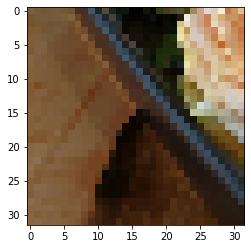

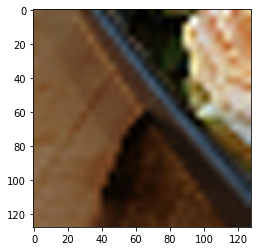

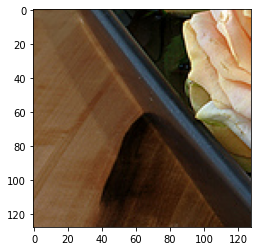

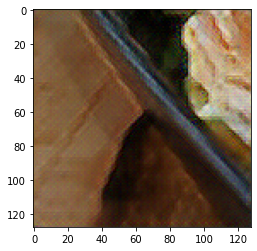

In [ ]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_dataset_mapped.take(1):
  plt.figure()
  plt.imshow(x[0].numpy())
  plt.show()
  plt.imshow(bicubic_interpolate(x[0].numpy(),(128,128)))
  plt.show()
  plt.imshow(x[1].numpy())
  plt.show()

  pred=SRResnet(x[0].numpy().reshape(1,32,32,3))
  plt.imshow(pred[0])
  plt.show()

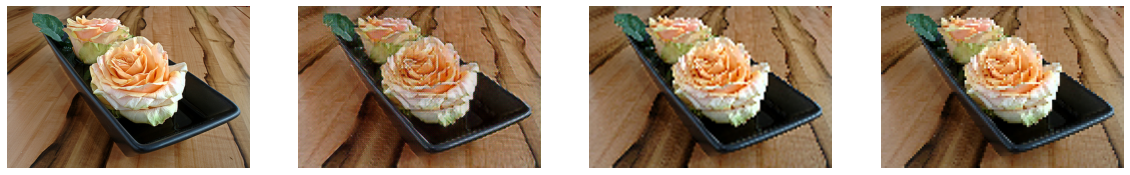

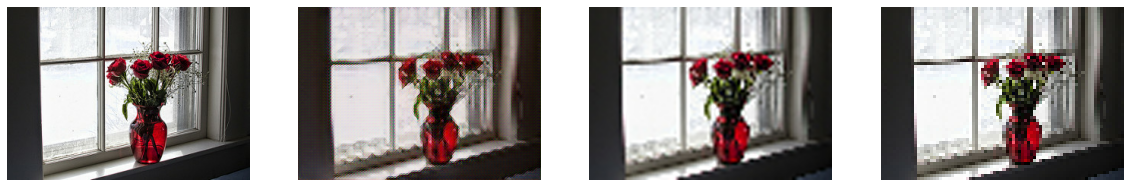

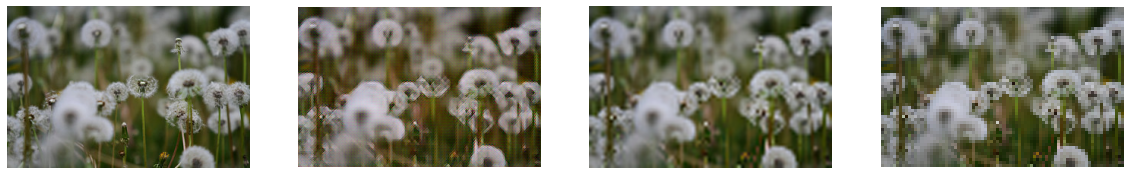

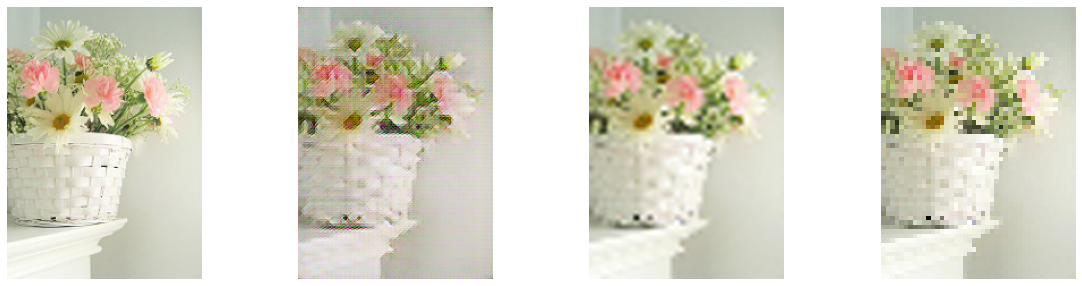

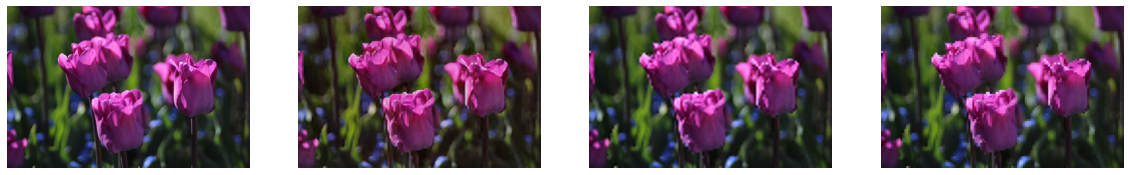

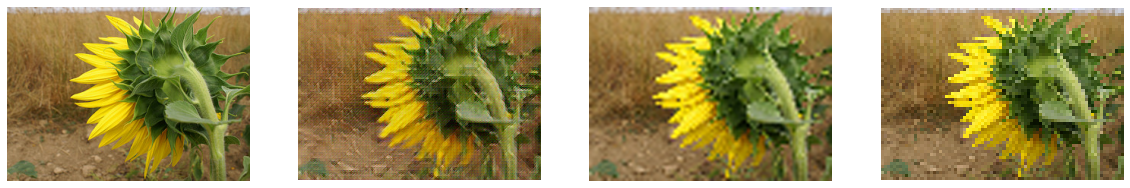

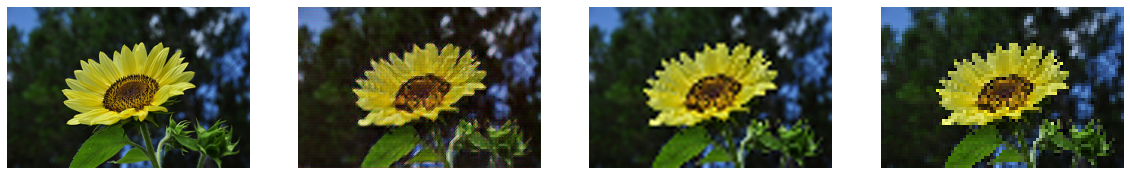

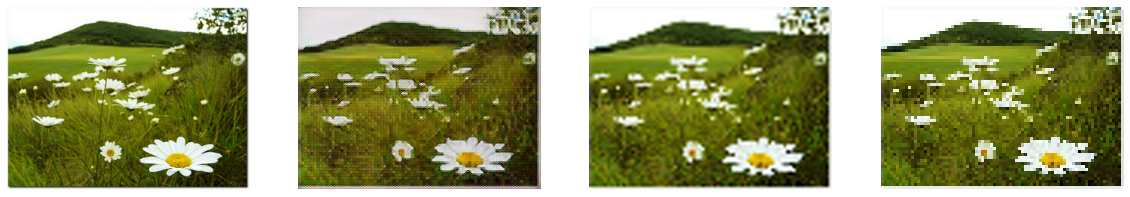

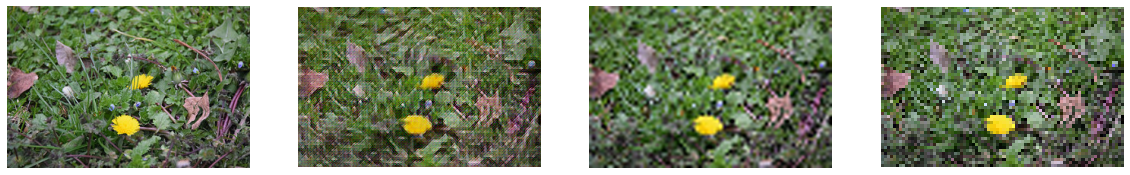

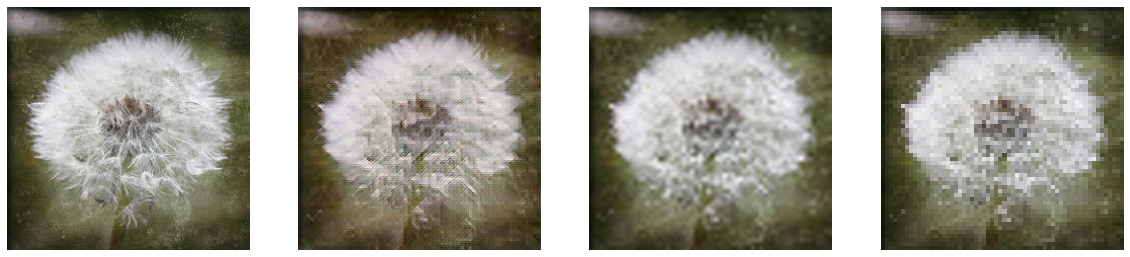

In [ ]:
train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE)
for x in train_data.take(10):
  fig=plt.figure(figsize=(20,5))
  im=x['image'].numpy()
  plt.subplot(1,4,1)
  plt.imshow(im)
  plt.axis('off')

  plt.subplot(1,4,4)
  lr=bicubic_interpolate(im,(im.shape[1]//4,im.shape[0]//4))
  plt.imshow(lr)  
  plt.axis('off')

  plt.subplot(1,4,2)
  pred=SRResnet(np.array([lr])/255)
  plt.imshow(pred[0].numpy())
  plt.axis('off')

  plt.subplot(1,4,3)
  bic=bicubic_interpolate(lr,(im.shape[1],im.shape[0]))
  plt.imshow(bic)
  plt.axis('off')

  plt.show()
  #print(x['image'].numpy(),lr)
  #print('Bicubic PSNR:',PSNR(x['image'].numpy(),lr),'  SRCNN PSNR:',PSNR(x['image'].numpy(),pred[0].numpy()))